# **Data science final project - NLP: Fake & Real news classification**

## **Irena Shtelman Kravitz & Cecilia Moskovitch**

The objective of this project is to build a classifier that can predict whether a piece of news is fake based on its content, by using several different NLP models.

What is fake news? - Fake news is false or misleading information presented as news. It often has the aim of damaging the reputation of a person or entity, or making money through advertising revenue. Once common in print, the prevalence of fake news has increased with the rise of social media. Fake news can reduce the impact of real news by competing with it  (https://en.wikipedia.org/wiki/Fake_news).

The data used for this project was drawn from Kaggle datasets (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

Presentation link: https://docs.google.com/presentation/d/1t7UL8YoaK648FhZW_aWcatSQAbW-K0ni/edit#slide=id.p1

# **Imports:**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os  # Operating system

from datetime import datetime  # For time analysis

from sklearn.utils import shuffle  # For data shuffling

from wordcloud import WordCloud, STOPWORDS  # For world cloud

# For spaCy:
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS   

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer  # For TF-IDF

from nltk.util import ngrams  # For ngrams 

# For BOW Models:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedShuffleSplit  # For data splitting, Cross validation, Grid Search

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model scores

# For random seeds:
my_seed = 512
np.random.seed(my_seed)
import random 
random.seed(my_seed)

# For deep learning models:
import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, LSTM, Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

### Set Display options:

In [2]:
import colorsStyles_displayOptions as cstyle # For colored printing
cstyle.display_options_for_pandas()  # set print options:

### To ignore warnings (or to show them just once):

In [5]:
import warnings
warnings.filterwarnings('ignore')

# warnings.filterwarnings(action='once')  # to show a warning once 

# **PART1: Initial EDA & visualizations:**

## **EDA for Real news:**

###  **Get the data:**

In [6]:
real_news = pd.read_csv('True.csv', parse_dates=['date'])

print(real_news.shape, "\n")  #(21417, 4)
real_news.info()
print('\n')
display(real_news.head(3))

(21417, 4) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 669.4+ KB




title                                                                                                                                                                                                                                                                                                         text       subject       date
0  As U.S. budget fight looms, Republicans flip their fiscal script  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under ...  politicsNews 2017-12-31
1  U.S. military to accept transgender recruits on Monday: Pentagon  WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. ...  politicsNews 2017-12-29
2      Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator...  politicsNews 2017-12-31

###  **Check missing values:**

In [7]:
real_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### **Check dates range:**

In [5]:
print("Min date: ", real_news.date.min())
print("Max date: ",real_news.date.max())

Min date:  2016-01-13 00:00:00
Max date:  2017-12-31 00:00:00


## **EDA for Fake news:**

###  **Get the data:**

In [8]:
fake_news = pd.read_csv('Fake.csv', parse_dates=['date'])

print(fake_news.shape, "\n")  #(23481, 4)
fake_news.info()
print('\n')
display(fake_news.head(3))

(23481, 4) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB




title                                                                                                                                                                                                                                                                                                         text subject               date
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows strong...    News  December 31, 2017
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation  House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trum...    News  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’  On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he ...    News  December 30, 2017

**Conclusions:** 

The 'date' column Dtype is "object" and not "datetime64[ns]" so there are values in some of the rows which are not a date and should be dropped.


### **Find and drop rows in which the "date" column is incorrect (with preview to these values before drop):**

In [9]:
def find_and_drop_observs_with_wrong_date (df, col, drop=True):
  df['temp_date'] = pd.to_datetime(df[col], errors='ignore')  #invalid parsing will return the input
  df[col] = pd.to_datetime(df[col], errors='coerce')          #invalid parsing will be set as 'NaN'

  # Check the results:
  print(f"Number of raws with incorrect values in column '{col}'=", df[df[col].isna()].shape[0])
  print("\n", df[df[col].isna()] ) 

  # Drop all Nulls:
  if(drop): df.dropna(inplace = True)
  # Drop temporary column:
  df.drop( columns='temp_date', inplace=True) 
  return

In [10]:
print(f"Shape before dropping observations with wrong date: {fake_news.shape}")  #(23481, 4)
display(find_and_drop_observs_with_wrong_date (df=fake_news, col='date'))
print(f"\nShape after dropping observations with wrong date: {fake_news.shape}")  #(23471, 4)

Shape before dropping observations with wrong date: (23481, 4)
Number of raws with incorrect values in column 'date'= 10

                                                                                                                                                        title                                                                                                                                                                                                                                                                                                         text          subject date                                                                                                                                              temp_date
9358       https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/                                                                                          

None


Shape after dropping observations with wrong date: (23471, 4)


In [11]:
print(fake_news.shape)  #(23471, 4)
fake_news.info()
display(fake_news.head(3))

(23471, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23471 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23471 non-null  object        
 1   text     23471 non-null  object        
 2   subject  23471 non-null  object        
 3   date     23471 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 916.8+ KB


title                                                                                                                                                                                                                                                                                                         text subject       date
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows strong...    News 2017-12-31
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation  House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trum...    News 2017-12-31
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’  On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he ...    News 2017-12-30

###  **Check missing values:**

In [12]:
fake_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### **Check dates range:**

In [13]:
print("Min date: ", fake_news.date.min())
print("Max date: ", fake_news.date.max())

Min date:  2015-03-31 00:00:00
Max date:  2018-02-19 00:00:00


**Conclusions**: 

*   There are fake news observations for the period between MAR 2015 -- > FEB 2018 & real news observations for the period between JAN 2016 -- > DEC 2017.
*   In order to train the models correctly, we decided to use fake news observations only for the same period we have observations for real news as well, so we will drop the rest of the observations for fake news.


### **Dropping fake news observations which are not in the period JAN 2016 -- > DEC 2017:**

In [14]:
fake_news_2016_2017 = fake_news [(fake_news['date'] >= '2016-01-01 00:00:00') &
                                  (fake_news['date'] <= '2017-12-31 00:00:00')]

print(fake_news_2016_2017.shape)  #(20957, 4)
print(fake_news.shape)            #(23471, 4)

(20957, 4)
(23471, 4)


In [15]:
print("Min date: ", fake_news_2016_2017.date.min())
print("Max date: ", fake_news_2016_2017.date.max())

Min date:  2016-01-01 00:00:00
Max date:  2017-12-31 00:00:00


## **Find observations where 'text' & 'title' columns have whitespace characters only:**

In [16]:
# This method adds two new columns as indication to text-cells with whitespaces only (in 'Title' & 'Text' columns)
# and drops all rows where both columns (Title & Text) have whitespace only:
def find_rows_with_wspaces_only_in_title_and_txt (df, title_col, txt_col, drop_if_title_only=False, drop_if_txt_only=False):
  #find all rows with whitespace only, add temporary columns:
  df['whitespaces_title'] = df[title_col].map(lambda x: x.isspace())
  df['whitespaces_txt'] = df[txt_col].map(lambda x: x.isspace())

  #print the results for titles:
  print( f"\nNumber of raws with whitespaces_only in column '{title_col}'=", df[df['whitespaces_title']].shape[0], "\n") 
  if (df[df['whitespaces_title']].shape[0]>0): display( df[df['whitespaces_title']].head(3))

  #print the results for texts:
  print( f"\nNumber of raws with whitespaces_only in column '{txt_col}'=", df[df['whitespaces_txt']].shape[0], "\n") 
  if (df[df['whitespaces_txt']].shape[0]>0): display( df[df['whitespaces_txt']].head(3)) 

  #print all rows where both cols (Title & Text) have whitespace only:
  print( f"\nNumber of raws with whitespaces chars only in both cols (Title & Text) =", \
        df[df['whitespaces_title'] & df['whitespaces_txt']].shape[0], "\n") 
  
  if (df[df['whitespaces_title'] & df['whitespaces_txt']].shape[0]>0):  
    display( df[df['whitespaces_title'] & df['whitespaces_txt']].head(3))  
    # Drop all rows where both cols (Title & Text) have whitespace only:
    df.drop( df[df['whitespaces_title'] & df['whitespaces_txt']].index, inplace = True)  
  
  # Drop all rows where 'title' only have whitespace only:
  if (drop_if_title_only==True): df.drop( df[df['whitespaces_title']].index, inplace = True)    
  # Drop all rows where 'text' only have whitespace only:
  if (drop_if_txt_only==True): df.drop( df[df['whitespaces_txt']].index, inplace = True)

  # # Drop temporary columns:
  # df.drop( columns=('whitespaces_title', 'whitespaces_txt'), inplace=True) 
  return #df     


### **Real news observations where 'text' & 'title' columns have whitespace characters only:**

In [17]:
print (real_news.shape)  # (21417, 4)
find_rows_with_wspaces_only_in_title_and_txt (df=real_news, title_col ='title', txt_col='text')

print(real_news.shape)  # (21417, 6)
display(real_news.head(3))

(21417, 4)

Number of raws with whitespaces_only in column 'title'= 0 


Number of raws with whitespaces_only in column 'text'= 1 



title text       subject       date  whitespaces_title  whitespaces_txt
8970  Graphic: Supreme Court roundup       politicsNews 2016-06-16              False             True


Number of raws with whitespaces chars only in both cols (Title & Text) = 0 

(21417, 6)


title                                                                                                                                                                                                                                                                                                         text       subject       date  whitespaces_title  whitespaces_txt
0  As U.S. budget fight looms, Republicans flip their fiscal script  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under ...  politicsNews 2017-12-31              False            False
1  U.S. military to accept transgender recruits on Monday: Pentagon  WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. ...  politicsNews 2017-12-29              False            False
2      Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator...  politicsNews 2017-12-31              False            False

### **Drop real news observations where 'text' column has whitespace characters only:**

In [18]:
print(real_news.shape)   # (21417, 6)
real_news = real_news[real_news['whitespaces_txt'] == False]
print(real_news.shape)   # (21416, 6)

(21417, 6)
(21416, 6)


### **Fake news observations where 'text' & 'title' columns have whitespace characters only:**

In [19]:
print(fake_news_2016_2017.shape)  #(20957, 4)
find_rows_with_wspaces_only_in_title_and_txt (df=fake_news_2016_2017, title_col ='title', txt_col='text')

print(fake_news_2016_2017.shape)  #(20957, 6)
display(fake_news_2016_2017.head(3))

(20957, 4)

Number of raws with whitespaces_only in column 'title'= 0 


Number of raws with whitespaces_only in column 'text'= 569 



title text   subject       date  whitespaces_title  whitespaces_txt
10923                                   TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?       politics 2017-05-10              False             True
11041  Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO]       politics 2017-04-26              False             True
11190                                WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video]       politics 2017-04-06              False             True


Number of raws with whitespaces chars only in both cols (Title & Text) = 0 

(20957, 6)


title                                                                                                                                                                                                                                                                                                         text subject       date  whitespaces_title  whitespaces_txt
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows strong...    News 2017-12-31              False            False
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation  House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trum...    News 2017-12-31              False            False
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’  On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he ...    News 2017-12-30              False            False

### **Drop fake news observations where 'text' column has whitespace characters only:**

In [20]:
print(fake_news_2016_2017.shape)   # (20957, 6)
fake_news_2016_2017 = fake_news_2016_2017[fake_news_2016_2017['whitespaces_txt'] == False]
print(fake_news_2016_2017.shape)   # (20388, 6)

(20957, 6)
(20388, 6)


### **Add "category" column:**

In [21]:
real_news['category'] = 'real news'
fake_news_2016_2017['category'] = 'fake news'

## **Create a NEW dataset by concatenating fake and real datasets:**

In [22]:
df_for_analysis = pd.concat([real_news, fake_news_2016_2017]) 

print(df_for_analysis.shape)  #(41804, 7)
df_for_analysis.head()

(41804, 7)


title                                                                                                                                                                                                                                                                                                         text       subject       date  whitespaces_title  whitespaces_txt   category
0       As U.S. budget fight looms, Republicans flip their fiscal script  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under ...  politicsNews 2017-12-31              False            False  real news
1       U.S. military to accept transgender recruits on Monday: Pentagon  WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. ...  politicsNews 2017-12-29              False            False  real news
2           Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator...  politicsNews 2017-12-31              False            False  real news
3            FBI Russia probe helped by Australian diplomat tip-off: NYT  WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexande...  politicsNews 2017-12-30              False            False  real news
4  Trump wants Postal Service to charge 'much more' for Amazon shipments  SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past.     “Why is the United States Post Office, which is losin...  politicsNews 2017-12-29              False            False  real news

### **Add new columns with  'date' details:**

In [23]:
def extract_datetime_details(df):
  df['year'] = df['date'].dt.year
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['day_of_week'] = df['date'].dt.dayofweek
  df['week_of_year'] = df['date'].dt.weekofyear
  return

# If the date format comes in datetime, we can also extract the day/month/year using the to_period function

In [25]:
extract_datetime_details(df=df_for_analysis)

print(df_for_analysis.shape) #(41804, 13)
df_for_analysis.head(2)

(41804, 13)


title                                                                                                                                                                                                                                                                                                         text       subject       date  whitespaces_title  whitespaces_txt   category  year  quarter  month  day  day_of_week  week_of_year
0  As U.S. budget fight looms, Republicans flip their fiscal script  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under ...  politicsNews 2017-12-31              False            False  real news  2017        4     12   31            6            52
1  U.S. military to accept transgender recruits on Monday: Pentagon  WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. ...  politicsNews 2017-12-29              False            False  real news  2017        4     12   29            4            52

### **Check if there are duplicated observations:**

In [26]:
df_for_analysis.duplicated().sum()  #208

208

**Conclusions**: 

*   There are 208 duplicated observations, so we will drop them.


### **Drop duplicated observations:**

In [27]:
print (df_for_analysis.shape)  #(41804, 13)

df_for_analysis.drop_duplicates(keep='first', inplace=True)  #Drop duplicates except for the first occurrence

print (df_for_analysis.shape)  #(41596, 13)
print (df_for_analysis.duplicated().sum())  # 0

(41804, 13)
(41596, 13)
0


### **Check if there are observations with the same data in all columns that have a different category type (real / fake news):**

In [28]:
df_to_check_duplicates_with_diff_categoty = df_for_analysis.drop(['category'], axis = 1)
df_to_check_duplicates_with_diff_categoty.duplicated().sum()   # there is no any data leak between Fake and Real news

0

**Conclusions**: 

*   There are no observations with the same data in all the columns, but with a different category type (real or fake news).


In [29]:
df_for_analysis_full = df_for_analysis

In [31]:
print (df_for_analysis_full.shape)  #(41596, 13)
df_for_analysis_full.head(3)

(41596, 13)


title                                                                                                                                                                                                                                                                                                         text       subject       date  whitespaces_title  whitespaces_txt   category  year  quarter  month  day  day_of_week  week_of_year
0  As U.S. budget fight looms, Republicans flip their fiscal script  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under ...  politicsNews 2017-12-31              False            False  real news  2017        4     12   31            6            52
1  U.S. military to accept transgender recruits on Monday: Pentagon  WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. ...  politicsNews 2017-12-29              False            False  real news  2017        4     12   29            4            52
2      Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator...  politicsNews 2017-12-31              False            False  real news  2017        4     12   31            6            52

## **Subject variable analysis:**

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Government News'),
  Text(1, 0, 'Middle-east'),
  Text(2, 0, 'News'),
  Text(3, 0, 'US_News'),
  Text(4, 0, 'left-news'),
  Text(5, 0, 'politics'),
  Text(6, 0, 'politicsNews'),
  Text(7, 0, 'worldnews')])

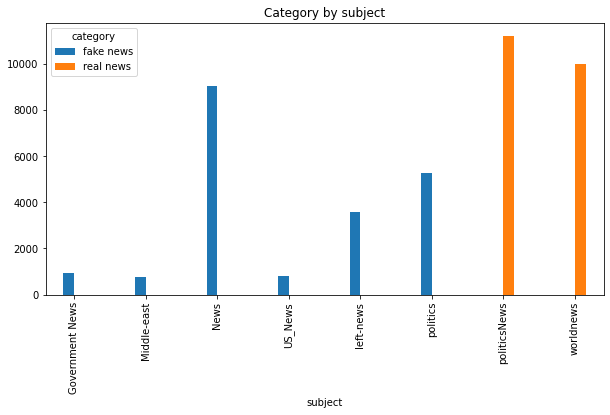

In [32]:
ax = df_for_analysis_full.groupby("category").subject.value_counts().unstack(0).plot.bar(figsize= (10,5), width = 0.3)
ax.set_title("Category by subject")
plt.xticks(rotation = 90)

**Conclusions**: 

We can see that the topics in "subject" column are different for each category - 2 topics for real news and 6 different topics for fake news, so this column should be excluded.





### **Additional analysis for 'Subject' column - check if there are any duplicated samples with different values in "subject" column:**

In [33]:
df_without_subject_temp = df_for_analysis_full.drop(columns=("subject"), inplace=False)
df_without_subject_temp.duplicated().sum()   # 4574

4574

#### **Conclusions**: 

*   There are 4,574 duplicated observations, so we will drop them.


### **Drop duplicated observations after removing "subject" column:**

In [34]:
print(df_for_analysis_full.shape)  #(41596, 13)
df_for_analysis_full.drop(columns=("subject"), inplace=True)
print(df_for_analysis_full.shape)  #(41596, 12)
df_for_analysis_full.drop_duplicates(keep='first', inplace=True)
print(df_for_analysis_full.shape)  #(37022, 12)

(41596, 13)
(41596, 12)
(37022, 12)


### **Target variable - "category" column (real or fake news):**

In [35]:
print(df_for_analysis_full.category.value_counts(),"\n")
print(df_for_analysis_full.category.value_counts(normalize = True))

real news    21199
fake news    15823
Name: category, dtype: int64 

real news    0.5726
fake news    0.4274
Name: category, dtype: float64


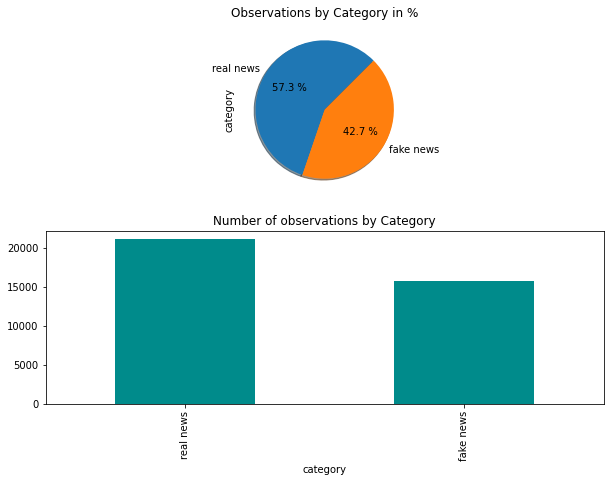

In [36]:
f,ax = plt.subplots(2,1, figsize=(10,7))

ax[0] = df_for_analysis_full.category.value_counts().plot.pie(autopct='%.1f %%',ax = ax[0], shadow=True, startangle=45)
ax[0].set_title('Observations by Category in %')

ax[1] = df_for_analysis_full.category.value_counts().plot.bar(color="darkcyan")
ax[1].set_title("Number of observations by Category")
ax[1].set_xlabel("category")

plt.show()

**Conclusions**: 

*   **The data is balanced:**

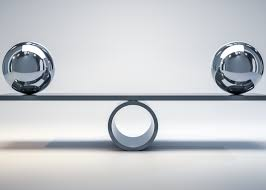


## **Date variables analysis:**

### **Year variable:**

(array([0, 1]), [Text(0, 0, '2016'), Text(1, 0, '2017')])

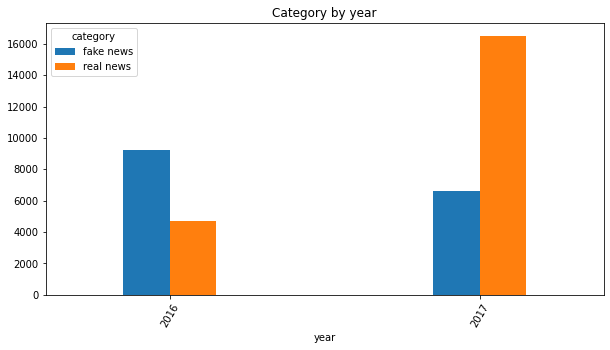

In [37]:
ax = df_for_analysis_full.groupby("category").year.value_counts().unstack(0).plot.bar(figsize= (10,5), width = 0.3)

ax.set_title("Category by year")
plt.xticks(rotation = 60)

#### **Conclusions**: 

*   There is a difference in the number of observation for fake and real news during 2016 & 2017. There are many more fake news samples than real news samples during 2016 and the opposite during 2017.
*   This might be due to the fact that there were indeed more fake news during 2016 and more real news during 2017 or it might just be because of a random samples choosing done by the person who created the data set. We tried finding out how the data was collected, but no such information was found. In real life we would approach the data set origin and find out.

In [38]:
df_2016 = df_for_analysis_full[df_for_analysis_full["year"] == 2016]
df_2017 = df_for_analysis_full[df_for_analysis_full["year"] == 2017]

In [39]:
def visualize_category_by_dateCol (df, col, year, rangeVal):
  #1:
  ax = df.groupby([col, "category"]).category.count().unstack(1).plot(figsize= (10 ,3))
  ax.set_xticks(rangeVal)
  ax.set(xlabel = col, ylabel = "Number of observations", title = f"Category by '{col}' during "+year)
  plt.show()

  #2--------
  ax = df.groupby("category")[col].value_counts().unstack(0).plot.bar(figsize= (10,3), width = 0.2)
  ax.set_title(f"Category by '{col}' during "+year)
  plt.xticks(rotation = 90)
  return 

### **Month variable:**

Unique months in entire dataset: [12 11 10  9  8  7  6  5  4  3  2  1] 



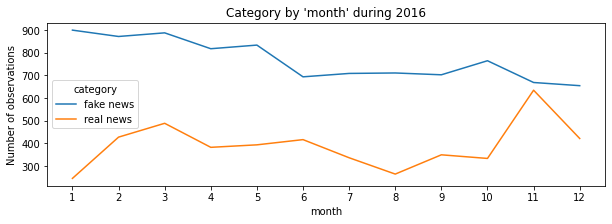

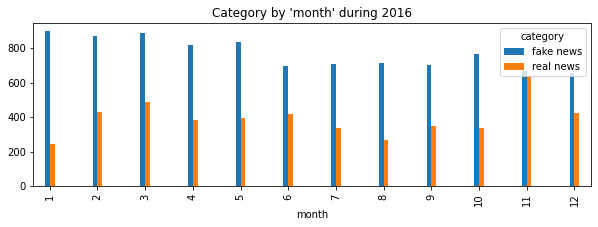

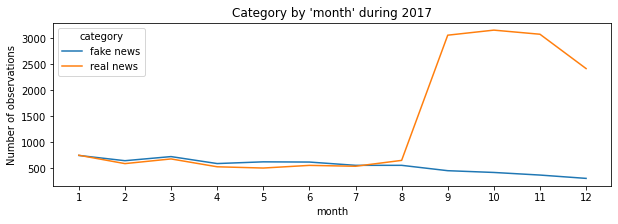

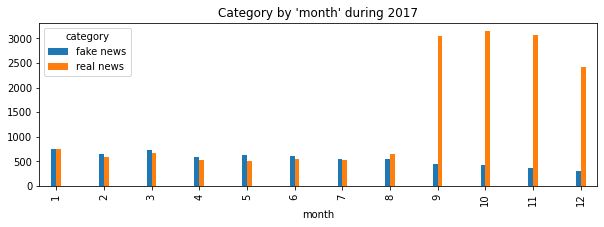

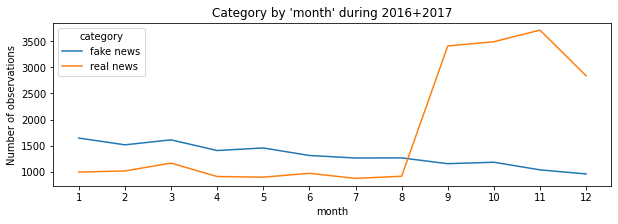

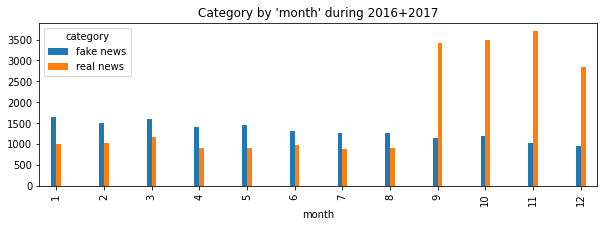

In [40]:
print("Unique months in entire dataset:", df_for_analysis_full['month'].unique(),"\n")

visualize_category_by_dateCol (df=df_2016, col='month', year='2016', rangeVal=range(1, 13))
visualize_category_by_dateCol (df=df_2017, col='month', year='2017', rangeVal=range(1, 13))
visualize_category_by_dateCol (df=df_for_analysis_full, col='month', year='2016+2017', rangeVal=range(1, 13))

### **Day of week variable:**

Unique Day of Week in entire dataset: [6 4 5 3 0 2 1] 



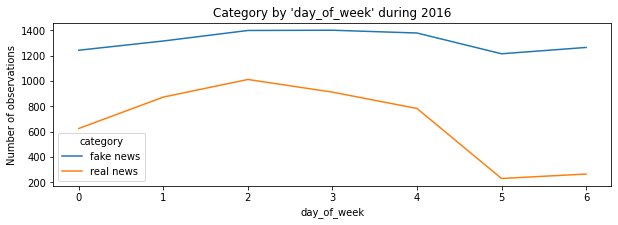

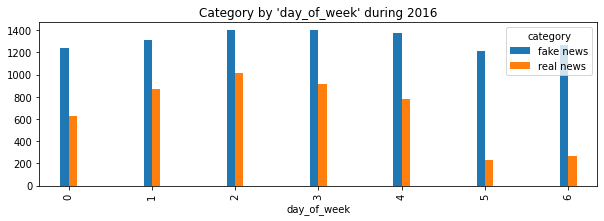

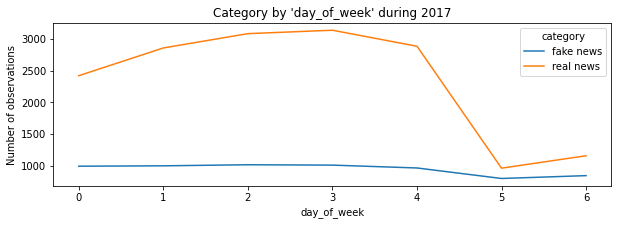

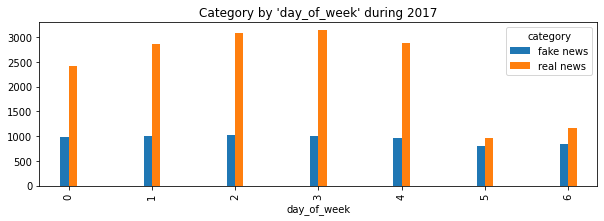

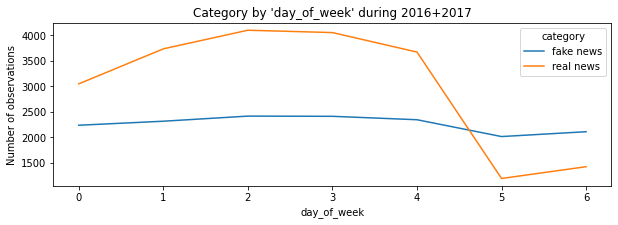

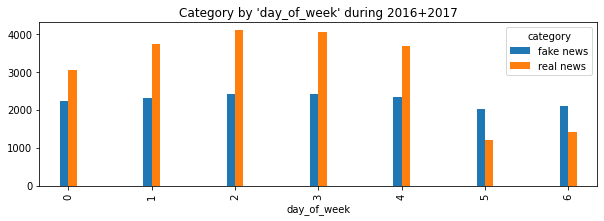

In [41]:
print("Unique Day of Week in entire dataset:", df_for_analysis_full['day_of_week'].unique(),"\n")

visualize_category_by_dateCol (df=df_2016, col="day_of_week", year="2016", rangeVal=range(0, 7) )
visualize_category_by_dateCol (df=df_2017, col="day_of_week", year="2017", rangeVal=range(0, 7) )
visualize_category_by_dateCol (df=df_for_analysis_full, col="day_of_week", year="2016+2017", rangeVal=range(0, 7) )

### **Week of year variable:**

Unique Week of Year in entire dataset: [52 51 50 46 49 48 47 43 45 44 42 41 40 39 38 37 36 35 34 33 32 31 30 29
 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5
  4  3  2  1 53] 



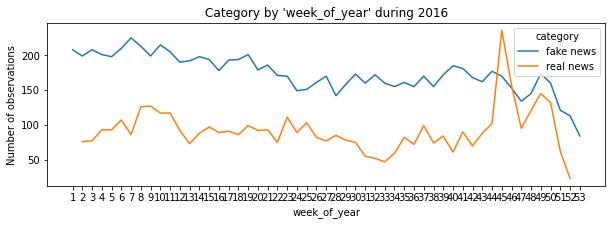

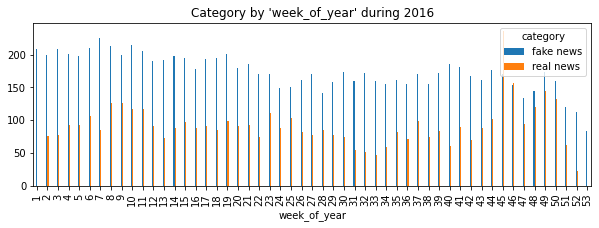

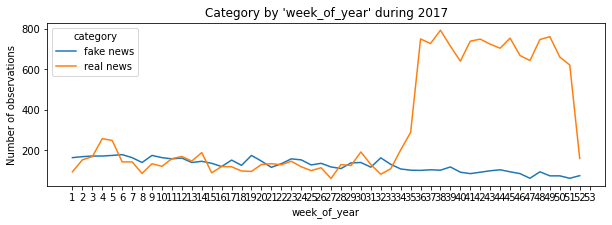

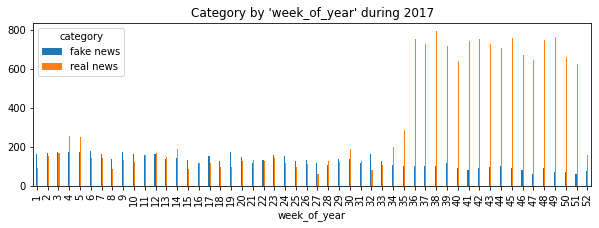

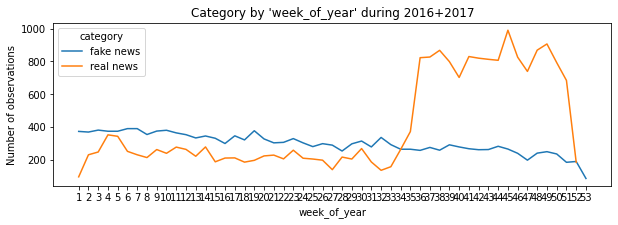

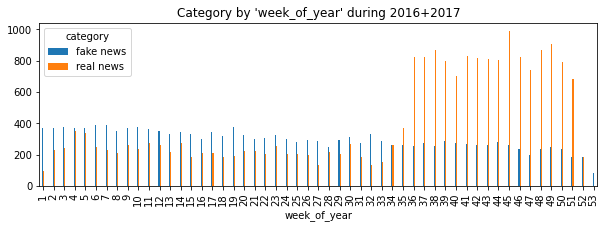

In [42]:
print("Unique Week of Year in entire dataset:", df_for_analysis_full['week_of_year'].unique(),"\n")

visualize_category_by_dateCol (df=df_2016, col="week_of_year", year="2016", rangeVal=range(1, 54) )
visualize_category_by_dateCol (df=df_2017, col="week_of_year", year="2017", rangeVal=range(1, 54) )
visualize_category_by_dateCol (df=df_for_analysis_full, col="week_of_year", year="2016+2017", rangeVal=range(1, 54) )

### **Quarter variable:**

Unique Quarters in entire dataset: [4 3 2 1] 



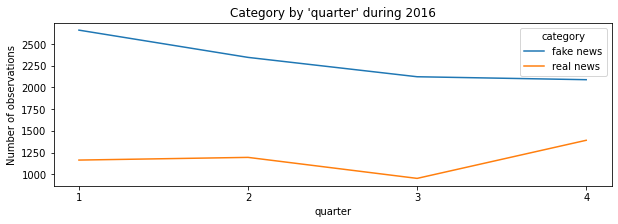

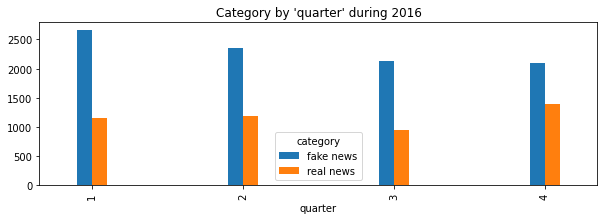

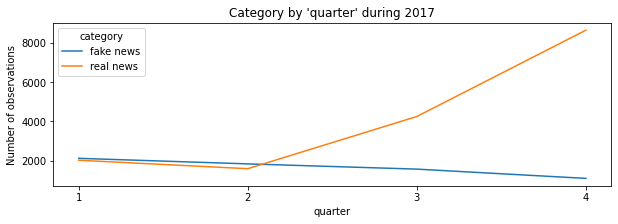

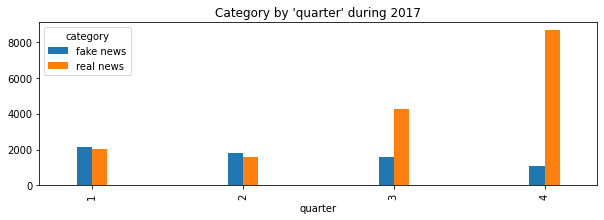

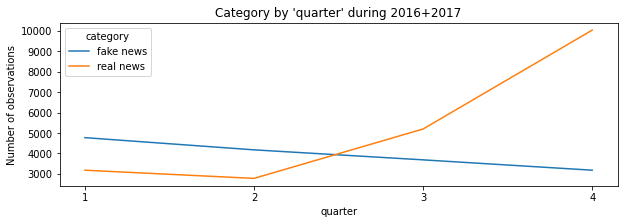

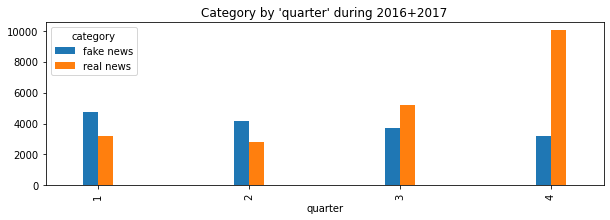

In [43]:
print("Unique Quarters in entire dataset:", df_for_analysis_full['quarter'].unique(),"\n")

visualize_category_by_dateCol (df=df_2016, col="quarter", year="2016", rangeVal=range(1, 5) )
visualize_category_by_dateCol (df=df_2017, col="quarter", year="2017", rangeVal=range(1, 5) )
visualize_category_by_dateCol (df=df_for_analysis_full, col="quarter", year="2016+2017", rangeVal=range(1, 5) )

### **Create function for world cloud:**

In [44]:
def create_word_cloud(text):
  wordcloud = WordCloud(
      width = 3000,
      height = 2000,
      background_color = 'black',
      stopwords = STOPWORDS).generate(text)  # we can also use stopwords = set(nltk.corpus.stopwords.words("english")) - from nltk
  fig = plt.figure(
      figsize = (10, 10),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

### **Dates with most observations for real & fake news during 2016-2017 years:**

In [45]:
def Date_with_max_observs_real_and_fake_news(df, col, year, catg):
  print(f"The most observations of {catg} in {year} were at ", df[df[col] == catg].groupby('date')[col].count().idxmax())
  print(f"Max observations of {catg} in {year} => ", df[df[col] == catg].groupby('date')[col].count().max())
  return

In [46]:
Date_with_max_observs_real_and_fake_news(df=df_2016, col="category", year="2016", catg='real news')
Date_with_max_observs_real_and_fake_news(df=df_2016, col="category", year="2016", catg='fake news')
print("\n")
Date_with_max_observs_real_and_fake_news(df=df_2017, col="category", year="2017", catg='real news')
Date_with_max_observs_real_and_fake_news(df=df_2017, col="category", year="2017", catg='fake news')

The most observations of real news in 2016 were at  2016-11-09 00:00:00
Max observations of real news in 2016 =>  115
The most observations of fake news in 2016 were at  2016-02-16 00:00:00
Max observations of fake news in 2016 =>  45


The most observations of real news in 2017 were at  2017-12-06 00:00:00
Max observations of real news in 2017 =>  166
The most observations of fake news in 2017 were at  2017-02-09 00:00:00
Max observations of fake news in 2017 =>  36


### **Year 2016:** Analyzing the **Titles of all Real news** that were published **on "2016-11-09"** (the day with Max Real news in 2016) using **WordCloud** - **before preprocessing:**

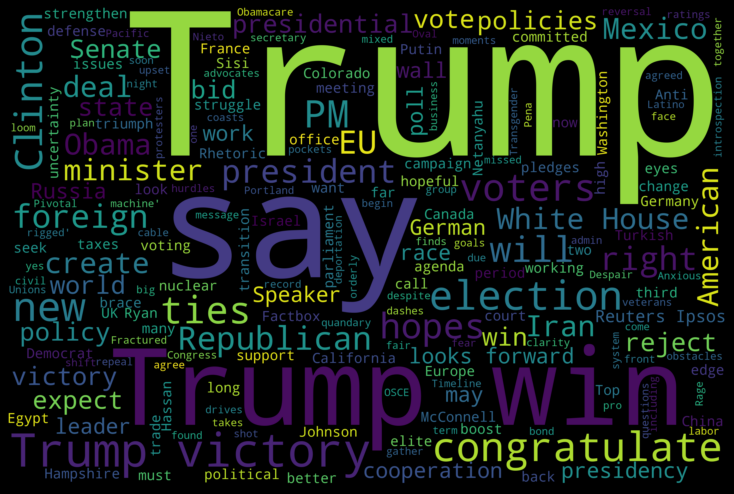

In [42]:
real_news_2016 = df_2016[df_2016["category"] == "real news"]
date_with_max_real_news_2016 = real_news_2016[real_news_2016["date"] == "2016-11-09" ]

titles_20161109 = ""
for news in date_with_max_real_news_2016.title.values:
    titles_20161109 += f" {news}"

create_word_cloud(titles_20161109)

### **Conclusions:** 

**November 9th 2016 is the day Trump won the elections:**


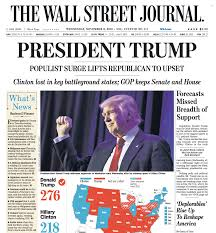

### **Year 2017:** Analyzing the **Titles of all Real news** that were published **on "2017-12-06"** (the day with Max Real news in 2017) using **WordCloud** - **before preprocessing:**

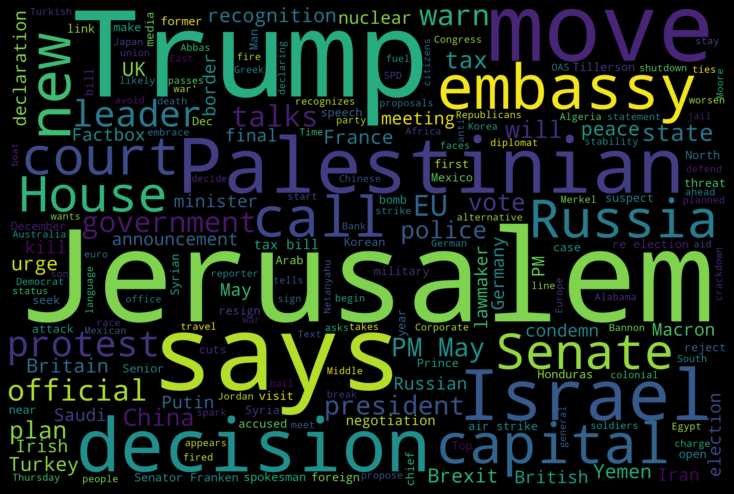

In [43]:
real_news_2017 = df_2017[df_2017["category"] == "real news"]
date_with_max_real_news_2017 = real_news_2017[real_news_2017["date"] == "2017-12-06" ]

titles_20171206 = ""
for news in date_with_max_real_news_2017.title.values:
    titles_20171206 += f" {news}"

create_word_cloud(titles_20171206)

**Conclusions**:
DEC 6 2017: President Donald J. Trump’s Proclamation on Jerusalem as the Capital of the State of Israel:

https://www.whitehouse.gov/briefings-statements/president-donald-j-trumps-proclamation-jerusalem-capital-state-israel/

### **Year 2016:** Analyzing the **Titles of all Fake news** that were published **on "2016-02-16"** (the day with Max Fake news in 2016) using **WordCloud** - **before preprocessing:**

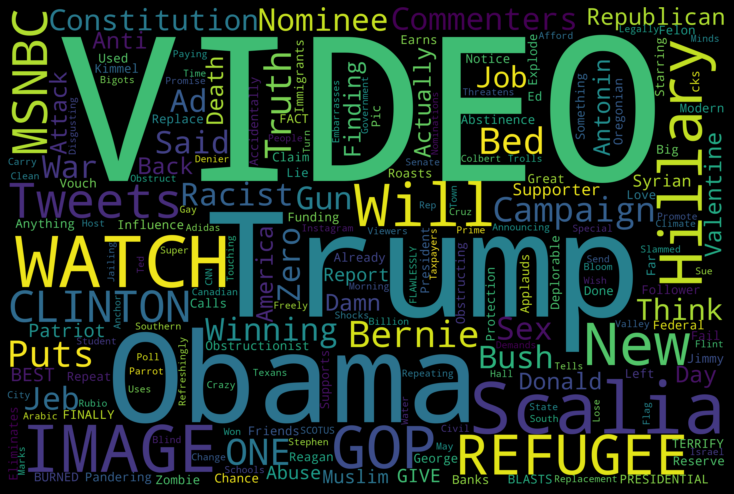

In [44]:
fake_news_2016 = df_2016[df_2016["category"] == "fake news"]
date_with_max_fake_news_2016 = fake_news_2016[fake_news_2016["date"] == "2016-02-16" ]

titles_fake_20160216 = ""
for news in date_with_max_fake_news_2016.title.values:
    titles_fake_20160216 += f" {news}"

create_word_cloud(titles_fake_20160216)

### **Year 2017:** Analyzing the **Titles of all Fake news** that were published **on "2017-02-09"** (the day with Max Fake news in 2017) using **WordCloud** - **before preprocessing:**

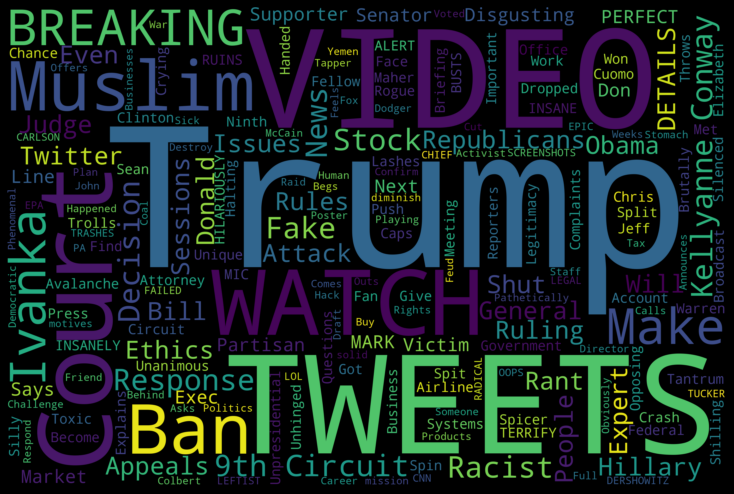

In [45]:
fake_news_2017 = df_2017[df_2017["category"] == "fake news"]
date_with_max_fake_news_2017 = fake_news_2017[fake_news_2017["date"] == "2017-02-09" ]

titles_fake_20170209 = ""
for news in date_with_max_fake_news_2017.title.values:
    titles_fake_20170209 += f" {news}"

create_word_cloud(titles_fake_20170209)

**Conclusions**: 

*   We can see that in both 2016 & 2017 two frequent words in fake news during the dates with max fake news were "trump" & "video". We need to investigate further to understand the reason why during these dates there were max fake news.
*   Dates columns should be excluded.

## **Text variables analysis - "title" & "text" columns:**

### **Create a new column "title_and_text" which combines "title" & "text" columns:**

In [47]:
df_for_analysis_full["title_and_text"] = df_for_analysis_full["title"] + " " + df_for_analysis_full["text"]
df_for_analysis_full.columns

Index(['title', 'text', 'date', 'whitespaces_title', 'whitespaces_txt', 'category', 'year', 'quarter', 'month', 'day', 'day_of_week', 'week_of_year', 'title_and_text'], dtype='object')

### **Drop "date", "year", "quarter", "month", "day", "day_of_week", "week_of_year", "whitespaces_title", "whitespaces_txt", "title" & "text" columns:**

In [48]:
print(df_for_analysis_full.shape)  #(37022, 13)
df_for_analysis_full.drop(columns=(["date", "year", "quarter",
                                    "month", "day", "day_of_week",
                                    "week_of_year", "whitespaces_title",
                                    "whitespaces_txt", "title",
                                    "text"]), inplace=True)
print(df_for_analysis_full.shape)  #(37022, 2)
df_for_analysis_full.drop_duplicates(keep='first', inplace=True)
print(df_for_analysis_full.shape)  #(37019, 2)

(37022, 13)
(37022, 2)
(37019, 2)


### **Save the concatenated data in a new CSV file:**

In [47]:
df_for_analysis_full.to_csv('news_2016_2017_with_text_&_title_col.csv')

# **PART2: Preprocessing with spaCy - data cleaning, feature engineering, additional EDA and visualizations:**

In [49]:
df_for_models = pd.read_csv('news_2016_2017_with_text_&_title_col.csv', index_col=0)
# df_for_models = df_for_analysis_full.copy()
print(df_for_models.shape)   # (37019, 2)
print(df_for_models.category.value_counts())  # real news 21196, fake news 15823
df_for_models.head()

(37019, 2)
real news    21196
fake news    15823
Name: category, dtype: int64


category                                                                                                                                                                                                                                                                                               title_and_text
0  real news  As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urg...
1  real news  U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration...
2  real news  Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republi...
3  real news  FBI Russia probe helped by Australian diplomat tip-off: NYT WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The ...
4  real news  Trump wants Postal Service to charge 'much more' for Amazon shipments SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized ...

## **Add special marks to the original text:**
* Adds a mark "quoteorterm" to the beginning of every Quote or phrase/term.
* Replaces every Link to Quote with mark "quotelink" and every link to video with "videolink".
* Replaces user names with mark "username".
* Replaces emoticons with mark "emoticons".

In [7]:
def find_special_entities_and_add_special_marks_before_them (df, orig_col, col_with_marks ):
    # df[col_with_marks] = df[orig_col].replace( r"[:]{1}[\s]*[\"\“\'\‘]", " __quoteorterm__ ", regex=True)
    df[col_with_marks] = df[orig_col].replace( r"[:]{1}[\s]*[\"]", r" __quoteorterm__ :\"", regex=True)
    df[col_with_marks] = df[orig_col].replace( r"[:]{1}[\s]*[\“]", r" __quoteorterm__ :“", regex=True)
    df[col_with_marks] = df[orig_col].replace( r"[:]{1}[\s]*[\']", r" __quoteorterm__ :'", regex=True)
    df[col_with_marks] = df[orig_col].replace( r"[:]{1}[\s]*[\‘]", r" __quoteorterm__ :‘", regex=True)

    # df[col_with_marks] = df[col_with_marks].replace( r"[\s]+[\"\“\'\‘]", " __quoteorterm__ ", regex=True) 
    df[col_with_marks] = df[col_with_marks].replace( r"[\s]+[\"]", r" __quoteorterm__ \"", regex=True)
    df[col_with_marks] = df[col_with_marks].replace( r"[\s]+[\“]", r" __quoteorterm__ “", regex=True)
    df[col_with_marks] = df[col_with_marks].replace( r"[\s]+[\']", r" __quoteorterm__ '", regex=True)
    df[col_with_marks] = df[col_with_marks].replace( r"[\s]+[\‘]", r" __quoteorterm__ ‘", regex=True)

    df[col_with_marks] = df[col_with_marks].replace( r"\(VIDEO\)|\[Video\]|\[video\]|\(Video\)|\(video\)", " __videolink__ ", regex=True)
    df[col_with_marks] = df[col_with_marks].replace( r"\@[a-zA-Z\d]+[\s]{1}", " __username__ ", regex=True)
    
    df[col_with_marks] = df[col_with_marks].replace( r"(?::|;|=)(?:-)?(?:\)|\(|D|P)", " __emoticons__ ", regex=True)
    return

### **Add a new column "title_and_text_clean" that contains the special marks:**

In [8]:
find_special_entities_and_add_special_marks_before_them (df=df_for_models, orig_col="title_and_text", col_with_marks="text_with_marks") 

In [ ]:
df_for_models.sample(2)

category                                                                                                                                                                                                                                                                                               title_and_text                                                                                                                                                                                                                                                                                              text_with_marks
1717  fake news   Chaffetz’s Decision To Quit Means Big Trouble For Trump, And Here’s Exactly How Congressman Jason Chaffetz s decision to leave Congress means that bad things really are on the way for President Trump. If his presidency lasts the year, I will be shocked. I will eat a hat if that happens.Chaffetz...   Chaffetz’s Decision To Quit Means Big Trouble For Trump, And Here’s Exactly How Congressman Jason Chaffetz s decision to leave Congress means that bad things really are on the way for President Trump. If his presidency lasts the year, I will be shocked. I will eat a hat if that happens.Chaffetz...
8703  real news  Melania Trump's RNC speech produces so-so TV audience (Reuters) - Melania Trump’s big night at the Republican National Convention failed to draw bumper television audiences despite networks boosting their coverage of the gathering and husband Donald Trump promising a “showbiz” feel to the week. ...  Melania Trump's RNC speech produces so-so TV audience (Reuters) - Melania Trump’s big night at the Republican National Convention failed to draw bumper television audiences despite networks boosting their coverage of the gathering and husband Donald Trump promising a __quoteorterm__ “showbiz” fe...

### **"quoteorterm" mark analysis:**

In [ ]:
df_with_contains_quotes_or_terms = df_for_models[df_for_models["text_with_marks"].str.contains(
                                                                                   r"__quoteorterm__", case=True)]
print("'__quoteorterm__' were added to:\n", df_with_contains_quotes_or_terms["category"].value_counts(), "\n")   # real news=10917; fake_news=4919
# print (df_with_contains_quotes_or_terms[[ "title_and_text", "text_with_marks","category"]].head(3), "\n") 

'__quoteorterm__' were added to:
 real news    10917
fake news     4919
Name: category, dtype: int64 



### **"videolink" mark analysis:**

In [ ]:
df_with_contains_videolinks = df_for_models[df_for_models["text_with_marks"].str.contains(
                                                                                   r"__videolink__", case=True)]
print("'__videolink__' were added to:\n", df_with_contains_videolinks["category"].value_counts(), "\n")   # real news=0; fake_news=3837
# print (df_with_contains_videolinks[[ "title_and_text", "text_with_marks","category"]].head(3), "\n") 

'__videolink__' were added to:
 fake news    3837
Name: category, dtype: int64 



### **"username" mark analysis:**

In [ ]:
df_with_contains_usernames = df_for_models[df_for_models["text_with_marks"].str.contains(
                                                                                   r"__username__", case=True)]
print("'__username__' were added to:\n", df_with_contains_usernames["category"].value_counts(), "\n")   # real news=205; fake_news=1686
# print (df_with_contains_usernames[[ "title_and_text", "text_with_marks","category"]].head(3), "\n") 

'__username__' were added to:
 fake news    1686
real news     205
Name: category, dtype: int64 



### **"emoticons" mark analysis:**

In [ ]:
df_with_contains_usernames = df_for_models[df_for_models["text_with_marks"].str.contains(
                                                                                   r"__emoticons__", case=True)]
print("'__emoticons__' were added to:\n", df_with_contains_usernames["category"].value_counts(), "\n")   # real news=8; fake_news=688
# print (df_with_contains_usernames[[ "title_and_text", "text_with_marks","category"]].head(3), "\n") 

'__emoticons__' were added to:
 fake news    688
real news      8
Name: category, dtype: int64 



### **Conclusions:**

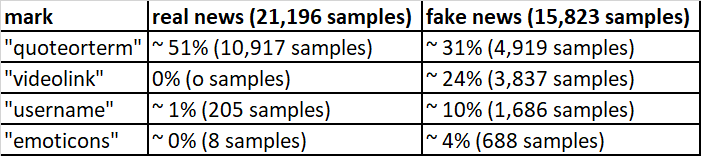

## **Using spaCy:**

### **Add "Docs_orig" column:**

In [ ]:
import en_core_web_sm 

nlp = en_core_web_sm.load()
# nlp = spacy.load("en_core_web_sm")  #For Google Colab

df_for_models['Docs_orig'] = [nlp(text) for text in df_for_models['text_with_marks']]
df_for_models.sample(3)

category                                                                                                                                                                                                                                                                                               title_and_text                                                                                                                                                                                                                                                                                              text_with_marks                                                                                                                                                                                                                                                                                                    Docs_orig
9670   fake news  PRESIDENT TRUMP Issues Warning To John McCain After Senator’s ‘Tough’ Speech President Trump hit back at Senator John McCain in a pointed statement that should make it clear that Trump isn t playing around with globalist RINO McCain anymore. You can t blame Trump because McCain just keeps nippin...  PRESIDENT TRUMP Issues Warning To John McCain After Senator’s __quoteorterm__ ‘Tough’ Speech President Trump hit back at Senator John McCain in a pointed statement that should make it clear that Trump isn t playing around with globalist RINO McCain anymore. You can t blame Trump because McCain j...  (PRESIDENT, TRUMP, Issues, Warning, To, John, McCain, After, Senator, ’s, _, _, quoteorterm, _, _, ‘, Tough, ’, Speech, President, Trump, hit, back, at, Senator, John, McCain, in, a, pointed, statement, that, should, make, it, clear, that, Trump, isn, t, playing, around, with, globalist, RINO, M...
15473  real news  Egypt Western Desert attack exposes front outside Sinai CAIRO (Reuters) - A deadly attack on the police in Egypt s Western Desert claimed by a new militant group risks opening up another front for security forces far beyond the remote northern Sinai, where they have battled a stubborn Islamic St...  Egypt Western Desert attack exposes front outside Sinai CAIRO (Reuters) - A deadly attack on the police in Egypt s Western Desert claimed by a new militant group risks opening up another front for security forces far beyond the remote northern Sinai, where they have battled a stubborn Islamic St...  (Egypt, Western, Desert, attack, exposes, front, outside, Sinai, CAIRO, (, Reuters, ), -, A, deadly, attack, on, the, police, in, Egypt, s, Western, Desert, claimed, by, a, new, militant, group, risks, opening, up, another, front, for, security, forces, far, beyond, the, remote, northern, Sinai,...
3372   real news  Despite Trump vow to end catch and release, he is still freeing thousands of migrants McAllen, Texas (Reuters) - Standing on the bluffs of Roma, Texas on a May afternoon two border patrol agents look out over the meandering Rio Grande River that separates Mexico from the United States and recall...  Despite Trump vow to end catch and release, he is still freeing thousands of migrants McAllen, Texas (Reuters) - Standing on the bluffs of Roma, Texas on a May afternoon two border patrol agents look out over the meandering Rio Grande River that separates Mexico from the United States and recall...  (Despite, Trump, vow, to, end, catch, and, release, ,, he, is, still, freeing, thousands, of, migrants, McAllen, ,, Texas, (, Reuters, ), -, Standing, on, the, bluffs, of, Roma, ,, Texas, on, a, May, afternoon, two, border, patrol, agents, look, out, over, the, meandering, Rio, Grande, River, th...

### **Add "Doc_clean_with_lemma" column:**

In [ ]:
# # Define your stopwords set:
# custom_stopwords = STOP_WORDS
# # additionat_stopwords = ["Trump", "TRUMP", "said", "Said", "president", "President", "PRESIDENT"]
# # custom_stopwords = set(list (STOP_WORDS) + additionat_stopwords)

# # print("Sustomized Stopwords set is:\n", custom_stopwords)
# print("Number of customized stopwords = ", len(custom_stopwords)) #326 or 334

In [ ]:
def create_clean_string_from_Doc_with_lemma(doc, cust_stopwords):
  clean_string_with_lemma = ""
  for token in doc:
    if (token.is_stop is False)\
    and (token.is_punct is False)\
    and (token.is_space is False)\
    and (token.is_bracket is False)\
    and (token.is_quote is False)\
    and (token.is_alpha is True)\
    and (token.like_url is False)\
    and (len(token) > 1):
        clean_string_with_lemma = clean_string_with_lemma + " " + token.lemma_.lower()
  return clean_string_with_lemma     

In [ ]:
df_for_models['Doc_clean_with_lemma'] = df_for_models['Docs_orig'].map(lambda curr_doc:\
                                             create_clean_string_from_Doc_with_lemma(
                                                 curr_doc, cust_stopwords=STOP_WORDS))   

### **Add "Doc_clean_without_lemma" column:**

In [50]:
def create_clean_string_from_Doc_without_lemma(doc, cust_stopwords):
  clean_string_without_lemma = ""
  for token in doc:
    if (token.is_stop is False)\
    and (token.is_punct is False)\
    and (token.is_space is False )\
    and (token.is_bracket is False)\
    and (token.is_quote is False)\
    and (token.is_alpha is True)\
    and (token.like_url is False)\
    and (len(token) > 1):
        clean_string_without_lemma = clean_string_without_lemma + " " + token.lower_
  return clean_string_without_lemma     

In [ ]:
df_for_models['Doc_clean_without_lemma'] = df_for_models['Docs_orig'].map(lambda curr_doc:    \
                                             create_clean_string_from_Doc_without_lemma(
                                                 curr_doc, cust_stopwords=STOP_WORDS))   

In [ ]:
df_for_models.sample(3)

category                                                                                                                                                                                                                                                                                               title_and_text                                                                                                                                                                                                                                                                                              text_with_marks                                                                                                                                                                                                                                                                                                    Docs_orig                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma
4898   real news  Blaming judges is 'corrosive,' says a judge who ruled against Trump HONOLULU (Reuters) - One of three federal appeals court judges who last month upheld a ruling that blocked U.S. President Donald Trump’s first try at a travel ban said on Thursday it was “corrosive to the justice system” when li...  Blaming judges is __quoteorterm__ 'corrosive,' says a judge who ruled against Trump HONOLULU (Reuters) - One of three federal appeals court judges who last month upheld a ruling that blocked U.S. President Donald Trump’s first try at a travel ban said on Thursday it was __quoteorterm__ “corrosiv...  (Blaming, judges, is, _, _, quoteorterm, _, _, ', corrosive, ,, ', says, a, judge, who, ruled, against, Trump, HONOLULU, (, Reuters, ), -, One, of, three, federal, appeals, court, judges, who, last, month, upheld, a, ruling, that, blocked, U.S., President, Donald, Trump, ’s, first, try, at, a, t...   blame judge quoteorterm corrosive say judge rule trump honolulu reuters federal appeal court judge month uphold ruling block president donald trump try travel ban say thursday quoteorterm corrosive justice system litigant attack judge decision judge richard clifton circuit court appeals late se...   blaming judges quoteorterm corrosive says judge ruled trump honolulu reuters federal appeals court judges month upheld ruling blocked president donald trump try travel ban said thursday quoteorterm corrosive justice system litigants attack judges decisions judge richard clifton circuit court ap...
14468  real news  Zimbabwe protest crowd heads to Mugabe's Harare compound HARARE (Reuters) - Hundreds of protesters seeking to remove Zimbabwe President Robert Mugabe from office heeded a call from a leader of the powerful liberation war veterans on Saturday to march on the 93-year-old s residence in the capital...  Zimbabwe protest crowd heads to Mugabe's Harare compound HARARE (Reuters) - Hundreds of protesters seeking to remove Zimbabwe President Robert Mugabe from office heeded a call from a leader of the powerful liberation war veterans on Saturday to march on the 93-year-old s residence in the capital...  (Zimbabwe, protest, crowd, heads, to, Mugabe, 's, Harare, compound, HARARE, (, Reuters, ), -, Hundreds, of, protesters, seeking, to, remove, Zimbabwe, President, Robert, Mugabe, from, office, heeded, a, call, from, a, leader, of, the, powerful, liberation, war, veterans, on, Saturday, to, march,...   zimbabwe protest crowd head mugabe harare 

### **Drop "title_and_text", "text_with_marks" & "Docs_orig" columns:**

In [ ]:
df_for_models.drop(columns = ["title_and_text", "text_with_marks", "Docs_orig"], inplace = True)

### **Create new DF "df_for_models_with_lemma":**

In [ ]:
df_for_models_with_lemma = df_for_models.copy()
df_for_models_with_lemma.drop(columns = ["Doc_clean_without_lemma"], inplace = True)
print(df_for_models_with_lemma.shape)   # (37019, 2)
df_for_models_with_lemma.sample(2)

(37019, 2)


category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma
7322   fake news   president obama smoothly dance tango republicans stumble videolink coolest president scheduled stop buenos aires argentina president obama ask stand dance tango play state dinner take place centro cultural kirchner wednesday night pair professional argentine dancer finish perform president obam...
14598  fake news   prominent democrat claim old white leftist males wait wings hillary fall party diversity wait hillary drag primary handcuff kick scream gop presidential candidate george pataki predict democrat hillary clinton legal issue force outside candidate jump white house race white knight people talk pr...

### **Create new DF "df_for_models_without_lemma":**

In [ ]:
df_for_models_without_lemma = df_for_models.copy()
df_for_models_without_lemma.drop(columns = ["Doc_clean_with_lemma"], inplace = True)
print(df_for_models_without_lemma.shape)   # (37019, 2)
df_for_models_without_lemma.sample(2)

(37019, 2)


category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma
1044  real news   rubio says tax bill likely include expanded child credit washington reuters republican senator marco rubio said wednesday tax legislation likely include expanded child tax credit adding reform change truly provide relief middle class quoteorterm sense underlying bill rubio told reporters adding...
9585  real news   republicans want slash obama security council version story corrects figure second paragraph washington reuters senior republican filed legislation wednesday seeking rein white house national security council saying grown large seeks play big role foreign policy representative mac thornberry sa...

### **Save the new DFs in CSV files**:

In [ ]:
df_for_models_with_lemma.to_csv("not_final_clean_text_spacy_with_lemmma.csv")
df_for_models_without_lemma.to_csv("not_final_clean_text_spacy_without_lemmma.csv")

### **Read the CSV files**:

In [ ]:
df_for_models_with_lemma = pd.read_csv("not_final_clean_text_spacy_with_lemmma.csv", index_col=0)
df_for_models_without_lemma = pd.read_csv("not_final_clean_text_spacy_without_lemmma.csv", index_col=0)

## **Real news world cloud - after data cleaning and preprocessing:**

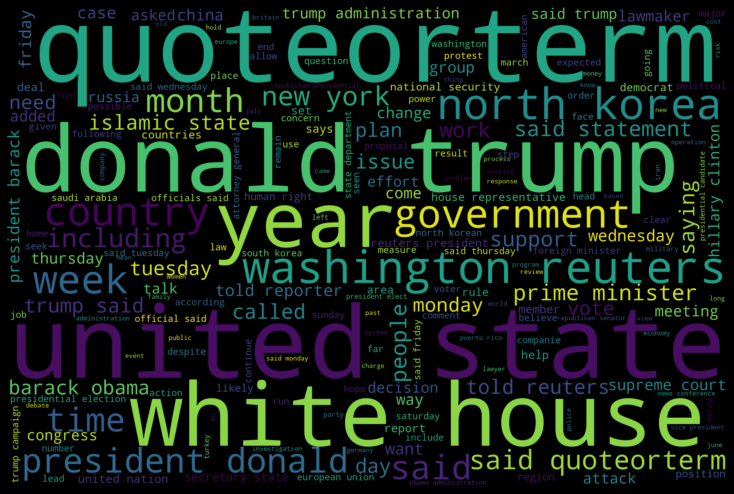

In [ ]:
create_word_cloud(text = " ".join(df_for_models_without_lemma[df_for_models_without_lemma.category == "real news"].Doc_clean_without_lemma))

## **Fake news world cloud - after data cleaning and preprocessing:**

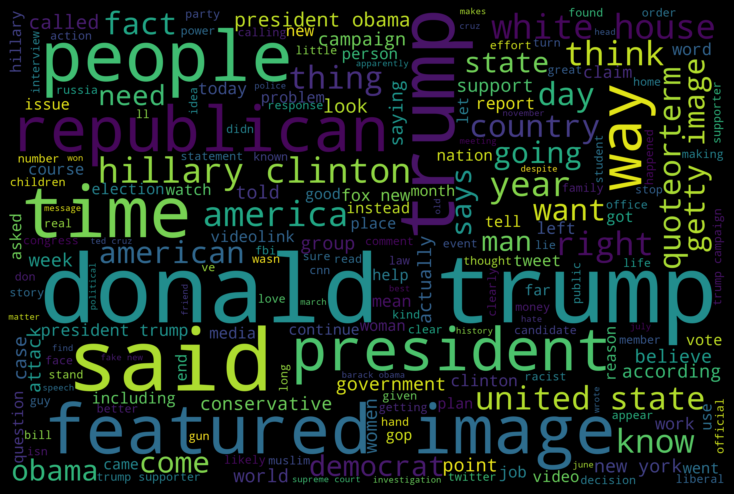

In [ ]:
create_word_cloud(text = " ".join(df_for_models_without_lemma[df_for_models_without_lemma.category == "fake news"].Doc_clean_without_lemma))

## **N-grams analysis:**

In [ ]:
all_news_clean_text = df_for_models_without_lemma.Doc_clean_without_lemma
real_news_clean_text = df_for_models_without_lemma[df_for_models_without_lemma.category == "real news"].Doc_clean_without_lemma
fake_news_clean_text = df_for_models_without_lemma[df_for_models_without_lemma.category == "fake news"].Doc_clean_without_lemma

In [ ]:
"""
CountVectorizer of sklearn.feature_extraction.text:
=> Converts a collection of text documents to a matrix of token counts.
=> If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection,
   then the number of features will be equal to the vocabulary size found by analyzing the data.
   Since we've already done tokenization and preprocessing with spaCy, we just set 'ngram_range' 
   that defines "what is a token: is it a single worde, pairs of words or more". 

'bag_of_words' - is document-term matrix (=matrix of token counts)
"""

# This method returns Top freaquent tokens in the given corpus:
def get_top_freaq_ngram_tokens (corpus, top_tokens_num = 20, ngrams_num = 1):

   # Create document-term matrix, and calculate the SUM of token counts for every column/token
    count_vec = CountVectorizer(ngram_range=(ngrams_num, ngrams_num))  #Convert a collection of text documents to a matrix of token counts.
    bag_of_words = count_vec.fit_transform(corpus)                     #Learn the vocabulary dictionary and return document-term matrix.
    words_sum = bag_of_words.sum(axis=0)                               # List of {sums of token counts} for every column/token. 

    # print(type(bag_of_words))  #  <class 'scipy.sparse.csr.csr_matrix'>
    # print(type(words_sum))    # <class 'numpy.matrix'>

   # Create list of tuples like (ngram_token, its_freaquency):
    words_freq = [(word, words_sum[0, idx]) for word, idx in count_vec.vocabulary_.items()] 
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    # print(type(words_freq)) #<class 'list'>
    # print(type(words_freq[0])) #<class 'tuple'>
    
    return words_freq[:top_tokens_num]

In [ ]:
def top_values_barplot (data_dict, title, xlabel_txt, ylabel_txt): 
  plt.figure(figsize = (10,5))
  plt.title(title)
  plt.xlabel(xlabel_txt)
  plt.ylabel(ylabel_txt)
  sns.barplot(x=list(data_dict.values()),y=list(data_dict.keys()))
  return 

### **Unigrams:**

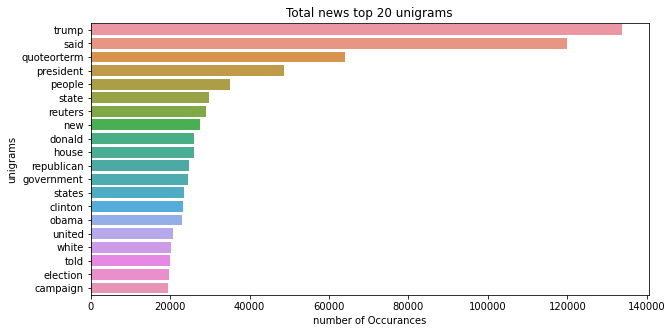

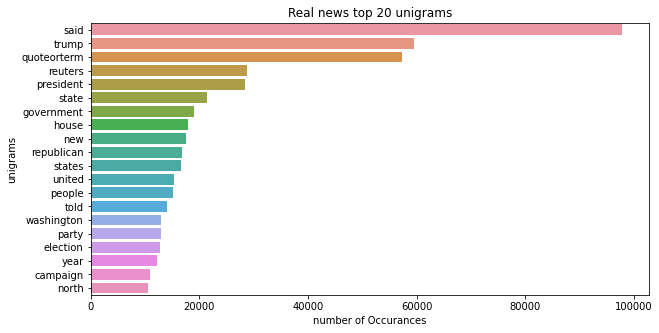

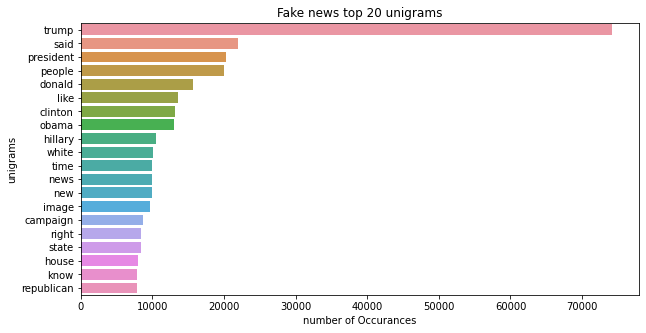

In [ ]:
# TOTAL NEWS:
# create dictionary from list of tuples:
most_common_unigrams_total_news = dict(get_top_freaq_ngram_tokens(corpus= all_news_clean_text, top_tokens_num= 20, ngrams_num= 1))
top_values_barplot (data_dict= most_common_unigrams_total_news  , title="Total news top 20 unigrams", \
                 xlabel_txt="number of Occurances", ylabel_txt="unigrams")

# REAL NEWS:
most_common_unigrams_real_news = dict(get_top_freaq_ngram_tokens(corpus= real_news_clean_text, top_tokens_num= 20, ngrams_num= 1))
top_values_barplot (data_dict= most_common_unigrams_real_news  , title="Real news top 20 unigrams", \
                 xlabel_txt="number of Occurances", ylabel_txt="unigrams")

# FAKE NEWS:
most_common_unigrams_fake_news = dict(get_top_freaq_ngram_tokens(corpus= fake_news_clean_text, top_tokens_num= 20, ngrams_num= 1))
top_values_barplot (data_dict= most_common_unigrams_fake_news  , title="Fake news top 20 unigrams", \
                 xlabel_txt="number of Occurances", ylabel_txt="unigrams")

### **Bigrams:**

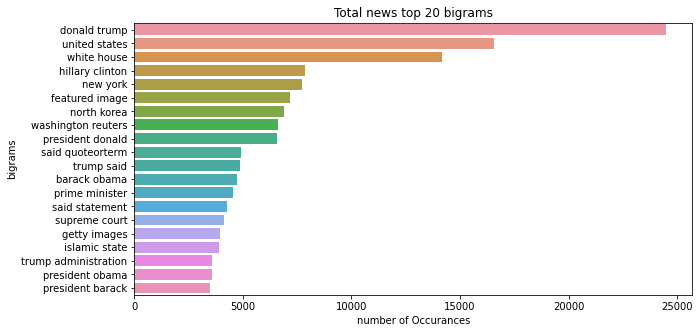

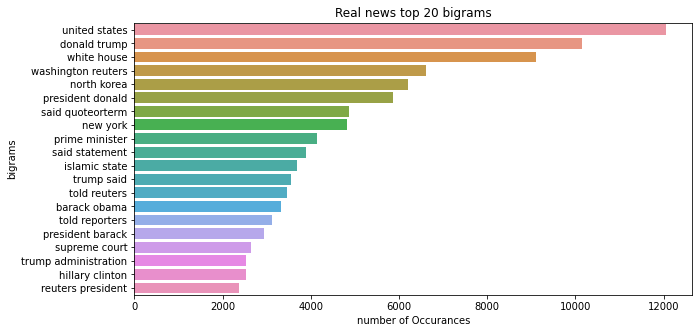

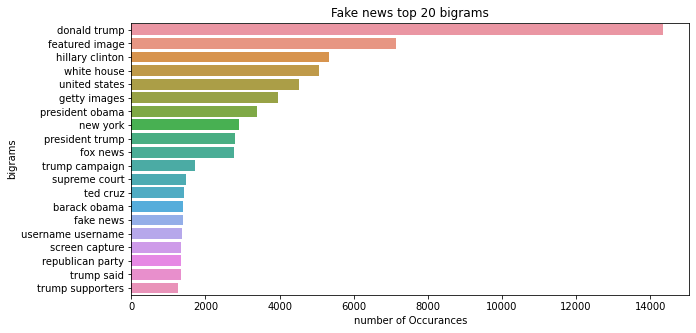

In [ ]:
# TOTAL NEWS:
# create dictionary from list of tuples:
most_common_bigrams_total_news = dict(get_top_freaq_ngram_tokens(corpus= all_news_clean_text, top_tokens_num= 20, ngrams_num= 2))
top_values_barplot (data_dict= most_common_bigrams_total_news  , title="Total news top 20 bigrams", \
                 xlabel_txt="number of Occurances", ylabel_txt="bigrams")

# REAL NEWS:
most_common_bigrams_real_news = dict(get_top_freaq_ngram_tokens(corpus= real_news_clean_text, top_tokens_num= 20, ngrams_num= 2))
top_values_barplot (data_dict= most_common_bigrams_real_news  , title="Real news top 20 bigrams", \
                 xlabel_txt="number of Occurances", ylabel_txt="bigrams")

# FAKE NEWS:
most_common_bigrams_fake_news = dict(get_top_freaq_ngram_tokens(corpus= fake_news_clean_text, top_tokens_num= 20, ngrams_num= 2))
top_values_barplot (data_dict= most_common_bigrams_fake_news  , title="Fake news top 20 bigrams", \
                 xlabel_txt="number of Occurances", ylabel_txt="bigrams")

### **Conclusions:**

*   Several unigrams & bigrams are the same for both labels (such as “said”, “president”, “donald trump”, “united states” & “white house”). We decided not to add them to stop words list since in BOW models they won’t be taken into consideration while vectorizing the words with TF- IDF and in deep learning methods we will use the sentences as sequences.
*   As seen before (in added marks analysis), the mark “quoteorterm” that we added appears more frequently in real news while the mark “username” that we added appears more frequently in fake news.
*   The unigram “Reuters” (an international news organization) appears frequently in real news, while the bigram “Fox news” (an American multinational conservative cable news television channel) appears frequently in fake news.
*   Topics such as “Islamic state” & “North Korea” appear frequently in real news.
*   The unigram “image” appears frequently in fake news.
*   The bigram “fake news” appears frequently in fake news.

## **Number of words in text analysis:**



### **Outliers detection:**

In [ ]:
df_for_models_without_lemma["num_words_in_text"] = df_for_models_without_lemma['Doc_clean_without_lemma'].str.split().map(lambda x: len(x))
df_for_models_without_lemma.sample(3)

category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text
14989  real news   taiwan tells want cause trouble taiwan strait taipei reuters taiwan assured united states intention causing trouble taiwan strait self ruled island envoy summit asia pacific leaders said monday comments james soong came told reporters vietnamese city danang weekend good exchanges president dona...                168
3185   fake news   internet obliterates trump whines photo cnn tweets president elect monday took issue photo cnn cover book election donald trump took twitter write username released book called unprecedented explores race victory hope worst cover photo username released book called unprecedented explores race v...                245
12731  fake news   busted latest woman accuse trump sexual advances recently emailed asking help trump latest accuser summer zervos contestant apprentice stood high profile lawyer hillary delegate gloria allred today read statement accusing trump inappropriate sexual behavior tonight trump responds telling voters...                 77

In [ ]:
df_for_models_with_lemma["num_words_in_text"] = df_for_models_with_lemma['Doc_clean_with_lemma'].str.split().map(lambda x: len(x))
df_for_models_with_lemma.sample(3)

category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma  num_words_in_text
6812  real news   retirement plan offer trump pick puzder shed light labor rule washington reuters fast food executive andy puzder president elect donald trump choice head labor department position undermine agency new rule retirement advice long oppose financial industry puzder publicly comment fiduciary rule e...                376
8124  real news   polling place battleground voting right fight lincoln park reuters louis brooks walk cast vote neighborhood polling place georgia predominantly black lincoln park neighborhood decade year brooks say vote presidential election time remember local official move polling station mile km away plan c...                670
8740  fake news   bill flee country sander elect president videolink fox news blowhard bill reilly doesn want future president bernie sanders surprise reilly obviously far right sander leave reilly take fear left winger president level fact say sander get will ireland recent edition reilly factor bloviate talkin...                138

#### **Distribution graphs definition:**

In [ ]:
# # Graph1: Distribution for categorical variables.
# # gridsize = num of points in the discrete grid used to compute the kernel density estimate.

def violin_plt_for_num_of_words_in_text_by_categ_for_single_df ( df, title, y_axis_txt, x_axis_txt='category', num_of_points = 1000 ):
    fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(12,6))
    fig.suptitle(' Distribution for number of words in text for dataframe ' + title)

    ax = sns.violinplot(x='category', y=y_axis_txt, data=df, gridsize=num_of_points, width = 1)

    plt.show()
    return  

# # Example:
# violin_plt_for_num_of_words_in_text_by_categ_for_single_df (df =df_for_models_without_lemma, \
#                                               title = " without lemmatization", \
#                                               y_axis_txt= 'num_words_in_text',  \
#                                               # x_axis_txt='category',    \
#                                               # num_of_points = 2000 \
#                                                 )

In [ ]:
# Graph1: Distribution for categorical variables.
def violin_plt_for_num_of_words_in_text_by_categ_for_2df ( y_axis_txt,  plt_title,  \
                                                          x_axis_txt='category', num_of_points = 50,  \
                                                          df1=df_for_models_without_lemma, df2=df_for_models_with_lemma, \
                                                          t1 = "WITHOUT lemmatization",  t2 = "WITH lemmatization" ):

    fig, ax = plt.subplots(1,1)
    fig.suptitle(plt_title + " " + t1 +":" )
    sns.violinplot(x=x_axis_txt, y=y_axis_txt, data=df1, gridsize=num_of_points, width = 1, \
                   order=["real news","fake news"],  \
                   palette=['c','tomato'])

    fig2, ax2 = plt.subplots(1,1)
    fig2.suptitle(plt_title + " " + t2 +":")
    sns.violinplot(x=x_axis_txt, y=y_axis_txt, data=df2, gridsize=num_of_points, width = 1, \
                   order=["real news","fake news"], \
                   palette=['c','tomato'])
    plt.show()
    return  

#---------------------------------------------------------------------------------------------
# Seaborn colors:
# https://python-graph-gallery.com/100-calling-a-color-with-seaborn/

#### **Histogram definition:**

In [ ]:
# Graph2: Histogram for number of words in texts for each category:

def hist_num_of_words_in_text_by_categ (df, x_col, y_col, title):
    # Create a new figure with 3 subplots with shatred y-axis:
    fig,(ax1,ax2, ax3)= plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)
    fig.suptitle(title)

    # Number of words in each text for REAL news:
    text_len1 = df[df[x_col]== "real news"][y_col]
    ax1.hist(text_len1, color='green')
    ax1.set_title('Real news')

    # Number of words in each text for FAKE news:
    text_len2 = df[df[x_col]== "fake news"][y_col]
    ax2.hist(text_len2,color='red')
    ax2.set_title('Fake news')

    # Number of words in each text for TOTAL news:
    text_len3 = df[y_col]
    ax3.hist(text_len3,color='blue')
    ax3.set_title('All news')

    plt.show()
    return

In [ ]:
def hist_num_of_words_in_text_by_categ_for_2df ( y_axis_txt, plt_title, \
                                                 x_axis_txt ='category', num_of_points = 1000,  \
                                                 df1=df_for_models_without_lemma, df2=df_for_models_with_lemma, \
                                                 t1 = "WITHOUT lemmativiolin",  t2 = "WITH lemmatization" ):

    hist_num_of_words_in_text_by_categ (df=df1, x_col =x_axis_txt, y_col=y_axis_txt, title = plt_title + " " + t1)
    print("\n")
    hist_num_of_words_in_text_by_categ (df=df2, x_col =x_axis_txt, y_col=y_axis_txt, title = plt_title + " " + t2)
    return  

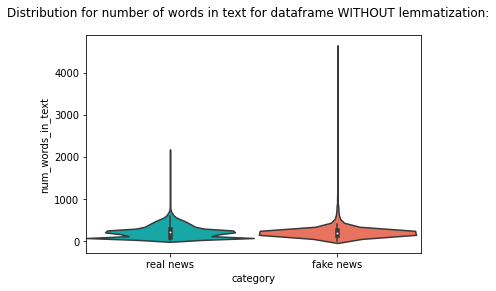

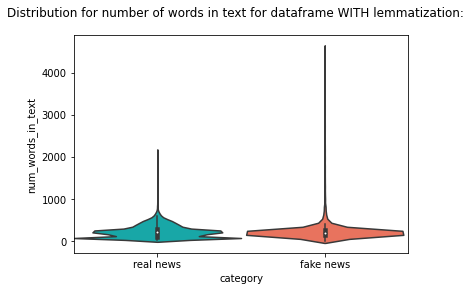

In [ ]:
violin_plt_for_num_of_words_in_text_by_categ_for_2df (y_axis_txt ='num_words_in_text', \
                                                      plt_title = 'Distribution for number of words in text for dataframe', )

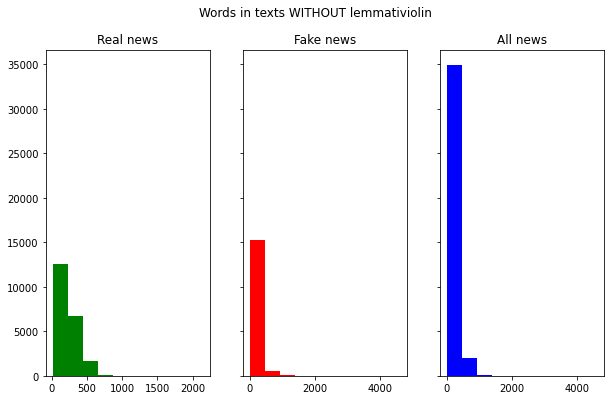

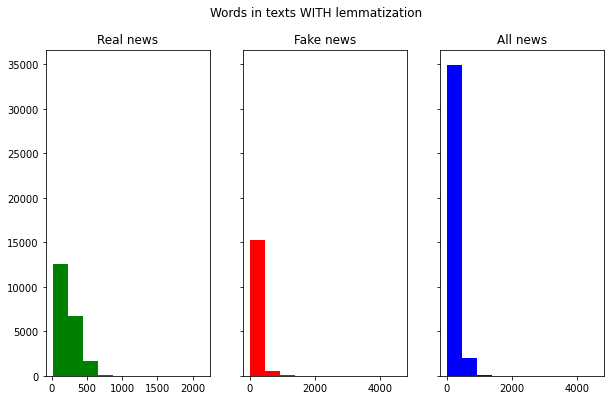

In [ ]:
hist_num_of_words_in_text_by_categ_for_2df(y_axis_txt ='num_words_in_text', plt_title = 'Words in texts') 

### **Conclusions:**

Samples with over 1,000 words in the text are outliers and should be dropped.


### **Drop outliers - samples with over 1,000 words in text:**

---



In [ ]:
print(df_for_models_without_lemma.shape)  # (37019, 3)

df_for_models_without_lemma = df_for_models_without_lemma [df_for_models_without_lemma['num_words_in_text'] < 1000]

print(df_for_models_without_lemma.shape)  # (36890, 3)

(37019, 3)
(36890, 3)


In [ ]:
print(df_for_models_with_lemma.shape)  # (37019, 3)

df_for_models_with_lemma = df_for_models_with_lemma [df_for_models_with_lemma['num_words_in_text'] < 1000]

print(df_for_models_with_lemma.shape)  # (36890, 3)

(37019, 3)
(36890, 3)


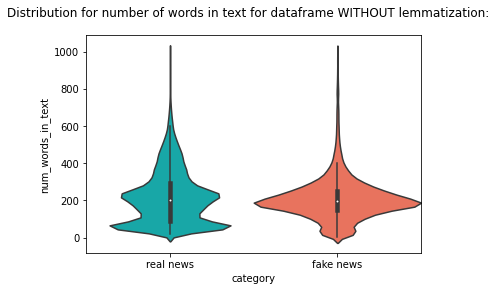

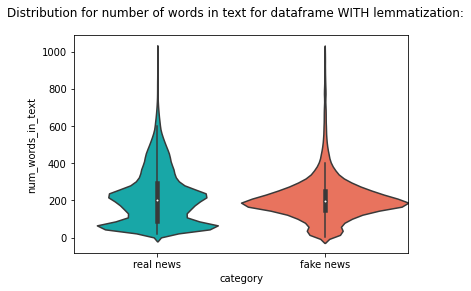

In [ ]:
violin_plt_for_num_of_words_in_text_by_categ_for_2df (y_axis_txt ='num_words_in_text', \
                                                      plt_title = 'Distribution for number of words in text for dataframe',
                                                      df1 = df_for_models_without_lemma,
                                                      df2 =df_for_models_with_lemma)

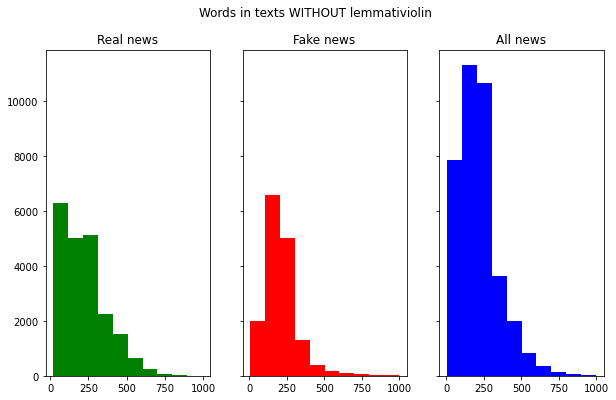

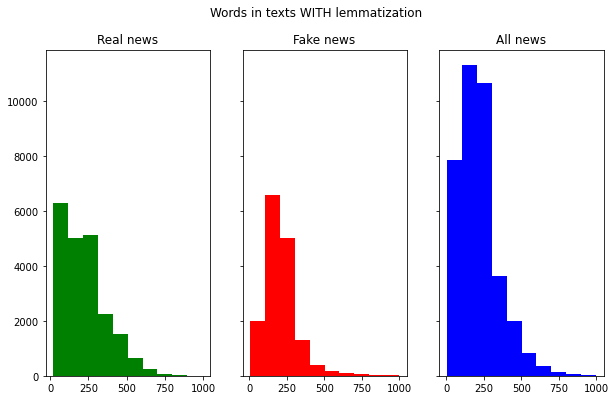

In [ ]:
hist_num_of_words_in_text_by_categ_for_2df(y_axis_txt ='num_words_in_text', plt_title = 'Words in texts',
                                           df1 = df_for_models_without_lemma,
                                           df2 =df_for_models_with_lemma) 

### **Conclusions:**

Unlike we thought before (that samples with over 10,000 words in the text are outliers), it seems that samples with over 7,000 words in the text are outliers and should be dropped.


### **Drop outliers - samples with over 7,000 words in text:**

In [ ]:
print(df_for_models_without_lemma.shape)  # (36890, 3)

df_for_models_without_lemma = df_for_models_without_lemma [df_for_models_without_lemma['num_words_in_text'] < 700]

print(df_for_models_without_lemma.shape)  # (36674, 3)

(36890, 3)
(36674, 3)


In [ ]:
print(df_for_models_with_lemma.shape)  # (36884, 3)

df_for_models_with_lemma = df_for_models_with_lemma [df_for_models_with_lemma['num_words_in_text'] < 700]

print(df_for_models_with_lemma.shape)  # (36674, 3)

(36890, 3)
(36674, 3)


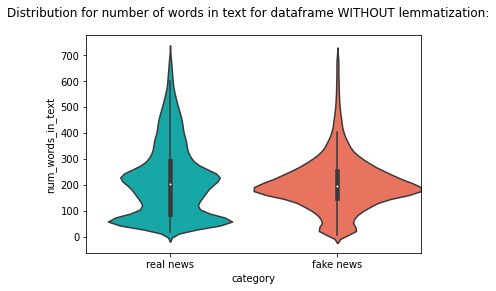

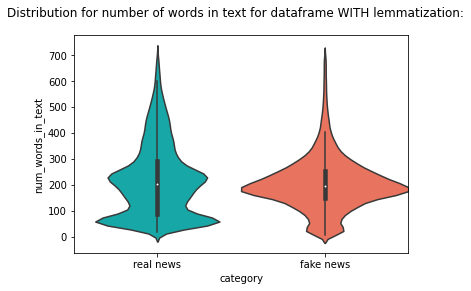

In [ ]:
violin_plt_for_num_of_words_in_text_by_categ_for_2df (y_axis_txt ='num_words_in_text', \
                                                      plt_title = 'Distribution for number of words in text for dataframe',
                                                      df1 = df_for_models_without_lemma,
                                                      df2 =df_for_models_with_lemma)

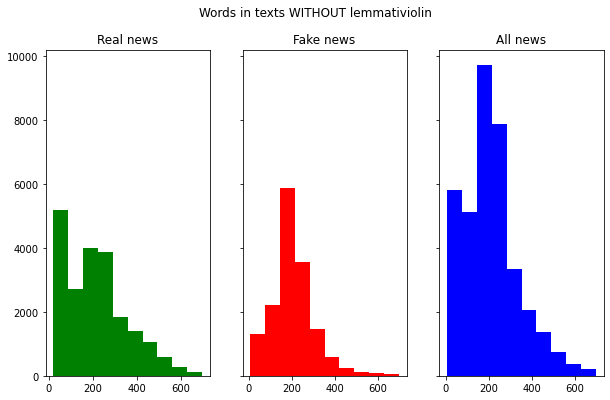

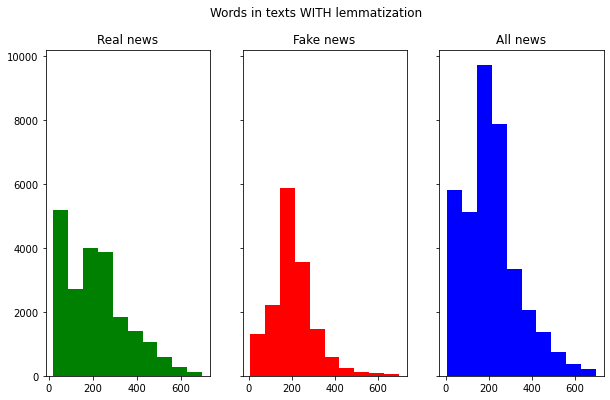

In [ ]:
hist_num_of_words_in_text_by_categ_for_2df(y_axis_txt ='num_words_in_text', plt_title = 'Words in texts',
                                           df1 = df_for_models_without_lemma,
                                           df2 =df_for_models_with_lemma) 

## **Number of characters in text:**

In [ ]:
df_for_models_without_lemma["num_chars_in_text"] = df_for_models_without_lemma['Doc_clean_without_lemma'].str.len()
df_for_models_without_lemma.sample(3)

category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text
3581  real news   republican congressional candidate montana cited assaulting reporter missoula reuters montana republican congressional candidate greg gianforte cited misdemeanor wednesday reporter accused physical assault eve special election fill state lone seat house representatives gallatin county sheriff o...                420               3278
1885  fake news   reporter reveals real reason trump fired bannon wh post petty hell videolink news trump closest advisor steve bannon ousted position national security council reinforced disturbing chaos happening white house people fired abruptly people resign abruptly reasons obscured mountain lies bannon cas...                260               1877
9111  fake news   sarah sanders time videolink sarah sanders great getting white house press corps hurry supercut shows tactics superstar wild press line time favorites rare occasion sarah wasn finished sarah huckabee sanders hot today went cnn jim acosta fake news constant past days jim acosta quiet sanders lou...                176               1291

In [ ]:
df_for_models_with_lemma["num_chars_in_text"] = df_for_models_with_lemma['Doc_clean_with_lemma'].str.len()
df_for_models_with_lemma.sample(3)

category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma  num_words_in_text  num_chars_in_text
10942  real news   struggle republican bush bring big gun mom manchester reuters jeb bush bring famous family day crucial presidential primary new hampshire tap mother friday scold republican runner donald trump use profanity treatment woman ditch attempt mark republican primary campaign suppose bush lash trump s...                508               3586
10150  real news   virginia governor veto bill cut planned parenthood funding reuters virginia governor terry mcauliffe tuesday veto republican back bill aim block state funding planned parenthood perform abortion provide health service mcauliffe democrat say bill pass republican dominate legislature harm thousan...                100                753
784    fake news   nsa chief trump russia cybersecurity unit plan terrible idea doesn rocket scientist know have russia cybersecurity unit backwards moronic idea administration come exactly donald trump encourage trump introduce idea earlier month russia work united states cybersecurity russia interfere election ...                200               1513

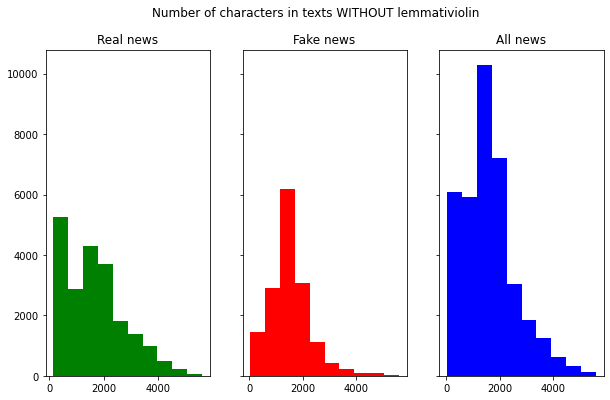

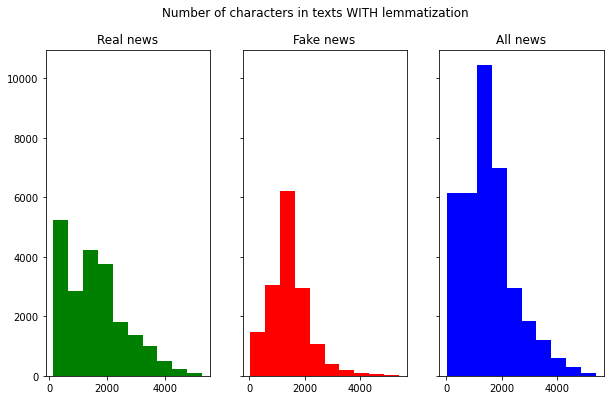

In [ ]:
hist_num_of_words_in_text_by_categ_for_2df(y_axis_txt ="num_chars_in_text", plt_title = "Number of characters in texts",
                                           df1 = df_for_models_without_lemma, df2 =df_for_models_with_lemma)

## **Average word length in text:**

In [ ]:
df_for_models_without_lemma["avg_word_len_in_text"] = df_for_models_without_lemma['Doc_clean_without_lemma']\
                            .str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
df_for_models_without_lemma.sample(3)

category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
11051  real news   california senators seek methane leak task force energy bill washington reuters senators representing california said friday propose federal task force investigate cause response massive natural gas leak near los angeles democratic senators barbara boxer dianne feinstein announced introduce ame...                221               1708                6.7285
9111   fake news   sarah sanders time videolink sarah sanders great getting white house press corps hurry supercut shows tactics superstar wild press line time favorites rare occasion sarah wasn finished sarah huckabee sanders hot today went cnn jim acosta fake news constant past days jim acosta quiet sanders lou...                176               1291                6.3352
22035  fake news   sunday screening quoteorterm war democracy century wire says week curate series informative documentary films designed educate enlighten readers key issues facing people worldwide war democracy award winning australian filmmaker john pilger intimate film creations film pilger takes inside look ...                 97                736                6.5876

In [ ]:
df_for_models_with_lemma["avg_word_len_in_text"] = df_for_models_with_lemma['Doc_clean_with_lemma']\
                        .str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
df_for_models_with_lemma.sample(3)

category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
13212  fake news                                                                 obama flashback hear obama say taking vacations elect videolink probably guess give line total bs vacation elect bargain president strike office turn fear doubt insecurity foible need sleep family life vacation leisure go obama say give                 36                237                5.5833
1138   real news   mattis say complete accurate information niger ambush washington reuters defense secretary jim mattis say thursday military accurate information ambush niger earlier month kill soldier quoteorterm loss troop investigation mattis say meeting israeli counterpart pentagon quoteorterm department de...                 47                374                6.9574
918    fake news   trump team incompetent book hotel room summit donald trump promise surround good people team couldn manage book hotel room summit end have beg city hamburg night government own housing buzzfeed news report white house official apparently wait long book accommodation president trump leave hotel ...                167               1143                5.8443

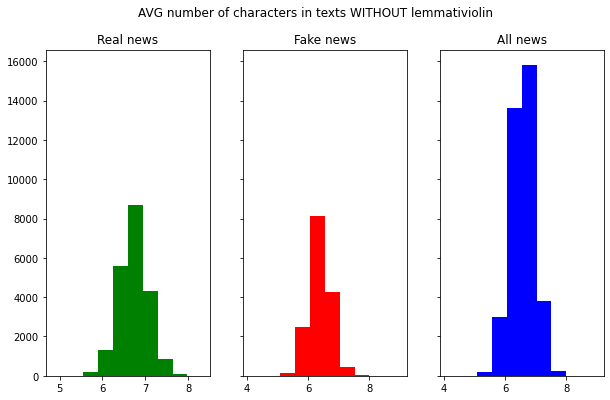

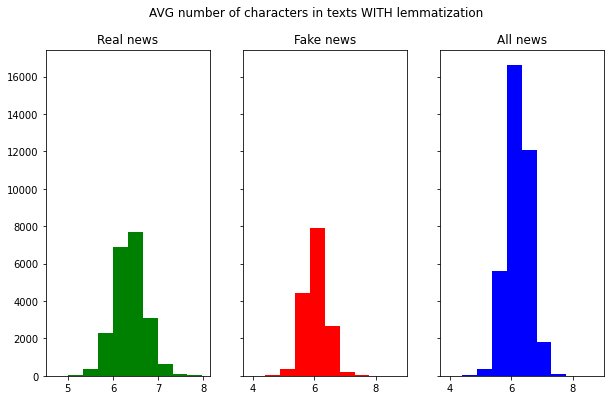

In [ ]:
hist_num_of_words_in_text_by_categ_for_2df(y_axis_txt ="avg_word_len_in_text", plt_title = "AVG number of characters in texts",
                                           df1 = df_for_models_without_lemma, df2 =df_for_models_with_lemma) 

Text(0.5, 0.98, 'Average word length in each text')

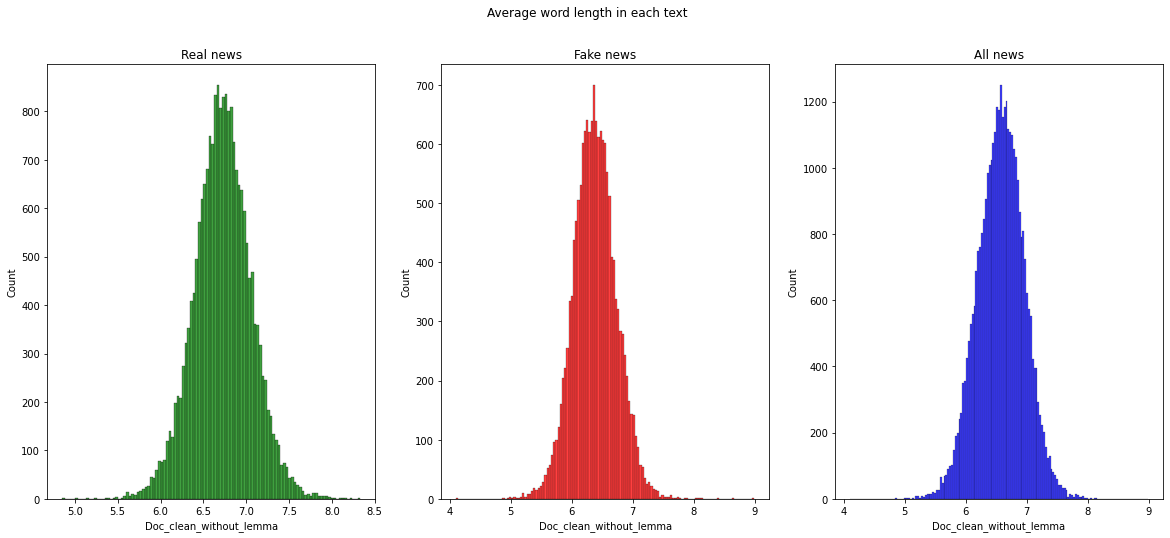

In [ ]:
# Average word length in a text
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(20,8))
word = df_for_models_without_lemma[df_for_models_without_lemma['category']== "real news"]['Doc_clean_without_lemma'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Real news')
word = df_for_models_without_lemma[df_for_models_without_lemma['category']== "fake news"]['Doc_clean_without_lemma'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Fake news')
word = df_for_models_without_lemma['Doc_clean_without_lemma'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax3,color='blue')
ax3.set_title('All news')
fig.suptitle('Average word length in each text')

## **“num_words_in_text”, “num_chars_in_text” & “avg_word_len_in_text” analysis - DF without lemmatization:**

### **All news:**

In [ ]:
df_for_models_without_lemma.describe().T

count       mean       std   min      25%        50%        75%        max
num_words_in_text     36674.0   211.1717  125.4777   5.0  122.000   198.0000   268.0000   699.0000
num_chars_in_text     36674.0  1604.8725  968.7345  31.0  919.000  1487.0000  2040.0000  5612.0000
avg_word_len_in_text  36674.0     6.5782    0.3839   4.1    6.324     6.5845     6.8356     8.9912

### **Real news:**

In [ ]:
df_for_models_without_lemma[df_for_models_without_lemma["category"] == "real news"].describe().T

count       mean        std     min       25%        50%        75%        max
num_words_in_text     21101.0   215.8581   140.2913   19.00   88.0000   203.0000   292.0000   699.0000
num_chars_in_text     21101.0  1669.2658  1087.0063  132.00  680.0000  1569.0000  2251.0000  5610.0000
avg_word_len_in_text  21101.0     6.7251     0.3355    4.85    6.5103     6.7247     6.9416     8.3333

### **Fake news:**

In [ ]:
df_for_models_without_lemma[df_for_models_without_lemma["category"] == "fake news"].describe().T

count       mean       std   min        25%        50%        75%        max
num_words_in_text     15573.0   204.8219  101.6906   5.0   150.0000   194.0000   251.0000   699.0000
num_chars_in_text     15573.0  1517.6214  771.8980  31.0  1093.0000  1430.0000  1861.0000  5612.0000
avg_word_len_in_text  15573.0     6.3791    0.3545   4.1     6.1483     6.3721     6.6026     8.9912

## **“num_words_in_text”, “num_chars_in_text” & “avg_word_len_in_text” analysis - DF with lemmatization:**

### **All news:**

In [ ]:
df_for_models_with_lemma.describe().T

count       mean       std   min       25%        50%        75%        max
num_words_in_text     36674.0   211.1717  125.4777   5.0  122.0000   198.0000   268.0000   699.0000
num_chars_in_text     36674.0  1526.8094  920.3113  31.0  874.0000  1415.0000  1939.0000  5405.0000
avg_word_len_in_text  36674.0     6.2220    0.3807   3.9    5.9647     6.2234     6.4732     8.7743

### **Real news:**

In [ ]:
df_for_models_with_lemma[df_for_models_with_lemma["category"] == "real news"].describe().T

count       mean        std      min       25%        50%        75%       max
num_words_in_text     21101.0   215.8581   140.2913   19.000   88.0000   203.0000   292.0000   699.000
num_chars_in_text     21101.0  1588.1191  1032.3816  128.000  649.0000  1490.0000  2137.0000  5301.000
avg_word_len_in_text  21101.0     6.3647     0.3364    4.675    6.1455     6.3596     6.5753     7.975

### **Fake news:**

In [ ]:
df_for_models_with_lemma[df_for_models_with_lemma["category"] == "fake news"].describe().T

count       mean       std   min        25%        50%      75%        max
num_words_in_text     15573.0   204.8219  101.6906   5.0   150.0000   194.0000   251.00   699.0000
num_chars_in_text     15573.0  1443.7363  733.8299  31.0  1040.0000  1361.0000  1767.00  5405.0000
avg_word_len_in_text  15573.0     6.0288    0.3507   3.9     5.7964     6.0139     6.25     8.7743

### **Conclusions for DF without lemmatization:**

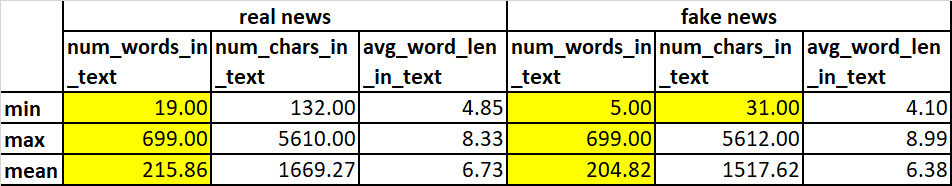

*   Mean “num_words_in_text”, “num_chars_in_text” & “avg_word_len_in_text” are all higher in real news.
*   Min “num_words_in_text” & “num_chars_in_text” are smaller in fake news while max “num_words_in_text” & “num_chars_in_text” are similar in both labels.

### **Conclusions for DF with lemmatization:**

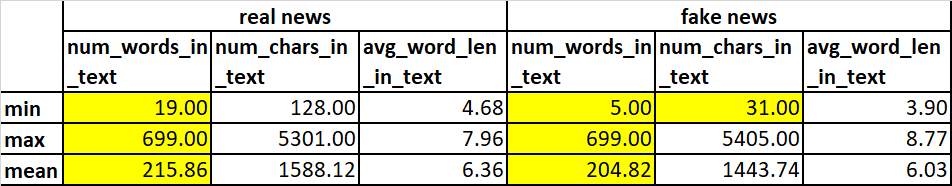

Min, max & mean “num_words_in_text” remained the same while min, max & mean for “num_chars_in_text” & “avg_word_len_in_text” are smaller – since we used lemmatization that makes sense.

## **Target variable - "category" column - rechecking value counts (balance) after preprocessing, data cleaning & removing outliers:**

In [ ]:
print(df_for_models_without_lemma.category.value_counts(),"\n")
print(df_for_models_without_lemma.category.value_counts(normalize = True))

real news    21101
fake news    15573
Name: category, dtype: int64 

real news    0.5754
fake news    0.4246
Name: category, dtype: float64


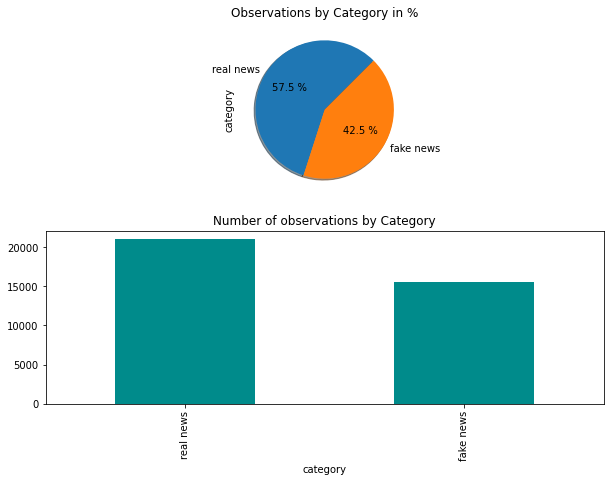

In [ ]:
f,ax = plt.subplots(2,1, figsize=(10,7))

ax[0] = df_for_models_without_lemma.category.value_counts().plot.pie(autopct='%.1f %%',ax = ax[0], shadow=True, startangle=45)
ax[0].set_title('Observations by Category in %')

ax[1] = df_for_models_without_lemma.category.value_counts().plot.bar(color="darkcyan")
ax[1].set_title("Number of observations by Category")
ax[1].set_xlabel("category")

plt.show()

### **Conclusions:**

The data is still balanced.

### **Save df_for_models_with_lemma in a new CSV file (after shuffling):**

In [ ]:
df_for_models_with_lemma = shuffle(df_for_models_with_lemma)
df_for_models_with_lemma = df_for_models_with_lemma.reset_index(drop=True)

In [ ]:
df_for_models_with_lemma.sample(2)

category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
5921   real news   trump speak leader afghanistan singapore reuters president elect donald trump speak phone friday afghan president ashraf ghani trump transition team say statement quoteorterm man discuss grave terrorism threat face country pledge work closely order meet grow threat statement say trump speak fri...                 63                460                6.3016
11093  real news   china warn livestreame quoteorterm rooftopper fall death beijing reuters young chinese climbing enthusiast fatal fall skyscraper make selfie video rooftopping dare spur warning state medium peril livestreame wu yongning plunge death building central china day stop post video skyscraper exploit ...                159               1124                6.0692

In [ ]:
df_for_models_with_lemma.to_csv("final_clean_text_spacy_with_lemmma.csv")

### **Save df_for_models_without_lemma in a new CSV file (after shuffling):**

In [ ]:
df_for_models_without_lemma = shuffle(df_for_models_without_lemma)
df_for_models_without_lemma = df_for_models_without_lemma.reset_index(drop=True)

In [ ]:
df_for_models_without_lemma.sample(2)

category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
8816   real news   russia impose counter measures new sanctions foreign ministry moscow reuters russia impose counter measures united states president donald trump signed law new round economic sanctions moscow russian foreign ministry said wednesday new penalties short sighted risked harming global stability sai...                 58                442                6.6207
19572  real news                                                                                                 south korea moon says war korean peninsula vladivostok russia reuters south korean president moon jae said thursday war korea peninsula tensions risen considerably north korea latest nuclear test week ago                 30                205                5.8333

In [ ]:
df_for_models_without_lemma.to_csv("final_clean_text_spacy_without_lemmma.csv")

# **Additional analysis with spaCy - Named Entities:**

## **Read file - to Extract Named Entities:**

In [53]:
df_for_models_with_lemma_NE = pd.read_csv("final_clean_text_spacy_with_lemmma.csv", index_col=0)
print(df_for_models_with_lemma_NE.shape)   #(36646, 5)
df_for_models_with_lemma_NE.head(2)

(36646, 5)


category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
0  fake news   cnn brutally dismantle ted cruz knowingly lie reporting videolink certainty life grass green water wet place electric eel bathwater climb result positive ted cruz liar recently cruz play trick dirty send campaign mailer falsely accuse iowans voting violation feature datum campaign completely co...                456               3013                5.6075
1  fake news   watch black trump supporter blast city council quoteorterm racist sanctuary cities spectacular unidentified black trump supporter blast cudahy city council member objection racist sanctuary city argument base belief sanctuary city offer certain protection benefit offer legal american citizen wa...                366               3035                7.2923

## **Create spaCy's 'Doc' object from clean text with lemmas:**

In [54]:
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS   # type(STOP_WORDS) => set
import en_core_web_sm

nlp = en_core_web_sm.load()
# nlp = spacy.load("en_core_web_sm")

In [ ]:
df_for_models_with_lemma_NE ['Doc_obj_for_NE_low'] = [nlp(text) for text in df_for_models_with_lemma_NE['Doc_clean_with_lemma']]
df_for_models_with_lemma_NE.sample(3)

category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text                                                                                                                                                                                                                                                                                           Doc_obj_for_NE_low
28690  real news   turkey detain teacher post coup probe anadolu ankara reuters turkish authority issue detention warrant friday teacher state run anadolu news agency say widen crackdown year fail coup attempt teacher employ school allegedly link cleric fethullah gulen accuse ankara orchestrate july abortive puts...                127                910                6.1654  ( , turkey, detain, teacher, post, coup, probe, anadolu, ankara, reuters, turkish, authority, issue, detention, warrant, friday, teacher, state, run, anadolu, news, agency, say, widen, crackdown, year, fail, coup, attempt, teacher, employ, school, allegedly, link, cleric, fethullah, gulen, accus...
6586   real news   supporter south korea ex leader park ask body probe detention condition seoul reuters supporter south korean president park geun hye ask united nations body investigate detention corruption trial prevent park get proper medical treatment barrister say tuesday park oust earlier year detention ma...                231               1650                6.1429  ( , supporter, south, korea, ex, leader, park, ask, body, probe, detention, condition, seoul, reuters, supporter, south, korean, president, park, geun, hye, ask, united, nations, body, investigate, detention, corruption, trial, prevent, park, get, proper, medical, treatment, barrister, say, tues...
15775  real news   trump interior dept pick win senate confirmation washington reuters senate wednesday confirm president donald trump pick head interior department white house seek increase fossil fuel production federal land ryan zinke representative coal produce montana win confirmation vote democrats join rep...                202               1507                6.4604  ( , trump, interior, dept, pick, win, senate, confirmation, washington, reuters, senate, wednesday, confirm, president, donald, trump, pick, head, interior, department, white, house, seek, increase, fossil, fuel, production, federal, land, ryan, zinke, representative, coal, produce, montana, win...

In [ ]:
print(df_for_models_with_lemma_NE.columns)
print(df_for_models_with_lemma_NE.shape)   #(36674, 6)
print(df_for_models_with_lemma_NE.head(1))

Index(['category', 'Doc_clean_with_lemma', 'num_words_in_text', 'num_chars_in_text', 'avg_word_len_in_text', 'Doc_obj_for_NE_low'], dtype='object')
(36674, 6)
    category                                                     Doc_clean_with_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text                                                                    Doc_obj_for_NE_low
0  fake news   delusional obama divide america civil war videolink turn divide people                 10                 71                   6.1  ( , delusional, obama, divide, america, civil, war, videolink, turn, divide, people)


## **Named Entity Recognition (works with "en_core_web_sm" only):**
Named entities are “real world objects” that are assigned a name — for example, a person, an organization or a country.

https://spacy.io/api/annotation#named-entities

In [ ]:
def get_named_entities(doc):
  named_entities_list = []
  for ent in doc.ents:
    named_entities_list.append( (ent.text, ent.label_) )  
  return set(named_entities_list)  # return Unique NE-s

In [ ]:
# For every observation - get NE:
df_for_models_with_lemma_NE['NE_from_clean_lemma_doc'] = df_for_models_with_lemma_NE['Doc_obj_for_NE_low'].map(lambda curr_doc: get_named_entities(doc=curr_doc))

In [ ]:
 df_for_models_with_lemma_NE['NE_not_unique_NUM'] = df_for_models_with_lemma_NE['NE_from_clean_lemma_doc'].map(lambda s: len(s))

In [ ]:
print(df_for_models_with_lemma_NE.columns)
print(df_for_models_with_lemma_NE.shape)   #(36674, 7)
print(df_for_models_with_lemma_NE.head(2))

Index(['category', 'Doc_clean_with_lemma', 'Doc_obj_for_NE_low', 'NE_from_clean_lemma_doc', 'NE_not_unique_NUM', 'Unique_NE_from_clean_lemma_doc', 'NE_Unique_NUM'], dtype='object')
(36674, 7)
    category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma                                                                                                                                                                                                                                                                                           Doc_obj_for_NE_low                                                                                                                                                                                                  

### **Check if there are unique/non-unique NE:**

#### **Get number of non-unique NE in each text:**

In [ ]:
df_temp = df_for_models_with_lemma_NE [df_for_models_with_lemma_NE['NE_from_clean_lemma_doc'].notnull()]
print( df_temp.shape)   #(36674, 7) 

(36674, 7)


#### **Get number of Unique NE in each text:**

In [ ]:
df_for_models_with_lemma_NE["Unique_NE_from_clean_lemma_doc"] =  df_for_models_with_lemma_NE['NE_from_clean_lemma_doc'].map(lambda x: set(x) )
df_for_models_with_lemma_NE["NE_Unique_NUM"] = df_for_models_with_lemma_NE['Unique_NE_from_clean_lemma_doc'].map(lambda s: len(s) )

df_temp = df_for_models_with_lemma_NE[df_for_models_with_lemma_NE["NE_Unique_NUM"] < df_for_models_with_lemma_NE['NE_not_unique_NUM']]
print(df_temp [['NE_not_unique_NUM', 'NE_Unique_NUM']].head(4) )

Empty DataFrame
Columns: [NE_not_unique_NUM, NE_Unique_NUM]
Index: []


#### **Conclusions:** 

* Every observation in dataset contains NE.
* All Named Entities are unique (because we created them from spaCy-Doc with clean lemmas).

#### Reorder columns and Drop those we don't need:

In [ ]:
print(df_for_models_with_lemma_NE.columns)
print(df_for_models_with_lemma_NE.shape)   #(36674, 8)

Index(['category', 'Doc_clean_with_lemma', 'Doc_obj_for_NE_low', 'NE_from_clean_lemma_doc', 'NE_not_unique_NUM', 'Unique_NE_from_clean_lemma_doc', 'NE_Unique_NUM'], dtype='object')
(36674, 7)


In [ ]:
df_for_models_with_lemma_NE.drop(columns=["Doc_clean_with_lemma", "NE_Unique_NUM",  \
                                          "Unique_NE_from_clean_lemma_doc", "NE_Unique_NUM",
                                          "num_words_in_text", "num_chars_in_text", "avg_word_len_in_text"], inplace=True)

In [ ]:
print(df_for_models_with_lemma_NE.columns)
print(df_for_models_with_lemma_NE.shape)   #(36674, 4)
print(df_for_models_with_lemma_NE.sample(3))

Index(['category', 'Doc_obj_for_NE_low', 'NE_from_clean_lemma_doc', 'NE_not_unique_NUM'], dtype='object')
(36674, 4)
        category                                                                                                                                                                                                                                                                                           Doc_obj_for_NE_low                                                                                                                                                                                                                                                                                      NE_from_clean_lemma_doc  NE_not_unique_NUM
30282  fake news  ( , funny, quoteorterm, morons, crooked, hillary, frighten, american, video, easy, americans, head, firmly, bury, sand, know, truth, inept, government, official, hillary, clinton, face, damage, new, revelation, lax, security, s

In [ ]:
# Rename columns:
df_for_models_with_lemma_NE.rename(columns={'Doc_obj_for_NE_low'      : 'Tokens_from_clean_lemmas',  \
                                            'NE_from_clean_lemma_doc' : 'Named_Entities',    \
                                            'NE_not_unique_NUM'       : 'Num_of_NEs'       \
                                            }                          
                                      ,inplace=True)

In [ ]:
print(df_for_models_with_lemma_NE.columns)

Index(['category', 'Tokens_from_clean_lemmas', 'Named_Entities', 'Num_of_NEs'], dtype='object')


In [ ]:
# Reorder columns:
df_for_models_with_lemma_NE = df_for_models_with_lemma_NE[[ 'category', 'Num_of_NEs', 'Named_Entities', 'Tokens_from_clean_lemmas' ]]

In [ ]:
df_for_models_with_lemma_NE.head(2)

category  Num_of_NEs                                                                                                                                                                                                                                    Named_Entities                                                                                                                                                                                                                                                                                     Tokens_from_clean_lemmas
0  fake news           1                                                                                                                                                                                                                                  {(america, GPE)}                                                                                                                                                                                                                         ( , delusional, obama, divide, america, civil, war, videolink, turn, divide, people)
1  fake news          12  {(cnn, ORG), (soda calorie, PRODUCT), (invite board, ORG), (brooke baldwin, PERSON), (dozen, CARDINAL), (diet coke, PRODUCT), (afternoon, TIME), (day, DATE), (donald trump, PERSON), (monday, DATE), (new york times, ORG), (white house, ORG)}  ( , cnn, demonstration, backfires, trump, drink, diet, cokes, day, quoteorterm, super, crazy, harmful, videolink, care, president, drink, cnn, think, think, great, idea, bring, doctor, tell, horrible, trump, drink, lot, diet, coke, think, wrong, backfire, brooke, baldwin, close, brooke, baldwin,...

### **Save dataframe with Named Entities to CSV file:**

In [ ]:
df_for_models_with_lemma_NE.to_csv('Named_Entities_final.csv') 

## **Analyzing Named Entities:**

### **Read file with Named Entities (which was created from clean lemmas) for analyzing:**

In [55]:
df_NE_from_clean_lemmas = pd.read_csv("Named_Entities_final.csv", index_col=0)
df_NE_from_clean_lemmas.head(2)

category  Num_of_NEs                                                                                                                                                                                                                                                                                    Named_Entities                                                                                                                                                                                                                                                                                     Tokens_from_clean_lemmas
0  fake news           1                                                                                                                                                                                                                                                                              {('america', 'GPE')}                                                                                                                                                                                                                                       delusional obama divide america civil war videolink turn divide people
1  fake news          12  {('cnn', 'ORG'), ('soda calorie', 'PRODUCT'), ('invite board', 'ORG'), ('brooke baldwin', 'PERSON'), ('dozen', 'CARDINAL'), ('diet coke', 'PRODUCT'), ('afternoon', 'TIME'), ('day', 'DATE'), ('donald trump', 'PERSON'), ('monday', 'DATE'), ('new york times', 'ORG'), ('white house', 'ORG')}   cnn demonstration backfires trump drink diet cokes day quoteorterm super crazy harmful videolink care president drink cnn think think great idea bring doctor tell horrible trump drink lot diet coke think wrong backfire brooke baldwin close brooke baldwin cnn program monday afternoon invite boar...

In [56]:
df_temp = df_NE_from_clean_lemmas [df_NE_from_clean_lemmas['Named_Entities'].notnull()]
print(df_temp.shape)                    #(36674, 4)
print(df_NE_from_clean_lemmas.shape)    #(36674, 4)

(36674, 4)
(36674, 4)


#### **Conclusion:** 

Every observation includes Named entities!

### **Create NE-dataframes for Real and Fake news:**

In [57]:
# Convert str to list of tuples:
def str2tupleList(s):
    temp = eval( "[%s]" % s )
    return temp[0]

In [58]:
# Convert String to List of tuples that contains strings:
df_NE_from_clean_lemmas['Named_Entities'] = df_NE_from_clean_lemmas['Named_Entities'].apply(lambda x: str2tupleList(x) )

# Create dataframes for real and fake news:
df_real_news = df_NE_from_clean_lemmas[df_NE_from_clean_lemmas["category"] == "real news"]
df_fake_news = df_NE_from_clean_lemmas[df_NE_from_clean_lemmas["category"] == "fake news"]

### **Define dictionaries:**
*  real_ne_types_count_dict / fake_ne_types_count_dict  => number of each NE-type in Real/Fake news
*  real_ne_values_dict / fake_ne_values_dict => (nested dictionaries)
=> For each Type of NE it will contain all it's Values and their count in Real /Fake news

In [59]:
# NESTED Dictionaries:  

def fill_ne_dict(ne_tuple_list, real_ne_types, fake_ne_types,  \
                                real_ne_vals, fake_ne_vals,  real=False, fake=False):

    if ((ne_tuple_list is None) or ( real == False and fake == False) or ( real == True and fake == True)) :
        return
    
    if(real):
        for t in ne_tuple_list:
            if (t is None):
                print("ERROR!! => tuple is NULL", t)
                break
            if (t[1] not in real_ne_types.keys()):
                # print ("ERROR!! => ADD '", t[1], "' TO NE-DICTIONARY")
                ne_oter_types_keys.add(t[1])
                break
            if ((t[0] == "quoteorterm") or (t[0]== "username") \
                or (t[0]=="don") or (t[0]=="didn") or (t[0]=="isn") \
                or (t[0]=="havn") or (t[0]=="weren") or (t[0]=="wasn")  ):  # ignore spesial marks
                # print("!!!!", t[0])
                break

            # 1-Update count of NE's type:
            real_ne_types[t[1]] = real_ne_types[t[1]] + 1

            # 2-Update Values for each NE's type:
            if (real_ne_vals[t[1]] == {}):  # add the first nested dict
                real_ne_vals[t[1]] = {t[0]: 1}
            elif (t[0] in real_ne_vals[t[1]].keys()):  # existing key in existing nested dict
                real_ne_vals[t[1]][t[0]] = real_ne_vals[t[1]][t[0]] + 1
            else:  # new key in existing nested dict
                real_ne_vals[t[1]][t[0]] = 1

    elif(fake):
        for t in ne_tuple_list:
            if (t is None):
                print("ERROR!! => tuple is NULL", t)
                break
            if ( t[1] not in fake_ne_types.keys()):
                # print ("ERROR!! => ADD '", t[1], "' TO NE-DICTIONARY")
                ne_oter_types_keys.add(t[1])
                break      
            if ((t[0] == "quoteorterm") or (t[0]== "username") \
                or (t[0]=="don") or (t[0]=="didn") or (t[0]=="isn") \
                or (t[0]=="havn") or (t[0]=="weren") or (t[0]=="wasn")  ):  # ignore spesial marks
                # print("!!!!", t[0])
                break

            # 1-Update count of NE's type:
            fake_ne_types[t[1]] = fake_ne_types[t[1]]+1

            # 2-Update Values for each NE's type:
            if (fake_ne_vals[t[1]] == {}):               # add the first nested dict
                fake_ne_vals[t[1]] = { t[0] : 1 }
            elif ( t[0] in fake_ne_vals[t[1]].keys()):    # existing key in existing nested dict
                fake_ne_vals[t[1]][t[0]] = fake_ne_vals[t[1]][t[0]] + 1
            else:                                     # new key in existing nested dict
                fake_ne_vals[t[1]][t[0]] = 1
    return

In [60]:
ne_types_keys = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', \
            'WORK_OF_ART', 'LAW', 'LANGUAGE',   \
            'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL'
          ]

# If by accident any type of named entities not exists in this step => we will check it, and add missing Type to 'ne_oter_types_keys':
ne_oter_types_keys = set()

# To count number of each NE-type in Real/Fake news:
real_ne_types_count_dict = dict.fromkeys(ne_types_keys, 0)
fake_ne_types_count_dict = dict.fromkeys(ne_types_keys, 0)

# For ech Type of NE it will contain all it's Values and their count in Real /Fake news:
real_ne_values_dict = dict.fromkeys(ne_types_keys, {})
fake_ne_values_dict = dict.fromkeys(ne_types_keys, {})

#### **Update values in Real and Fake dictionaries:**

In [61]:
df_real_news['Named_Entities'].map(lambda ne_tuple_list: fill_ne_dict(ne_tuple_list, \
                                                                 real_ne_types = real_ne_types_count_dict, \
                                                                 fake_ne_types = fake_ne_types_count_dict, \
                                                                 real_ne_vals  = real_ne_values_dict, \
                                                                 fake_ne_vals  = fake_ne_values_dict, \
                                                                 real=True, fake=False) )

df_fake_news['Named_Entities'].map(lambda ne_tuple_list: fill_ne_dict(ne_tuple_list, \
                                                                 real_ne_types = real_ne_types_count_dict, \
                                                                 fake_ne_types = fake_ne_types_count_dict, \
                                                                 real_ne_vals  = real_ne_values_dict, \
                                                                 fake_ne_vals  = fake_ne_values_dict, \
                                                                 real=False, fake=True) )

0        None
1        None
2        None
3        None
4        None
         ... 
36661    None
36662    None
36665    None
36668    None
36671    None
Name: Named_Entities, Length: 15573, dtype: object

In [62]:
# Check if there were missing Types of NE:
if (len(ne_oter_types_keys) >0):
    print("\nAdd the follow Named Entities Types to your dictionary (as KEYS)!:\n", ne_oter_types_keys)

### **Display results: number of NE-Types for Real and Fake news:**

In [63]:
def top_ne_plot_for_specific_type (my_dict, top_n, ne_type, categ):   
  plt.figure(figsize = (7,4))
  plt.title(f"TOP {top_n} values of Named Entities for {ne_type} type in {categ} news")
  plt.xlabel("Number of Named Entities")
  plt.ylabel("Named Entities")
  sns.barplot(x=list(my_dict.values()),y=list(my_dict.keys()))
  return 

def ne_types_plot (my_dict, categ):   
  plt.figure(figsize = (10,5))
  plt.title(f"Types of Named Entities for {categ} news")
  plt.xlabel("Number of Named Entities")
  plt.ylabel("Types of Named Entities")  
  g=sns.barplot(x=list(my_dict.values()),y=list(my_dict.keys()))
  return

def ne_types_plot_2df (real_ne_types_count_sorted_list, fake_ne_types_count_dict_sorted_list):
  ne_types_plot (my_dict=dict(real_ne_types_count_sorted_list), categ = "Real") 
  print("\n")
  ne_types_plot (my_dict=dict(fake_ne_types_count_dict_sorted_list), categ = "Fake") 
  return


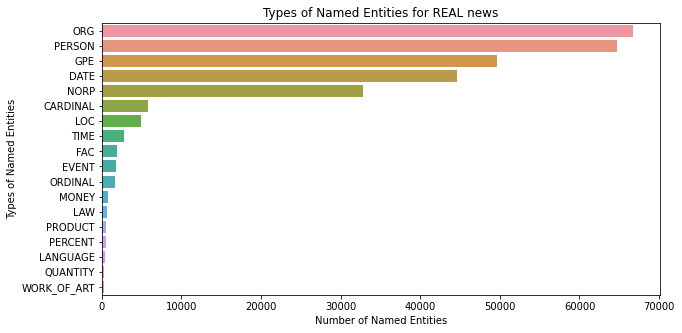

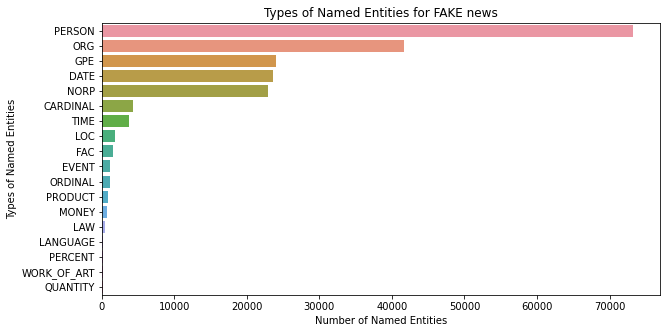

In [64]:
# RFEAL NEWS:
# # Ordered dictionaries by value:
real_ne_types_count_sorted_list = sorted(real_ne_types_count_dict.items(), key=lambda x: x[1], reverse=True)

# print(cstyle.ColorsStyles.bold + cstyle.ColorsStyles.fg.green + "\n REAL NEWS: \n"+ cstyle.ColorsStyles.reset)
# for i in real_ne_types_count_sorted_list:
# 	print(i[0], i[1])
 
# Visualization:
ne_types_plot (my_dict=dict(real_ne_types_count_sorted_list), categ = "REAL") 

#-----------------------------------------------
# FAKE NEWS:
# Ordered dictionaries by value:
fake_ne_types_count_dict_sorted_list = sorted(fake_ne_types_count_dict.items(), key=lambda x: x[1], reverse=True)

# print(cstyle.ColorsStyles.bold + cstyle.ColorsStyles.fg.red + "\n FAKE NEWS: \n" + cstyle.ColorsStyles.reset)
# for i in fake_ne_types_count_dict_sorted_list:
# 	print(i[0], i[1])

# Visualization:
ne_types_plot (my_dict=dict(fake_ne_types_count_dict_sorted_list), categ = "FAKE") 

#### **Conclusions for types of NE in real & fake news:**

Top 5 types of NE are the same for real & fake news - PERSON (People, including fictional), ORG (Companies, agencies, institutions, etc.), GPE (Countries, cities, states), DATE (Absolute or relative dates or periods) & NORP (Nationalities or religious or political groups).

### **Display TOP Values for selected Named Entities:**

#### **REAL NEWS:**

In [65]:
def order_Dict_by_values_desc ( my_dict):
  my_dict_ord = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)
  return my_dict_ord

In [66]:
# Build ordered dictionaries by value:
ordered_ne_by_val_real = dict.fromkeys(real_ne_values_dict.keys(), {})
# print(top_ne_real)

for r_ne, r_ne_count in real_ne_values_dict.items():
  ordered_by_val = order_Dict_by_values_desc(r_ne_count)
  ordered_ne_by_val_real[r_ne] = ordered_by_val
  # print("\n r_ne:", r_ne)
  # print("r_ne_count", ordered_by_val)

# # Print ordered Values for all NE-types:
# for ne, ne_count in ordered_ne_by_val_real.items():
#   print("\n ne:", ne)
#   print(" ne_count", ne_count)

#### **Define TOP_NUM and Wanted types of NE:**

In [69]:
# All NE-types:
# ne_types_keys = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', \
#                   'LANGUAGE',  'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL'
#                 ]

# Define wanted NE-types:
selected_ne_types = ['PERSON', 'ORG', 'EVENT' ]
top_n = 10

TOP 10 VALUES of Named Entities in REAL NEWS: 



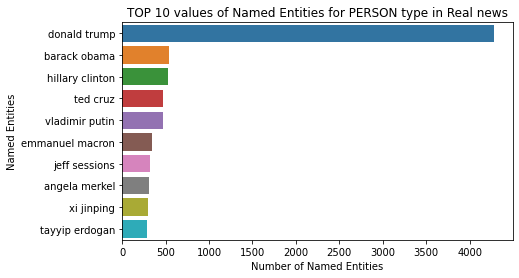

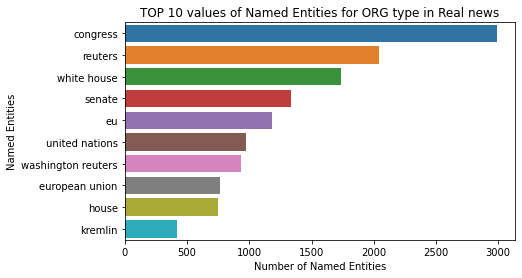

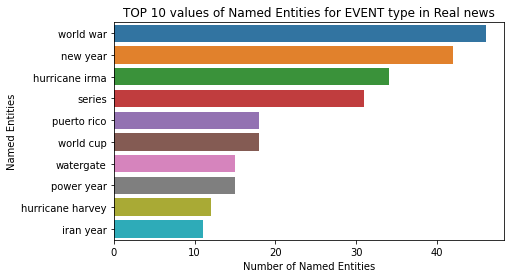

In [70]:
# Get TOP values for each wanted NE-type:
print(cstyle.ColorsStyles.bold + cstyle.ColorsStyles.fg.green + f"TOP {top_n} VALUES of Named Entities in REAL NEWS:" + cstyle.ColorsStyles.reset, "\n")

for ne_type, ne_nest_dict in ordered_ne_by_val_real.items():
  if ( ne_type in selected_ne_types):
    # print("\n ne:", ne_type) 
    top_na_values = list(ne_nest_dict[:top_n]) 
    # print( top_na_values)
    top_ne_plot_for_specific_type (my_dict= dict(top_na_values), top_n=top_n, ne_type =ne_type , categ="Real")
    

#### **FAKE NEWS:**

In [67]:
# Build ordered dictionaries by value:
ordered_ne_by_val_fake = dict.fromkeys(fake_ne_values_dict.keys(), {})
# print(top_ne_real)

for f_ne, f_ne_count in fake_ne_values_dict.items():
  ordered_by_val = order_Dict_by_values_desc(f_ne_count)
  ordered_ne_by_val_fake[f_ne] = ordered_by_val
  # print("\n f_ne:", f_ne)
  # print("f_ne_count", ordered_by_val)

# # Print ordered Values for all NE-types:
# for ne, ne_count in ordered_ne_by_val_fake.items():
#   print("\n ne:", ne)
#   print(" ne_count", ne_count)

TOP 10 VALUES of Named Entities in Fake NEWS: 



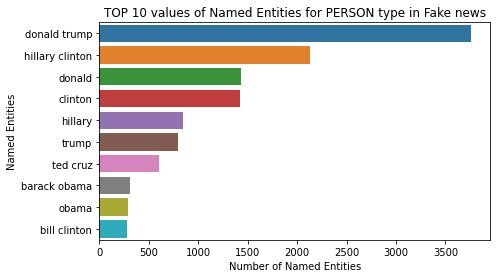

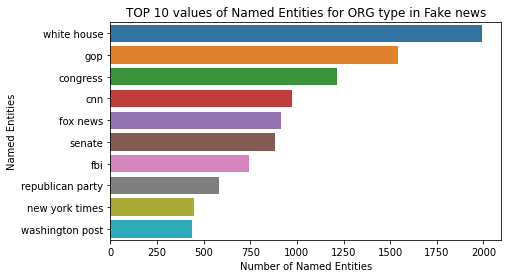

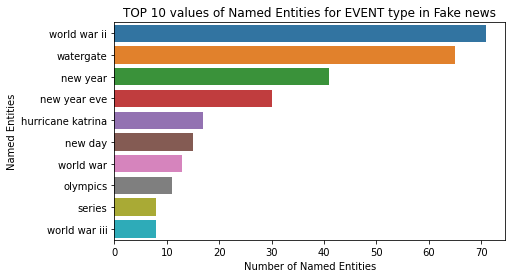

In [71]:
# Get TOP values for each wanted NE-type:
print(cstyle.ColorsStyles.bold + cstyle.ColorsStyles.fg.red + f"TOP {top_n} VALUES of Named Entities in Fake NEWS:"+ cstyle.ColorsStyles.reset, "\n")
for ne_type, ne_nest_dict in ordered_ne_by_val_fake.items():
  if ( ne_type in selected_ne_types):
    # print("\n ne:", ne_type) 
    top_na_values = list(ne_nest_dict[:top_n])  
    # print( list(top_na_values))
    top_ne_plot_for_specific_type (my_dict= dict(top_na_values), top_n=top_n, ne_type =ne_type , categ="Fake")

### **Conclusions for "PERSON" (People, including fictional) NE type in real & fake news:**

*   Donald Trump is most frequent in both real & fake news.
*   Hillary Clinton is more frequent in fake news.
*   Vladimir Putin is more frequent in real news.


### **Conclusions for "ORG" (Companies, agencies, institutions, etc.) NE type in real & fake news:**

*   Reuters is frequent in real news while Fox news & Washington post are frequent in fake news.
*   European union / EU are frequent in real news while Republican party / GOP & FBI are frequent in fake news.


### **Conclusions for "EVENT" (Named hurricanes, battles, wars, sports events, etc.) NE type in real & fake news:**

*   Watergate is frequent in fake news.
*   Hurricane Irma & Hurricane Harvey are frequent in real news while Hurricane Katrina is frequent in both fake & real news.
*   Iran is frequent in real news.
*   Word war is frequent in both fake & real news.


# **PART 3 - Bag Of Words (BOW) Models:**

## **BOW Models with lemmatization:**

In [72]:
df_for_models_with_lemma = pd.read_csv("final_clean_text_spacy_with_lemmma.csv", index_col=0)
print(df_for_models_with_lemma.shape)   # (36646, 5)
df_for_models_with_lemma.sample(2)

(36646, 5)


category                                                                                                                                                                                                                                                                                         Doc_clean_with_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
24427  real news   puerto rico issue delay audit statement april new york san juan reuters puerto rico delay audited financial statement expect finish issue april territory governor say letter house representatives speaker paul ryan monday delay complete statement quoteorterm complexity pose current financial cri...                213               1580                6.4178
34768  real news   trump unveil new response iranian quoteorterm bad behavior white house washington reuters president donald trump announce new response iran s missile test support terrorism cyber operation new iran strategy white house say friday president isn t look piece s look bad behavior iran sarah huckabe...                396               2848                6.1919

### **Splitting the data to train and test:**

In [73]:
X_train_bow_models,X_test_bow_models,y_train_bow_models,y_test_bow_models = train_test_split(
    df_for_models_with_lemma.Doc_clean_with_lemma,
    df_for_models_with_lemma.category,
    test_size=0.2, random_state=42,
    shuffle = True, stratify = df_for_models_with_lemma.category)

In [74]:
print(X_train_bow_models.shape)  # (29316,)
print(X_test_bow_models.shape)  # (7330,)

(29316,)
(7330,)


In [75]:
def get_corpus(text):
    words = []
    for row in text:
      for word in row.split():
        words.append(word.strip())
    return words

In [76]:
all_news_corpus = get_corpus(text = df_for_models_with_lemma.Doc_clean_with_lemma)
print(len(all_news_corpus))  # Total number of words in corpus   # 7897214
print(len(set(all_news_corpus)))  # Number of unique words in corpus   # 81655

7897214
81655


### **Vectorizing  with TF-IDF:**

In [77]:
tfidf = TfidfVectorizer(ngram_range= (1, 2), max_df = 0.2, min_df = 0.003, sublinear_tf = False)

In [78]:
X_train_vec = tfidf.fit_transform(X_train_bow_models)
X_test_vec  = tfidf.transform(X_test_bow_models)

In [79]:
feature_names = tfidf.get_feature_names()
print(len(feature_names))   # 8317
print(feature_names[0:100])

8317
['aaron', 'abadi', 'abandon', 'abbas', 'abc', 'abc news', 'abdel', 'abdel fattah', 'abdullah', 'abe', 'abedin', 'abide', 'ability', 'able', 'aboard', 'abolish', 'abortion', 'abroad', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abu', 'abuse', 'abusive', 'aca', 'academic', 'academy', 'accelerate', 'accept', 'acceptable', 'acceptance', 'access', 'accident', 'accidentally', 'accommodate', 'accompany', 'accomplish', 'accomplishment', 'accord court', 'accord new', 'accord official', 'accord report', 'accord reuters', 'accord source', 'accord state', 'accord statement', 'accord washington', 'accordance', 'account', 'account percent', 'accountability', 'accountable', 'accuracy', 'accurate', 'accurately', 'accusation', 'accuse', 'accuse president', 'accuse trump', 'accuser', 'achieve', 'achievement', 'acknowledge', 'aclu', 'acquire', 'acquisition', 'acr', 'acronym', 'act', 'act like', 'acting', 'action', 'action quoteorterm', 'action take', 'active', 'actively', '

In [80]:
# Create DataFrame for train:
tfidf_array_train = X_train_vec.toarray()
X_train_with_tfidf = pd.DataFrame(tfidf_array_train, columns= feature_names)
print(X_train_with_tfidf.shape)  # (29316, 8317)
X_train_with_tfidf.head()

(29316, 8317)


aaron  abadi  abandon   abbas  abc  abc news  abdel  abdel fattah  abdullah  abe  abedin  abide  ability  able  aboard  abolish  abortion  abroad  abruptly  absence  absent  absolute  absolutely  absurd  abu  abuse  abusive  aca  academic  academy  accelerate  accept  acceptable  acceptance  access  accident  accidentally  accommodate  accompany  accomplish  accomplishment  accord court  accord new  accord official  accord report  accord reuters  accord source  accord state  accord statement  accord washington  accordance  account  account percent  accountability  accountable  accuracy  accurate  accurately  accusation  accuse  accuse president  accuse trump  accuser  achieve  achievement  acknowledge  aclu  acquire  acquisition  acr  acronym     act  act like  acting  action  action quoteorterm  action take  active  actively  activist  activity  actor  actress  actual  actually     ad  adam  adam schiff     add  add quoteorterm  add trump  addict  addition  additional  address  address issue  adequate  adhere  adjust  adjustment  administer  administration  administration official  administration president  administration quoteorterm  administration say  administration take  administrative  administrator  admiral  admire  admission  admit  adolf  adolf hitler   adopt  adult  advance  advanced  advantage  adversary  advertisement  advertising  advice  advise  adviser  adviser michael  adviser president  adviser say  adviser trump  advisor  advisory  advocacy  advocacy group  advocate  afd  affair  affairs  affairs committee  affect  affiliate  affiliation  affirm  afford  affordable  affordable care  afghan  afghanistan  afraid  africa  african  african american  african americans  african country  aftermath  afternoon  afterward   ag  age  aged  agency  agency conclude  agency report  agency say  agenda  agent  aggression  aggressive  aggressively  ago  agree  agreement  agricultural  agriculture   ahead  ahead election  ahmed     aid  aid worker  aide  aide say     aim  air  air base  air force  air strike  aircraft  airline  airlines  airport  aisle   al  al abadi  al assad  al hariri  al qaeda  al sisi  al zor  alabama  alan  alarm  alarming  alaska  albeit  alcohol  alert  alex  alex wong  alexander  ali  alien  alienate  align  alike  alive  allegation  allege  allege russian  alleged  alleged russian  allegedly  allegiance  allen  alliance  allocate  allow    ally  alongside  alphabet  alphabet inc  alt  alt right   alter  alternate  alternate current  alternative  alternative germany  altogether  amazing  amazon  ambassador  ambassador united  ambition  ambitious  amend  amendment  amendment right  america  america great  american  ...  washington new  washington post  washington quoteorterm  washington reuters  washington say  washington state  wasn  waste  waste time   watch  watch interview  watch trump  watch video  watchdog   water  watergate  waters  watson  wave  way say  way trump  ways  ways means  weak  weaken  weakness  wealth  wealthy  weapon  weapon program  wear  weather  web  website  wedding  wednesday  wednesday morning  wednesday night  wednesday quoteorterm  wednesday say  wednesday trump  week ago  week election  week president  week quoteorterm  week say  week trump  weekend  weekly  weigh  weight  weird  welcome  welfare    well  wen  weren    west  west bank  west virginia  western  western ally  wfb   wh  whatsoever  wheel  whine  whip  whistle  white house  white man  white nationalist  white people  white supremacist  white supremacy  wide  wide range  widely  widely expect  widen  widespread   wield  wife  wife melania  wikileaks  wikimedia  wilbur  wilbur ross  wild  wildlife  wildlife refuge  wildly    will  william  williams  willing  willingness  wilson  wilson getty     win  win election  win mcnamee  win nomination  win percent  win presidency  win presidential  win republican  win seat  win state  win support  win trump  win vote  win white  wind  window  wing  winger  winner  winter  

In [81]:
# Create DataFrame for test:
tfidf_array_test = X_test_vec.toarray()
X_test_with_tfidf = pd.DataFrame(tfidf_array_test, columns= feature_names)
print(X_test_with_tfidf.shape)  # (7330, 8317)
X_test_with_tfidf.head()

(7330, 8317)


aaron  abadi  abandon  abbas  abc  abc news  abdel  abdel fattah  abdullah  abe  abedin  abide  ability  able  aboard  abolish  abortion  abroad  abruptly  absence  absent  absolute  absolutely  absurd  abu  abuse  abusive  aca  academic  academy  accelerate  accept  acceptable  acceptance  access  accident  accidentally  accommodate  accompany  accomplish  accomplishment  accord court  accord new  accord official  accord report  accord reuters  accord source  accord state  accord statement  accord washington  accordance  account  account percent  accountability  accountable  accuracy  accurate  accurately  accusation  accuse  accuse president  accuse trump  accuser  achieve  achievement  acknowledge  aclu  acquire  acquisition  acr  acronym     act  act like  acting  action  action quoteorterm  action take  active  actively  activist  activity  actor  actress  actual  actually   ad  adam  adam schiff  add  add quoteorterm  add trump  addict  addition  additional  address  address issue  adequate  adhere  adjust  adjustment  administer  administration  administration official  administration president  administration quoteorterm  administration say  administration take  administrative  administrator  admiral  admire  admission  admit  adolf  adolf hitler  adopt  adult  advance  advanced  advantage  adversary  advertisement  advertising  advice  advise  adviser  adviser michael  adviser president  adviser say  adviser trump  advisor  advisory  advocacy  advocacy group  advocate  afd  affair  affairs  affairs committee  affect  affiliate  affiliation  affirm  afford  affordable  affordable care  afghan  afghanistan  afraid  africa  african  african american  african americans  african country  aftermath  afternoon  afterward   ag  age  aged  agency  agency conclude  agency report  agency say  agenda  agent  aggression  aggressive  aggressively     ago  agree  agreement  agricultural  agriculture   ahead  ahead election  ahmed  aid  aid worker  aide  aide say     aim  air  air base  air force  air strike  aircraft  airline  airlines  airport  aisle   al  al abadi  al assad  al hariri  al qaeda  al sisi  al zor  alabama  alan  alarm  alarming  alaska  albeit  alcohol  alert  alex  alex wong  alexander  ali  alien  alienate   align  alike  alive  allegation  allege  allege russian  alleged  alleged russian  allegedly  allegiance  allen  alliance  allocate   allow    ally  alongside  alphabet  alphabet inc  alt  alt right  alter  alternate  alternate current  alternative  alternative germany  altogether  amazing  amazon  ambassador  ambassador united  ambition  ambitious  amend  amendment  amendment right  america  america great  american  ...  washington new  washington post  washington quoteorterm  washington reuters  washington say  washington state  wasn   waste  waste time  watch  watch interview  watch trump  watch video  watchdog   water  watergate  waters  watson  wave  way say  way trump  ways  ways means  weak  weaken  weakness  wealth  wealthy  weapon  weapon program  wear  weather  web  website  wedding  wednesday  wednesday morning  wednesday night  wednesday quoteorterm  wednesday say  wednesday trump  week ago  week election  week president  week quoteorterm  week say  week trump  weekend  weekly  weigh  weight  weird  welcome  welfare  well  wen  weren    west  west bank  west virginia  western  western ally  wfb   wh  whatsoever  wheel  whine  whip  whistle  white house  white man  white nationalist  white people  white supremacist  white supremacy  wide  wide range  widely  widely expect  widen  widespread  wield  wife  wife melania  wikileaks  wikimedia  wilbur  wilbur ross  wild  wildlife  wildlife refuge  wildly  will  william  williams  willing  willingness  wilson  wilson getty  win  win election  win mcnamee  win nomination  win percent  win presidency  win presidential  win republican  win seat  win state  win support  win trump  win vote  win white  wind  window  wing  winger  winner  winter  wipe  wire  wi

### **BOW-Model 1 - Logistic regression with lemmatization:**

**Logistic regression -- > A special case of GLM (=Generalized Linear Model). Estimates the probability of being a member of a class by fitting logistic functions - "sigmoid". Only for binary classification.**

In [82]:
pd.options.display.float_format = '{:.4f}'.format

In [83]:
lr_cv = StratifiedShuffleSplit(n_splits= 5, train_size= 0.7, test_size= 0.3)

In [84]:
lr_gridsearch_options = [
                            {'C': [3.0, 4.0]}
                        ]

In [85]:
lr_model = GridSearchCV(estimator = LogisticRegression(max_iter = 200, class_weight='balanced'),
                        param_grid = lr_gridsearch_options,
                        cv = lr_cv)

In [ ]:
lr_model.fit(X_train_with_tfidf, y_train_bow_models)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.3,
            train_size=0.7),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid=[{'C': [3.0, 4.0]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
lr_model_best = lr_model.best_estimator_
lr_best_params_dict = lr_model_best.get_params()
lr_best_params_dict

{'C': 4.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### **Assessing BOW-Model 1:**

In [ ]:
y_train_lr_model_proba_pred = pd.DataFrame(lr_model_best.predict_proba(X_train_with_tfidf),
                                           columns= lr_model_best.classes_)

In [ ]:
y_train_lr_model_proba_pred.head()

fake news  real news
0     0.9996     0.0004
1     0.9930     0.0070
2     0.0080     0.9920
3     0.9981     0.0019
4     0.0053     0.9947

In [ ]:
accuracy_score(y_true=y_train_bow_models, y_pred=lr_model_best.predict(X_train_with_tfidf))

0.9971687815527357

In [ ]:
print(classification_report(y_true=y_train_bow_models, y_pred=lr_model_best.predict(X_train_with_tfidf)))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00     12441
   real news       1.00      1.00      1.00     16875

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



           fake news  real news
fake news      12388         53
real news         30      16845


Text(0.5, 1.0, 'Train confusion matrix')

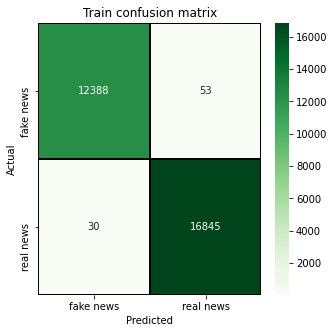

In [ ]:
cm_train_lr_model = confusion_matrix(y_true=y_train_bow_models, y_pred=lr_model_best.predict(X_train_with_tfidf))
print(pd.DataFrame(cm_train_lr_model, index=lr_model_best.classes_, columns=lr_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_lr_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = lr_model_best.classes_ , yticklabels = lr_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

### **Validation of BOW-Model 1:**

In [ ]:
y_test_lr_model_proba_pred = pd.DataFrame(lr_model_best.predict_proba(X_test_with_tfidf),
                                           columns= lr_model_best.classes_)

In [ ]:
y_test_lr_model_proba_pred.head()

fake news  real news
0     0.0224     0.9776
1     0.0035     0.9965
2     0.9998     0.0002
3     0.0205     0.9795
4     0.9472     0.0528

In [ ]:
accuracy_score(y_true=y_test_bow_models, y_pred=lr_model_best.predict(X_test_with_tfidf))

0.9908594815825376

In [ ]:
print(classification_report(y_true=y_test_bow_models, y_pred=lr_model_best.predict(X_test_with_tfidf)))

              precision    recall  f1-score   support

   fake news       0.99      0.99      0.99      3111
   real news       0.99      0.99      0.99      4219

    accuracy                           0.99      7330
   macro avg       0.99      0.99      0.99      7330
weighted avg       0.99      0.99      0.99      7330



           fake news  real news
fake news       3074         37
real news         30       4189


Text(0.5, 1.0, 'Test confusion matrix')

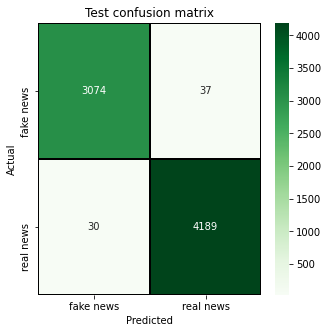

In [ ]:
cm_test_lr_model = confusion_matrix(y_true=y_test_bow_models, y_pred=lr_model_best.predict(X_test_with_tfidf))
print(pd.DataFrame(cm_test_lr_model, index=lr_model_best.classes_, columns=lr_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_lr_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = lr_model_best.classes_ , yticklabels = lr_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

### **Conclusions for BOW-Model 1 - Logistic regression with lemmatization:**

*   Model assessing and validation:

    Train accuracy = 0.9971687815527357, Test accuracy = 0.9908594815825376 --> **the model is good and valid.**
*   Confusion matrix (Positive = fake news, negative = real news):

    Train FN = 53 (fake news the model predicted as real news).

    Train FP = 30 (real news the model predicted as fake news).

    Test FN = 37 (fake news the model predicted as real news).

    Test FP = 30 (real news the model predicted as fake news).

    --> **The model detects real news a little better than fake news.**

### **BOW-Model 2 - Random forest with lemmatization:**

**Random forest -- > ensemble model - Bagging (Bootstrap Aggregation). Bagging means randomly resampling the data in order to create a collection of models, we choose a specific type of model, and then fit many different subsets of the data.**

In [ ]:
rf_cv = StratifiedShuffleSplit(n_splits= 5, train_size= 0.7, test_size= 0.3)

In [ ]:
rf_gridsearch_options = {'min_samples_leaf': [2, 3]}

In [ ]:
rf_model_with_gs = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, criterion="entropy", class_weight='balanced'),
                                param_grid = rf_gridsearch_options,
                                cv = rf_cv)

In [ ]:
rf_model_with_gs.fit(X_train_with_tfidf, y_train_bow_models)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.3,
            train_size=0.7),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                            

In [ ]:
rf_model_best = rf_model_with_gs.best_estimator_
rf_best_params_dict = rf_model_best.get_params()
rf_best_params_dict

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### **Assessing BOW-Model 2 :**

In [ ]:
y_train_rf_model_proba_pred = pd.DataFrame(rf_model_best.predict_proba(X_train_with_tfidf),
                                           columns= rf_model_best.classes_)

In [ ]:
y_train_rf_model_proba_pred.head()

fake news  real news
0     0.9914     0.0086
1     0.9796     0.0204
2     0.0529     0.9471
3     1.0000     0.0000
4     0.0476     0.9524

In [ ]:
accuracy_score(y_true=y_train_bow_models, y_pred=rf_model_best.predict(X_train_with_tfidf))

0.9995224450811844

In [ ]:
print(classification_report(y_true=y_train_bow_models, y_pred=rf_model_best.predict(X_train_with_tfidf)))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00     12441
   real news       1.00      1.00      1.00     16875

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



           fake news  real news
fake news      12431         10
real news          4      16871


Text(0.5, 1.0, 'Train confusion matrix')

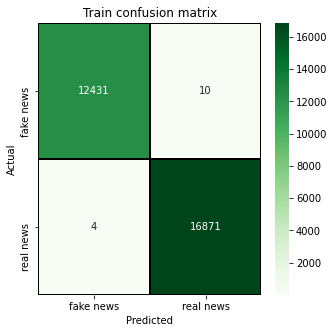

In [ ]:
cm_train_rf_model = confusion_matrix(y_true=y_train_bow_models, y_pred=rf_model_best.predict(X_train_with_tfidf))
print(pd.DataFrame(cm_train_rf_model, index=rf_model_best.classes_, columns=rf_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_rf_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = rf_model_best.classes_ , yticklabels = rf_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

### **Validation of BOW-Model 2:**

In [ ]:
y_test_rf_model_proba_pred = pd.DataFrame(rf_model_best.predict_proba(X_test_with_tfidf),
                                          columns= rf_model_best.classes_)

In [ ]:
y_test_rf_model_proba_pred.head()

fake news  real news
0     0.0460     0.9540
1     0.2276     0.7724
2     0.9779     0.0221
3     0.0213     0.9787
4     0.9198     0.0802

In [ ]:
accuracy_score(y_true=y_test_bow_models, y_pred=rf_model_best.predict(X_test_with_tfidf))

0.9852660300136425

In [ ]:
print(classification_report(y_true=y_test_bow_models, y_pred=rf_model_best.predict(X_test_with_tfidf)))

              precision    recall  f1-score   support

   fake news       0.99      0.98      0.98      3111
   real news       0.98      0.99      0.99      4219

    accuracy                           0.99      7330
   macro avg       0.99      0.98      0.98      7330
weighted avg       0.99      0.99      0.99      7330



           fake news  real news
fake news       3036         75
real news         33       4186


Text(0.5, 1.0, 'Test confusion matrix')

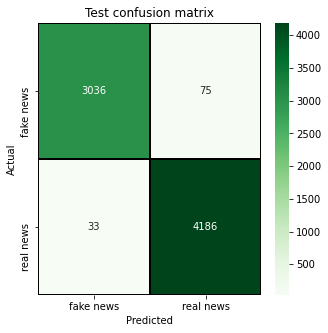

In [ ]:
cm_test_rf_model = confusion_matrix(y_true=y_test_bow_models, y_pred=rf_model_best.predict(X_test_with_tfidf))
print(pd.DataFrame(cm_test_rf_model, index=rf_model_best.classes_, columns=rf_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_rf_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = rf_model_best.classes_ , yticklabels = rf_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

### **Conclusions for BOW-Model 2 - Random forest with lemmatization:**

*   Model assessing and validation:

    Train accuracy = 0.9995224450811844, Test accuracy = 0.9852660300136425 --> **model assessment is very good, but the validation is not as good - the model learns very well from the train data but doesn't perform as well in test data prediction.**
*   Confusion matrix (Positive = fake news, negative = real news):

    Train FN = 10 (fake news the model predicted as real news).

    Train FP = 4 (real news the model predicted as fake news).

    Test FN = 75 (fake news the model predicted as real news).

    Test FP = 33 (real news the model predicted as fake news).

    --> **The model detects real news better than fake news.**

## **BOW Models without lemmatization:**

In [ ]:
df_for_models_without_lemma = pd.read_csv("final_clean_text_spacy_without_lemmma.csv", index_col=0)
print(df_for_models_without_lemma.shape)   # (36646, 5)
df_for_models_without_lemma.sample(2)

(36646, 5)


category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
35631  fake news   maxine waters torches trump lies lack transparency glorious tweet storm maxine waters d physical embodiment anti trump resistance congress openly called orange impeached multiple occasions rails national television opportunity latest attack donald comes favorite platform twitter course waters p...                169               1209                6.1538
33541  real news   dutch begin trial ethiopian war crimes amsterdam reuters man faced war crimes charges dutch court monday accused incarceration torture murder opponents ethiopian leader mengistu haile mariam mengistu s representative ethiopian province gojjam eshetu alemu accused ordering killing young prisoner...                155               1201                6.7484

### **Splitting the data to train and test:**

In [ ]:
X_train_bow_models,X_test_bow_models,y_train_bow_models,y_test_bow_models = train_test_split(
    df_for_models_without_lemma.Doc_clean_without_lemma,
    df_for_models_without_lemma.category,
    test_size=0.2, random_state=42,
    shuffle = True, stratify = df_for_models_without_lemma.category)

In [ ]:
print(X_train_bow_models.shape)   # (29316,)
print(X_test_bow_models.shape)   # (7330,)

(29316,)
(7330,)


In [ ]:
def get_corpus(text):
    words = []
    for row in text:
      for word in row.split():
        words.append(word.strip())
    return words

In [ ]:
all_news_corpus = get_corpus(text = df_for_models_without_lemma.Doc_clean_without_lemma)
print(len(all_news_corpus))  # Total number of words in corpus   # 7897214
print(len(set(all_news_corpus)))  # Number of unique words in corpus   # 90735

7897214
90735


### **Vectorizing  with TF-IDF:**

In [ ]:
tfidf = TfidfVectorizer(ngram_range= (1, 2), max_df = 0.2, min_df = 0.003, sublinear_tf = False)

In [ ]:
X_train_vec = tfidf.fit_transform(X_train_bow_models)
X_test_vec = tfidf.transform(X_test_bow_models)

In [ ]:
feature_names = tfidf.get_feature_names()
print(len(feature_names))  # 9176
print(feature_names[0:100])

9176
['aaron', 'abadi', 'abandon', 'abandoned', 'abandoning', 'abbas', 'abc', 'abc news', 'abdel', 'abdullah', 'abe', 'abedin', 'abide', 'ability', 'able', 'aboard', 'abortion', 'abortions', 'abroad', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abu', 'abuse', 'abused', 'abuses', 'abusing', 'academic', 'academy', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accident', 'accidentally', 'accompanied', 'accomplish', 'accomplished', 'accomplishments', 'accord', 'accordance', 'according court', 'according new', 'according report', 'according reuters', 'according sources', 'according state', 'according statement', 'account', 'accountability', 'accountable', 'accounting', 'accounts', 'accuracy', 'accurate', 'accusation', 'accusations', 'accuse', 'accused', 'accused trump', 'accuses', 'accusing', 'achieve', 'achieved', 'achievement', 'achievements', 'achieving', 'acknowledge', 'acknowledged', 'acknowledging', 'aclu', 'acquired', 'acr', 'acro

In [ ]:
# Create DataFrame for train:
tfidf_array_train = X_train_vec.toarray()
X_train_with_tfidf = pd.DataFrame(tfidf_array_train, columns= feature_names)
print(X_train_with_tfidf.shape)  # (29316, 9176)
X_train_with_tfidf.head()

(29316, 9176)


aaron  abadi  abandon  abandoned  abandoning  abbas  abc  abc news  abdel  abdullah  abe  abedin  abide  ability  able  aboard  abortion  abortions  abroad  abruptly  absence  absent  absolute  absolutely  absurd  abu   abuse  abused  abuses  abusing  academic  academy  accept  acceptable  acceptance  accepted  accepting  access  accident  accidentally  accompanied  accomplish  accomplished  accomplishments  accord  accordance  according court  according new  according report  according reuters  according sources  according state  according statement  account  accountability  accountable  accounting  accounts  accuracy  accurate  accusation  accusations  accuse  accused  accused trump  accuses  accusing  achieve  achieved  achievement  achievements  achieving  acknowledge  acknowledged  acknowledging  aclu  acquired  acr  acronym    act  acted  acting  acting like  action  action childhood  actions  active  actively  activist  activists  activities  activity  actor  actors  actress  acts  actual  actually   ad  adam  adam schiff  add   added  added quoteorterm  added trump  adding  adding quoteorterm  addition  additional  address  addressed  addresses  addressing  adds  adequate  administration  administration official  administration officials  administration president  administration quoteorterm  administration said  administration trump  administrations  administrative  administrator  admiral  admission  admit  admits  admitted  admitting  adolf  adolf hitler  adopt  adopted  ads  adult  adults  advance  advanced  advances  advancing  advantage  adversaries  advertising  advice  advise  advised  adviser  adviser michael  adviser president  advisers  advising  advisor  advisors  advisory  advocacy  advocacy group  advocacy groups  advocate  advocated  advocates  advocating  afd  affair  affairs  affairs committee  affect  affected  affecting  affects  affiliate  affiliated  affiliation  afford  affordable  affordable care  afghan  afghanistan  afraid  africa  african  african american  african americans  aftermath  afternoon  afterward   ag     age  aged  agencies  agencies concluded  agency  agency reported  agency said  agenda  agent  agents  ages  aggression  aggressive  aggressively  aging  ago  agree  agreed  agreeing  agreement  agreements  agrees  agricultural  agriculture   ahead  ahead election  ahmed  aid  aide  aide said  aides  aides said  aim  aimed  aiming  aims  air  air base  air force  air strikes  aircraft  aired  airline  airlines  airport  airports  aisle      al  al abadi  al assad  al hariri  al qaeda  al zor  alabama  alan  alarm  alarmed  alarming  alaska  albeit  alcohol   alert  ...  watch trump  watch video  watchdog  watched  watching  water  watergate  waters  watson  wave  waving  way trump  ways  ways means  weak  weaken  weakened  weakening  weakness  wealth  wealthy  weapon  weapons  weapons program  wear  wearing  weather  web  website  websites  wednesday  wednesday morning  wednesday night  wednesday quoteorterm  wednesday said  wednesday trump  week ago  week quoteorterm  week said  week trump  weekend  weekly  weeks  weeks ago  weigh  weighed  weighing  weighs  weight  weird  welcome  welcomed  welcoming  welfare  wells  wen  went  went far  went viral  weren  west  west bank  west virginia  western  wfb      wh  whatsoever  whine  whined  whining  whip  white house  white men  white nationalist  white nationalists  white people  white supremacist  white supremacists  white supremacy  whites  wide  wide ranging  widely  widely expected  wider  widespread  wife  wikileaks  wikimedia  wilbur  wilbur ross  wild  wildlife  wildlife refuge  wildly  william  williams  willing  willingness  wilson  wilson getty  win  win election  win mcnamee  win white  wind  window  windows  winds  wing  winner  winning  winning election  wins  winter  wire  wire says  wisconsin    wise  wish  wishes  witch  witch hunt  withdraw  withdrawal  withdrawing  withdrawn  withdrew  witness  witnessed  witnesses  wi

In [ ]:
# Create DataFrame for test:
tfidf_array_test = X_test_vec.toarray()
X_test_with_tfidf = pd.DataFrame(tfidf_array_test, columns= feature_names)
print(X_test_with_tfidf.shape)  # (7330, 9176)
X_test_with_tfidf.head()

(7330, 9176)


aaron  abadi  abandon  abandoned  abandoning  abbas  abc  abc news  abdel  abdullah  abe  abedin  abide  ability  able  aboard  abortion  abortions  abroad  abruptly  absence  absent  absolute  absolutely  absurd  abu  abuse  abused  abuses  abusing  academic  academy  accept  acceptable  acceptance  accepted  accepting  access  accident  accidentally  accompanied  accomplish  accomplished  accomplishments  accord  accordance  according court  according new  according report  according reuters  according sources  according state  according statement  account  accountability  accountable  accounting  accounts  accuracy  accurate  accusation  accusations  accuse  accused  accused trump  accuses  accusing  achieve  achieved  achievement  achievements  achieving  acknowledge  acknowledged  acknowledging  aclu  acquired  acr  acronym  act  acted  acting  acting like  action  action childhood  actions  active  actively  activist  activists  activities  activity  actor  actors  actress  acts  actual  actually   ad  adam  adam schiff  add   added  added quoteorterm  added trump  adding  adding quoteorterm  addition  additional  address  addressed  addresses  addressing  adds  adequate  administration  administration official  administration officials  administration president  administration quoteorterm  administration said  administration trump  administrations  administrative  administrator  admiral  admission  admit  admits  admitted  admitting  adolf  adolf hitler  adopt  adopted  ads  adult  adults  advance  advanced  advances  advancing  advantage  adversaries  advertising  advice  advise  advised  adviser  adviser michael  adviser president  advisers  advising  advisor  advisors  advisory  advocacy  advocacy group  advocacy groups  advocate  advocated  advocates  advocating  afd  affair  affairs  affairs committee  affect  affected  affecting  affects  affiliate  affiliated  affiliation  afford  affordable  affordable care  afghan  afghanistan  afraid  africa  african  african american  african americans  aftermath  afternoon  afterward   ag  age  aged  agencies  agencies concluded  agency  agency reported  agency said  agenda  agent  agents  ages  aggression  aggressive  aggressively  aging     ago  agree  agreed  agreeing  agreement  agreements  agrees  agricultural  agriculture  ahead  ahead election  ahmed  aid  aide  aide said  aides  aides said  aim  aimed  aiming  aims     air  air base  air force  air strikes  aircraft  aired  airline  airlines  airport  airports  aisle      al  al abadi  al assad  al hariri  al qaeda  al zor  alabama  alan  alarm  alarmed  alarming  alaska  albeit  alcohol  alert  ...  watch trump  watch video  watchdog  watched  watching  water  watergate  waters  watson  wave  waving  way trump    ways  ways means  weak  weaken  weakened  weakening  weakness  wealth  wealthy  weapon  weapons  weapons program  wear  wearing  weather  web  website  websites  wednesday  wednesday morning  wednesday night  wednesday quoteorterm  wednesday said  wednesday trump  week ago  week quoteorterm  week said  week trump  weekend  weekly  weeks  weeks ago   weigh  weighed  weighing  weighs  weight  weird  welcome  welcomed  welcoming  welfare  wells  wen  went  went far  went viral  weren  west  west bank  west virginia  western     wfb   wh  whatsoever  whine  whined  whining  whip  white house  white men  white nationalist  white nationalists  white people  white supremacist  white supremacists  white supremacy  whites  wide  wide ranging  widely  widely expected  wider  widespread  wife  wikileaks  wikimedia  wilbur  wilbur ross  wild  wildlife  wildlife refuge  wildly  william  williams  willing  willingness  wilson  wilson getty     win  win election  win mcnamee  win white  wind  window  windows  winds    wing  winner  winning  winning election  wins  winter  wire  wire says  wisconsin  wise  wish  wishes  witch  witch hunt  withdraw  withdrawal  withdrawing  withdrawn  withdrew  witness  witnessed  witnesses

### **BOW-Model 3 - Logistic regression without lemmatization:**

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
lr_cv = StratifiedShuffleSplit(n_splits= 5, train_size= 0.7, test_size= 0.3)

In [ ]:
lr_gridsearch_options = [
                         {'C': [3.0, 4.0]}
]

In [ ]:
lr_model = GridSearchCV(estimator = LogisticRegression(max_iter=200, class_weight='balanced'),
                        param_grid = lr_gridsearch_options,
                        cv = lr_cv)

In [ ]:
lr_model.fit(X_train_with_tfidf, y_train_bow_models)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.3,
            train_size=0.7),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid=[{'C': [3.0, 4.0]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
lr_model_best = lr_model.best_estimator_
lr_best_params_dict = lr_model_best.get_params()
lr_best_params_dict

{'C': 4.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### **Assessing BOW-Model 3:**

In [ ]:
y_train_lr_model_proba_pred = pd.DataFrame(lr_model_best.predict_proba(X_train_with_tfidf),
                                           columns= lr_model_best.classes_)

In [ ]:
y_train_lr_model_proba_pred.head()

fake news  real news
0     0.9225     0.0775
1     0.9999     0.0001
2     0.0385     0.9615
3     0.7936     0.2064
4     0.0011     0.9989

In [ ]:
accuracy_score(y_true=y_train_bow_models, y_pred=lr_model_best.predict(X_train_with_tfidf))

0.997578114340292

In [ ]:
print(classification_report(y_true=y_train_bow_models, y_pred=lr_model_best.predict(X_train_with_tfidf)))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00     12441
   real news       1.00      1.00      1.00     16875

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



           fake news  real news
fake news      12397         44
real news         27      16848


Text(0.5, 1.0, 'Train confusion matrix')

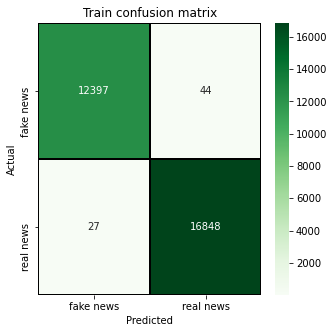

In [ ]:
cm_train_lr_model = confusion_matrix(y_true=y_train_bow_models, y_pred=lr_model_best.predict(X_train_with_tfidf))
print(pd.DataFrame(cm_train_lr_model, index=lr_model_best.classes_, columns=lr_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_lr_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = lr_model_best.classes_ , yticklabels = lr_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

### **Validation of BOW-Model 3:**

In [ ]:
y_test_rf_model_proba_pred = pd.DataFrame(lr_model_best.predict_proba(X_test_with_tfidf),
                                           columns= lr_model_best.classes_)

In [ ]:
y_test_rf_model_proba_pred.head()

fake news  real news
0     0.1250     0.8750
1     0.0003     0.9997
2     0.9734     0.0266
3     0.0154     0.9846
4     0.9962     0.0038

In [ ]:
accuracy_score(y_true=y_test_bow_models, y_pred=lr_model_best.predict(X_test_with_tfidf))

0.9892223738062755

In [ ]:
print(classification_report(y_true=y_test_bow_models, y_pred=lr_model_best.predict(X_test_with_tfidf)))

              precision    recall  f1-score   support

   fake news       0.99      0.98      0.99      3111
   real news       0.99      0.99      0.99      4219

    accuracy                           0.99      7330
   macro avg       0.99      0.99      0.99      7330
weighted avg       0.99      0.99      0.99      7330



           fake news  real news
fake news       3062         49
real news         30       4189


Text(0.5, 1.0, 'Test confusion matrix')

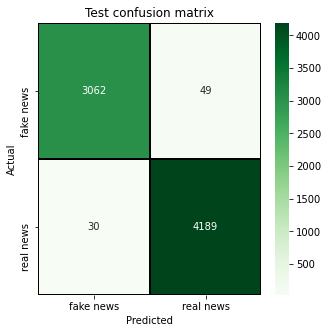

In [ ]:
cm_test_lr_model = confusion_matrix(y_true=y_test_bow_models, y_pred=lr_model_best.predict(X_test_with_tfidf))
print(pd.DataFrame(cm_test_lr_model, index=lr_model_best.classes_, columns=lr_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_lr_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = lr_model_best.classes_ , yticklabels = lr_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

### **Conclusions for BOW-Model 3 - Logistic regression without lemmatization:**

*   Model assessing and validation:

    Train accuracy = 0.997578114340292, Test accuracy = 0.9892223738062755 --> **the model is good and valid.**
*   Confusion matrix (Positive = fake news, negative = real news):

    Train FN = 44 (fake news the model predicted as real news).

    Train FP = 27 (real news the model predicted as fake news).

    Test FN = 49 (fake news the model predicted as real news).

    Test FP = 30 (real news the model predicted as fake news).

    --> **The model detects real news a little better than fake news.**

### **BOW-Model 4 - Random forest without lemmatization:**

In [ ]:
rf_cv = StratifiedShuffleSplit(n_splits= 5, train_size= 0.7, test_size= 0.3)

In [ ]:
rf_gridsearch_options = {'min_samples_leaf': [2, 3]}

In [ ]:
rf_model_with_gs = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, criterion="entropy", class_weight='balanced'),
                                param_grid = rf_gridsearch_options,
                                cv = rf_cv)

In [ ]:
rf_model_with_gs.fit(X_train_with_tfidf, y_train_bow_models)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.3,
            train_size=0.7),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                            

In [ ]:
rf_model_best = rf_model_with_gs.best_estimator_
rf_best_params_dict = rf_model_best.get_params()
rf_best_params_dict

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### **Assessing BOW-Model 4:**

In [ ]:
y_train_rf_model_proba_pred = pd.DataFrame(rf_model_best.predict_proba(X_train_with_tfidf),
                                           columns= rf_model_best.classes_)

In [ ]:
y_train_rf_model_proba_pred.head()

fake news  real news
0     0.8205     0.1795
1     0.9667     0.0333
2     0.2001     0.7999
3     0.7903     0.2097
4     0.0495     0.9505

In [ ]:
accuracy_score(y_true=y_train_bow_models, y_pred=rf_model_best.predict(X_train_with_tfidf))

0.999556556146814

In [ ]:
print(classification_report(y_true=y_train_bow_models, y_pred=rf_model_best.predict(X_train_with_tfidf)))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00     12441
   real news       1.00      1.00      1.00     16875

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



           fake news  real news
fake news      12430         11
real news          2      16873


Text(0.5, 1.0, 'Train confusion matrix')

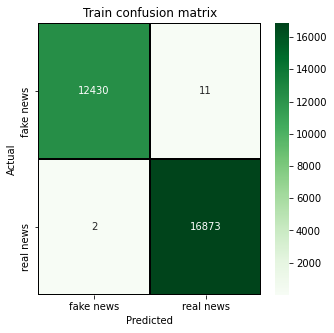

In [ ]:
cm_train_rf_model = confusion_matrix(y_true=y_train_bow_models, y_pred=rf_model_best.predict(X_train_with_tfidf))
print(pd.DataFrame(cm_train_rf_model, index=rf_model_best.classes_, columns=rf_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_rf_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = rf_model_best.classes_ , yticklabels = rf_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

### **Validation of BOW-Model 4:**

In [ ]:
y_test_rf_model_proba_pred = pd.DataFrame(rf_model_best.predict_proba(X_test_with_tfidf),
                                          columns= rf_model_best.classes_)

In [ ]:
y_test_rf_model_proba_pred.head()

fake news  real news
0     0.0640     0.9360
1     0.0227     0.9773
2     0.8810     0.1190
3     0.1408     0.8592
4     0.9658     0.0342

In [ ]:
accuracy_score(y_true=y_test_bow_models, y_pred=rf_model_best.predict(X_test_with_tfidf))

0.9830832196452933

In [ ]:
print(classification_report(y_true=y_test_bow_models, y_pred=rf_model_best.predict(X_test_with_tfidf)))

              precision    recall  f1-score   support

   fake news       0.99      0.97      0.98      3111
   real news       0.98      0.99      0.99      4219

    accuracy                           0.98      7330
   macro avg       0.98      0.98      0.98      7330
weighted avg       0.98      0.98      0.98      7330



           fake news  real news
fake news       3019         92
real news         32       4187


Text(0.5, 1.0, 'Test confusion matrix')

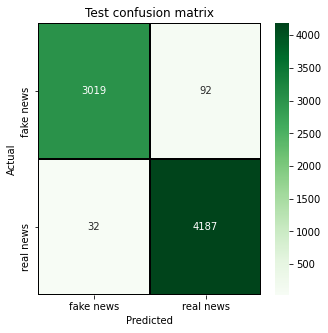

In [ ]:
cm_test_rf_model = confusion_matrix(y_true=y_test_bow_models, y_pred=rf_model_best.predict(X_test_with_tfidf))
print(pd.DataFrame(cm_test_rf_model, index=rf_model_best.classes_, columns=rf_model_best.classes_))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_rf_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = rf_model_best.classes_ , yticklabels = rf_model_best.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

### **Conclusions for BOW-Model 4 - Random forest without lemmatization:**

*   Model assessing and validation:

    Train accuracy = 0.999556556146814, Test accuracy = 0.9830832196452933 --> **model assessment is very good, but the validation is not as good - the model learns very well from the train data but doesn't perform as well in test data prediction.**
*   Confusion matrix (Positive = fake news, negative = real news):

    Train FN = 11 (fake news the model predicted as real news).

    Train FP = 2 (real news the model predicted as fake news).

    Test FN = 92 (fake news the model predicted as real news).

    Test FP = 32 (real news the model predicted as fake news).

    --> **The model detects real news better than fake news.**

# **Deep Learning (DL) Models:**

### **DL-Model 1 - RNN model with LSTM & embedding - without lemmatization:**

In [ ]:
df_for_models_without_lemma = pd.read_csv("final_clean_text_spacy_without_lemmma.csv", index_col=0)
print(df_for_models_without_lemma.shape)   # (36646, 5)
df_for_models_without_lemma.sample(2)

(36646, 5)


category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
3034   fake news   hispanic rep told trump shove quoteorterm border wall epic republican presidential nominee donald trump crossed rubicon racism people starting lash rightfully disqualifying trump university judge race republicans democrats alike holding trump s feet fire republicans simply disavowed comments fl...                230               1692                6.3565
30301  fake news   real damning reason trump opened fire blumenthal twitter details ve seen donald trump s absolute monday meltdown twitter hour tweeting frenzy beat tirade s social media platform trump cooped indoors wanted golf claiming wasn t vacation forced stay new jersey golf club rained course scrambled re...                267               1913                6.1648

In [ ]:
df_for_models_without_lemma["category"]= df_for_models_without_lemma["category"].\
apply(lambda x: 1 if x == "real news" else 0)

In [ ]:
df_for_models_without_lemma.sample(2)

category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
31150         0   trump halts travel new executive order century wire says president donald trump s previous visa suspension blocked federal courts fulfilled vow overturn introducing new executive order temporarily blocking travel residents muslim majority countries pending revision visa procedures order halts i...                278               2127                6.6511
18915         1   dependent migrant dollars rural mexico prays trump defeat molcaxac mexico reuters small southern market town molcaxac miles km border alicia villa praying god republican candidate donald trump president united states past decades mexico rural economy stalled molcaxac hundreds towns like depende...                448               3296                6.3571

### **Splitting the data to train and test:**

In [ ]:
X_train_dl_models,X_test_dl_models,y_train_dl_models,y_test_dl_models = train_test_split(
    df_for_models_without_lemma.Doc_clean_without_lemma,
    df_for_models_without_lemma.category,
    test_size=0.2)

In [ ]:
print(X_train_dl_models.shape)   # (29316,)
print(X_test_dl_models.shape)   # (7330,)

(29316,)
(7330,)


In [ ]:
def get_corpus(text):
    words = []
    for row in text:
      for word in row.split():
        words.append(word.strip())
    return words

In [ ]:
train_news_corpus = get_corpus(text = X_train_dl_models)
print(len(train_news_corpus))  # Total number of words in train corpus   # 6315768
print(len(set(train_news_corpus)))  # Number of unique words in train corpus --> train vocabulary size   # 82436

6315768
82436


### **Tokenizing:**

In [86]:
max_num_words    = 1000  # -- > vocabulary size
max_sequence_len = 700

In [ ]:
tokenizer = Tokenizer(num_words = max_num_words)  # num_words: max number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
tokenizer.fit_on_texts(X_train_dl_models)
tokenized_train = tokenizer.texts_to_sequences(X_train_dl_models)
X_train_sequences_matrix = pad_sequences(tokenized_train, maxlen = max_sequence_len)

In [ ]:
X_train_sequences_matrix[:5]

array([[  0,   0,   0, ..., 108, 320,   6],
       [  0,   0,   0, ...,   7, 257,   3],
       [  0,   0,   0, ...,  69, 278, 217],
       [  0,   0,   0, ..., 499, 437, 978],
       [  0,   0,   0, ..., 322,  99,  69]], dtype=int32)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test_dl_models)
X_test_sequences_matrix = pad_sequences(tokenized_test, maxlen = max_sequence_len)

In [ ]:
X_test_sequences_matrix[:5]

array([[  0,   0,   0, ..., 106, 139, 312],
       [  0,   0,   0, ...,  69, 904, 942],
       [  0,   0,   0, ...,  86, 224, 499],
       [  0,   0,   0, ..., 132,  30, 658],
       [  0,   0,   0, ..., 156, 224, 508]], dtype=int32)

### **Creating the DL-Model 1:**

#### **The Model class:**

When creating a model class we start with the input and chain layer cells to specify the models' forward pass. A layer object, when called, attaches itself to the layer object passed to it as an argument, thus facilitating the layer chaining process.

In [ ]:
batch_size = 256
epochs = 10
embedding_size = 100

In [ ]:
inputs = Input(shape=(max_sequence_len,), name = "Input")
layer = Embedding(input_dim = max_num_words, output_dim = embedding_size, input_length = max_sequence_len, name = "Embedding")(inputs)
layer = LSTM(units = 128, name = "LSTM")(layer)
layer = Dropout(0.25, name = "Dropout1")(layer)
layer = Dense(64, activation='relu', name = "Dense")(layer)
layer = Dropout(0.1, name = "Dropout2")(layer)
outputs = Dense(1, activation='sigmoid', name = "Output")(layer)

In [ ]:
RNN_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
RNN_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(lr = 0.01), metrics = ['accuracy'])

In [ ]:
RNN_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 700)]             0         
_________________________________________________________________
Embedding (Embedding)        (None, 700, 100)          100000    
_________________________________________________________________
LSTM (LSTM)                  (None, 128)               117248    
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0         
_________________________________________________________________
Dense (Dense)                (None, 64)                8256      
_________________________________________________________________
Dropout2 (Dropout)           (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                

### **Number of parameters calculations:**

* **Embedding layer:**

 1,000 (max_num_words / vocabulary size) $\times$ 100 (embedding_size) = 100,000

* **LSTM layer:**

 $g$ --> no. of FFNNs in a unit (LSTM has 4) --> 4<br/>
 $h$ --> size of hidden units --> 128<br/>
 $i$ --> dimension/size of input (embedding_size) --> 100<br/>

 Since every FFNN has $h(h+i) + h$ parameters:

 g × [h(h+i) + h]$ --> $4 × (128 × [128 + 100] + 128)$ = 117,248$

* **Dense layer:**

 128 (weights from previous layer) $\times$ 64 (size of hidden units) + 64 (biases) = 8,256

* **Output layer:**

 64 (weights from previous layer) $\times$ 1 (size of output) + 1 (bias) = 65

* **Total trainable params:**

 100,000 + 117,248 + 8,256 + 65 = 225,569

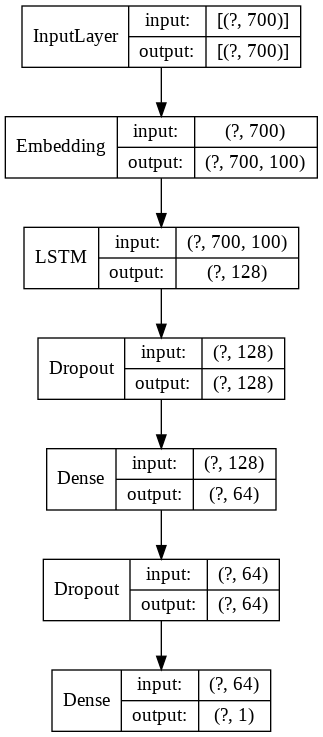

In [ ]:
plot_model(RNN_model, show_layer_names=False, show_shapes=True)

### **Fitting DL-Model 1:**

In [ ]:
history_rnn_model = RNN_model.fit(X_train_sequences_matrix, y_train_dl_models, batch_size = batch_size,
                                  epochs = epochs, validation_split = 0.2, verbose = 1,
                                  callbacks=[EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, verbose = 1,
                                                           patience = 2, mode = 'min')])

Epoch 1/10
92/92 [==============================] - 11s 116ms/step - loss: 0.1924 - accuracy: 0.9294 - val_loss: 0.1126 - val_accuracy: 0.9645
Epoch 2/10
92/92 [==============================] - 10s 112ms/step - loss: 0.0578 - accuracy: 0.9829 - val_loss: 0.0252 - val_accuracy: 0.9930
Epoch 3/10
92/92 [==============================] - 10s 112ms/step - loss: 0.0294 - accuracy: 0.9933 - val_loss: 0.0226 - val_accuracy: 0.9925
Epoch 4/10
92/92 [==============================] - 10s 112ms/step - loss: 0.0359 - accuracy: 0.9904 - val_loss: 0.0109 - val_accuracy: 0.9976
Epoch 5/10
92/92 [==============================] - 10s 112ms/step - loss: 0.0121 - accuracy: 0.9968 - val_loss: 0.0109 - val_accuracy: 0.9978
Epoch 6/10
92/92 [==============================] - 10s 111ms/step - loss: 0.0185 - accuracy: 0.9948 - val_loss: 0.0112 - val_accuracy: 0.9978
Epoch 00006: early stopping


### **Assessing DL-Model 1:**

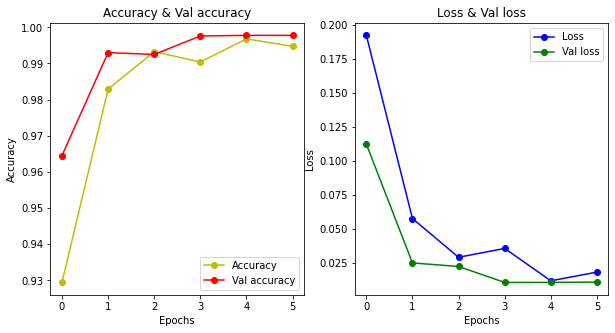

In [ ]:
epochs = [i for i in range(6)]
fig , ax = plt.subplots(1,2)
train_acc = history_rnn_model.history['accuracy']
train_loss = history_rnn_model.history['loss']
val_acc = history_rnn_model.history['val_accuracy']
val_loss = history_rnn_model.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'yo-' , label = 'Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Val accuracy')
ax[0].set_title('Accuracy & Val accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'bo-' , label = 'Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Val loss')
ax[1].set_title('Loss & Val loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
y_train_pred_proba = pd.DataFrame(RNN_model.predict(X_train_sequences_matrix))
y_train_pred_proba[:5]

0
0 0.0013
1 0.9999
2 0.0000
3 1.0000
4 0.0000

In [ ]:
y_train_pred_proba["pred"] = y_train_pred_proba.apply(lambda x: x > 0.5, axis = 1)

In [ ]:
y_train_pred_proba.head()

0   pred
0 0.0013  False
1 0.9999   True
2 0.0000  False
3 1.0000   True
4 0.0000  False

In [ ]:
print(classification_report(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12438
           1       1.00      1.00      1.00     16878

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



In [ ]:
print(classification_report(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"],
                            target_names = ["fake news", "real news"]))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00     12438
   real news       1.00      1.00      1.00     16878

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



In [ ]:
train_scores = RNN_model.evaluate(X_train_sequences_matrix, y_train_dl_models, verbose=0)
# [loss, accuracy]
print('Train loss score: ', train_scores[0])
print('Train accuracy score: ', train_scores[1])

Train loss score:  0.007057127542793751
Train accuracy score:  0.9977827668190002


       0      1
0  12405     33
1     32  16846


Text(0.5, 1.0, 'Train confusion matrix')

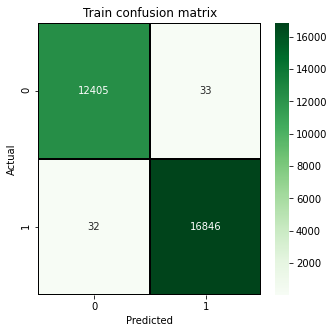

In [ ]:
cm_train_rnn_model = confusion_matrix(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"])
print(pd.DataFrame(cm_train_rnn_model))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_rnn_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

           fake news  real news
fake news      12405         33
real news         32      16846


Text(0.5, 1.0, 'Train confusion matrix')

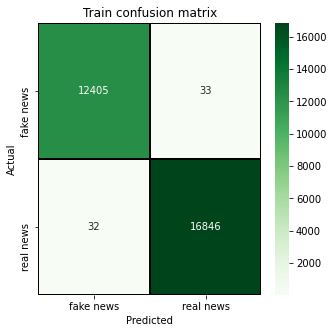

In [ ]:
cm_train_rnn_model = confusion_matrix(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"])
print(pd.DataFrame(cm_train_rnn_model, index = ["fake news", "real news"], columns = ["fake news", "real news"]))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_rnn_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = ["fake news", "real news"] , yticklabels = ["fake news", "real news"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

### **Validation of DL-Model 1:**

In [ ]:
y_test_pred_proba = pd.DataFrame(RNN_model.predict(X_test_sequences_matrix))
y_test_pred_proba[:5]

0
0 0.0000
1 0.0000
2 0.9893
3 0.0121
4 0.0049

In [ ]:
y_test_pred_proba["pred"] = y_test_pred_proba.apply(lambda x: x > 0.5, axis = 1)

In [ ]:
y_test_pred_proba.head()

0   pred
0 0.0000  False
1 0.0000  False
2 0.9893   True
3 0.0121  False
4 0.0049  False

In [ ]:
print(classification_report(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3114
           1       1.00      1.00      1.00      4216

    accuracy                           1.00      7330
   macro avg       1.00      1.00      1.00      7330
weighted avg       1.00      1.00      1.00      7330



In [ ]:
print(classification_report(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"],
                            target_names = ["fake news", "real news"]))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00      3114
   real news       1.00      1.00      1.00      4216

    accuracy                           1.00      7330
   macro avg       1.00      1.00      1.00      7330
weighted avg       1.00      1.00      1.00      7330



In [ ]:
test_scores = RNN_model.evaluate(X_test_sequences_matrix, y_test_dl_models, verbose=0)
# [loss, accuracy]
print('Test loss score: ', test_scores[0])
print('Test accuracy score: ', test_scores[1])

Test loss score:  0.006778936833143234
Test accuracy score:  0.9980900287628174


      0     1
0  3109     5
1     9  4207


Text(0.5, 1.0, 'Test confusion matrix')

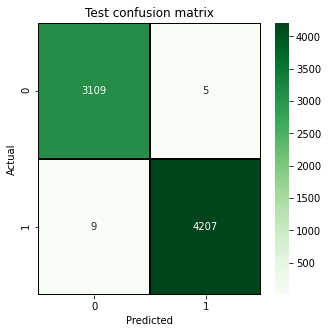

In [ ]:
cm_test_rnn_model = confusion_matrix(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"])
print(pd.DataFrame(cm_test_rnn_model))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_rnn_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

           fake news  real news
fake news       3109          5
real news          9       4207


Text(0.5, 1.0, 'Test confusion matrix')

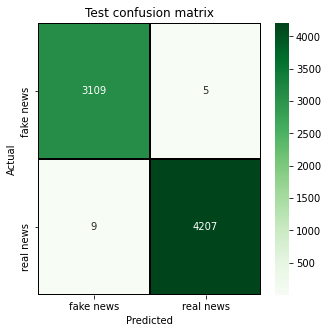

In [ ]:
cm_test_rnn_model = confusion_matrix(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"])
print(pd.DataFrame(cm_test_rnn_model, index = ["fake news", "real news"], columns = ["fake news", "real news"]))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_rnn_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = ["fake news", "real news"] , yticklabels = ["fake news", "real news"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

### **Conclusions for DL-Model 1 - RNN model with LSTM & embedding - without lemmatization:**

*   Model assessing and validation:

    Train accuracy = 0.9977827668190002, Test accuracy = 0.9980900287628174, Train loss = 0.007057127542793751, Test loss = 0.006778936833143234 --> **model assessment and validation are very good.**
*   Confusion matrix (Positive = fake news, negative = real news):

    Train FN = 33 (fake news the model predicted as real news).

    Train FP = 32 (real news the model predicted as fake news).

    Test FN = 5 (fake news the model predicted as real news).

    Test FP = 9 (real news the model predicted as fake news).

    --> **The model detects fake news better than real news.**

### **DL-Model 2 - RNN model with Glove embedding & LSTM without lemmatization:**

In [ ]:
df_for_models_without_lemma = pd.read_csv("final_clean_text_spacy_without_lemmma.csv", index_col=0)
print(df_for_models_without_lemma.shape)   # (36646, 5)
df_for_models_without_lemma.sample(2)

(36646, 5)


category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
29808  fake news   racist jerk takes hate national black history museum vile way possible smithsonian s museum african american history opened fanfare hatred white people think thing affront white history reverse discrimination trump elected hate crimes incidents skyrocketed racist asshat decided hatred straight ...                199               1475                6.4121
18121  fake news   watch trump supporter admits quoteorterm america great means vile reason conservatives support donald trump literally think erase years american history final debate wednesday night face nation host john dickerson sat group nevada voters restaurant talked candidates talked woman named barbara h...                201               1458                6.2537

In [ ]:
df_for_models_without_lemma["category"]= df_for_models_without_lemma["category"].\
apply(lambda x: 1 if x == "real news" else 0)

In [ ]:
df_for_models_without_lemma.sample(2)

category                                                                                                                                                                                                                                                                                      Doc_clean_without_lemma  num_words_in_text  num_chars_in_text  avg_word_len_in_text
3068          1   yemenis dead saudi led raid police camp sanaa official dubai reuters saudi led coalition aircraft struck military police camp houthi controlled yemeni capital sanaa wednesday killing people wounding including prisoners official witnesses said strike air campaign western backed coalition iran al...                126                947                6.5159
31949         1   mattis says try work pakistan quoteorterm time washington reuters defense secretary jim mattis said tuesday united states try time work pakistan afghanistan president donald trump turn options address islamabad s alleged support militant groups relations countries frayed past decade officials l...                230               1731                6.5261

### **Splitting the data to train and test:**

In [ ]:
X_train_dl_models,X_test_dl_models,y_train_dl_models,y_test_dl_models = train_test_split(
    df_for_models_without_lemma.Doc_clean_without_lemma,
    df_for_models_without_lemma.category,
    test_size=0.2)

In [ ]:
print(X_train_dl_models.shape)   # (29316,)
print(X_test_dl_models.shape)   # (7330,)

(29316,)
(7330,)


In [ ]:
def get_corpus(text):
    words = []
    for row in text:
      for word in row.split():
        words.append(word.strip())
    return words

In [ ]:
train_news_corpus = get_corpus(text = X_train_dl_models)
print(len(train_news_corpus))  # Total number of words in train corpus   # 6315768
print(len(set(train_news_corpus)))  # Number of unique words in train corpus --> train vocabulary size   # 82436

6315768
82436


### **Tokenizing:**

In [ ]:
max_num_words = 1000  # -- > vocabulary size
max_sequence_len = 700

In [ ]:
tokenizer = Tokenizer(num_words = max_num_words)  # num_words: max number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
tokenizer.fit_on_texts(X_train_dl_models)
tokenized_train = tokenizer.texts_to_sequences(X_train_dl_models)
X_train_sequences_matrix = pad_sequences(tokenized_train, maxlen = max_sequence_len)

In [ ]:
X_train_sequences_matrix[:5]

array([[  0,   0,   0, ..., 108, 320,   6],
       [  0,   0,   0, ...,   7, 257,   3],
       [  0,   0,   0, ...,  69, 278, 217],
       [  0,   0,   0, ..., 499, 437, 978],
       [  0,   0,   0, ..., 322,  99,  69]], dtype=int32)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test_dl_models)
X_test_sequences_matrix = pad_sequences(tokenized_test, maxlen = max_sequence_len)

In [ ]:
X_test_sequences_matrix[:5]

array([[  0,   0,   0, ..., 106, 139, 312],
       [  0,   0,   0, ...,  69, 904, 942],
       [  0,   0,   0, ...,  86, 224, 499],
       [  0,   0,   0, ..., 132,  30, 658],
       [  0,   0,   0, ..., 156, 224, 508]], dtype=int32)

### **Glove embedding - 200 dim:**

In [ ]:
df_glove = pd.read_csv('glove.6B.200d.txt', sep=" ", quoting=3, header=None, encoding="utf-8")

In [ ]:
df_glove.head()

0       1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16      17      18      19      20      21      22      23      24      25      26      27      28      29      30      31      32      33      34      35      36      37      38      39      40      41      42      43      44      45      46      47      48      49      50      51      52      53      54      55      56      57      58      59      60      61      62      63      64      65      66      67      68      69      70      71      72      73      74      75      76      77      78      79      80      81          82      83      84      85      86      87      88      89      90      91      92      93      94      95      96      97      98      99      100     101     102     103     104     105     106     107     108     109     110     111     112     113     114     115     116     117     118     119     120     121     122     123     124     125     126     127     128     129     130     131     132     133     134     135     136     137     138     139     140     141     142     143     144     145     146     147     148     149     150     151     152     153     154     155     156     157     158     159     160     161     162     163     164     165     166     167     168     169     170     171     172     173     174     175     176     177     178     179     180     181     182     183     184     185     186     187     188     189     190     191     192     193     194     195     196     197     198     199     200
0  the -0.0715  0.0935  0.0237 -0.0903  0.0561  0.3255 -0.3980 -0.0921  0.0612 -0.1895  0.1306  0.1435  0.0115  0.3816  0.5403 -0.1409  0.2432  0.2304 -0.5534  0.0482  0.4566  3.2338  0.0202  0.0490 -0.0141  0.0760 -0.1153  0.2006 -0.0777  0.2433  0.1637 -0.3412 -0.0661  0.1015  0.0382 -0.1767 -0.8815 -0.3389 -0.0355 -0.5510 -0.0169 -0.4398  0.0390  0.4045 -0.2588  0.6459  0.2664  0.2801 -0.0246  0.6330 -0.3170  0.1027  0.3089  0.0978 -0.3823  0.0866  0.0471  0.2351 -0.3213 -0.2854  0.1667 -0.0050 -0.6271 -0.2490  0.2971  0.1438 -0.1232 -0.0582 -0.0010 -0.0821  0.3694 -0.0006  0.3429  0.2843 -0.0686  0.6575 -0.0291  0.1618  0.0737 -0.3034  0.0957 -5.2860e-01 -0.2290  0.0641  0.0152  0.3492 -0.4396 -0.4398  0.7752 -0.8777 -0.0875  0.3960  0.6236 -0.2621 -0.3054 -0.0230  0.3057  0.0677  0.1538 -0.1121 -0.0915  0.0826  0.1690 -0.0330 -0.2878 -0.2232 -0.0904  1.2407 -0.1824 -0.0075 -0.0414 -0.0111  0.0782  0.3851  0.2333  0.1441 -0.0009 -0.2639 -0.2048  0.1010  0.1408  0.2883 -0.0454  0.3725  0.1364 -0.6746  0.2279  0.1260  0.0291  0.0304 -0.1303  0.1941  0.4901 -0.3912 -0.0760  0.0747  0.1890 -0.1692 -0.2602 -0.0398 -0.2415  0.1087  0.3043  0.0360  1.4264  0.1276 -0.0738 -0.2042  0.0080  0.1538  0.2022  0.2827  0.0962 -0.3363  0.5098  0.3262 -0.2653  0.3740 -0.3039 -0.4003 -0.0429 -0.0679 -0.2933  0.1098 -0.0454  0.2322 -0.3113 -0.2898 -0.6669  0.5310  0.1946  0.3667  0.2619 -0.6519  0.1027  0.1136 -0.1295 -0.6825 -0.1875  0.1476  1.0765 -0.2291 -0.0093 -0.2065 -0.3523 -0.2672 -0.0034  0.2591  0.2176  0.6616  0.1218  0.1996 -0.2030  0.3447 -0.2433  0.1314 -0.0089  0.3362  0.0306  0.2558
1    ,  0.1765  0.2921 -0.0021 -0.3752  0.0049  0.2398 -0.2889 -0.0146 -0.1099  0.1559  0.2063  0.4768  0.0999 -0.1406  0.2111  0.1213 -0.3183 -0.0894 -0.0906 -0.3196  0.2132  2.4844 -0.0775 -0.0843  0.2019  0.2608 -0.4041 -0.1913  0.2472  0.2239 -0.0634  0.2038 -0.1846 -0.0884  0.0242 -0.2877 -0.6125 -0.1268 -0.0883  0.1833 -0.5316 -0.1997 -0.2670  0.1531 -0.0152 -0.0828  0.4786 -0.2961  0.1117 -0.0258 -0.0117  0.1992 -0.1427  0.6625 -0.0517 -0.1694 -0.1563  0.0928  0.3255  0.1172  0.2879 -0.0607 -0.1415  0.1667  0.2686 -0.0310 -0.3967  0.3530  0.2385  0.1239  0.4570 -0.1256 -0.1280  0.3745  0.2446  0.2307  0.2081  0.0513 -0.2182 -0.0364 -0.0388 -4.2487e-02 -0.3078 -0.0254  0.2253  0.0455 -0.4893 -0.1399  0.1739 -0.4614 -0.2656  0.1547  0.0638 -0.1702 -0.1576  0.0758  0

In [ ]:
embeddings_index = {}
with open(f'glove.6B.200d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
len(embeddings_index)

400000

In [ ]:
embeddings_index['trump']

array([-8.0178e-01,  1.6873e-01,  1.7636e-01, -1.5029e-01, -1.0933e-01,
        3.5040e-01,  8.3435e-01,  1.8739e-01,  1.8220e-03,  4.9690e-01,
       -2.6810e-01, -4.6612e-01, -3.8275e-02, -1.4349e-01,  5.2981e-02,
       -7.2477e-02, -4.8277e-01,  4.6729e-01,  1.3453e-01,  2.2992e-02,
        1.7057e-01,  9.6488e-01,  5.5291e-02,  6.1712e-02, -5.8483e-02,
       -9.0204e-02, -3.6331e-01, -2.8411e-01,  3.8108e-01, -6.8041e-01,
       -5.2522e-01,  3.1860e-01, -2.8973e-01,  1.8741e-01, -2.6651e-02,
        4.2033e-03, -1.4390e-01, -1.8431e-01, -6.2648e-02,  2.4534e-01,
        2.0507e-02, -1.6691e-02, -5.5270e-02, -1.6432e-01,  4.6906e-02,
        5.8332e-01,  2.2994e-01, -5.8691e-02, -2.6903e-01,  6.6086e-01,
        4.8328e-02, -6.5918e-04, -7.2490e-02,  1.4336e-01,  1.5273e-01,
       -1.7361e-01,  1.9548e-01, -5.5141e-02,  2.6366e-01, -7.2816e-02,
       -2.2922e-01,  1.4436e+00, -5.1534e-01,  4.7246e-01,  1.9811e-01,
       -1.8947e-01, -1.1231e+00,  7.2710e-01,  5.5243e-01,  2.05

In [ ]:
word_index = tokenizer.word_index
embedding_dim = 200

# Create embedding matrix:
embedding_matrix = np.zeros((max_num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:   # for i >= max_num_word we will recieve an error
        continue
    embedding_vector = embeddings_index.get(word)   # Cannot use `[]` because of missing keys
    if embedding_vector is not None:                # Skip words which are not in our vocabulary
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1000, 200)

### **Creating the DL-Model 2:**

In [ ]:
Glove_embedding_model = Sequential()
Glove_embedding_model.add(Embedding(input_dim = max_num_words, output_dim = embedding_dim,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    trainable=False, input_length = max_sequence_len,
                                    name = "GloVe_embedding")) # Non trainable embedding layer --> trainable = False
Glove_embedding_model.add(LSTM(units = 128, name = "LSTM", dropout = 0.25))
Glove_embedding_model.add(Dense(units = 64, activation='relu', name = "Dense"))
Glove_embedding_model.add(Dropout(0.1, name = "Dropout2"))
Glove_embedding_model.add(Dense(1, activation='sigmoid', name = "Output"))

In [ ]:
batch_size = 256
epochs = 10

In [ ]:
Glove_embedding_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(lr = 0.01), metrics = ['accuracy'])

In [ ]:
Glove_embedding_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe_embedding (Embedding)  (None, 700, 200)          200000    
_________________________________________________________________
LSTM (LSTM)                  (None, 128)               168448    
_________________________________________________________________
Dense (Dense)                (None, 64)                8256      
_________________________________________________________________
Dropout2 (Dropout)           (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 376,769
Trainable params: 176,769
Non-trainable params: 200,000
_________________________________________________________________


### **Number of parameters calculations:**

* **Embedding layer:**

 1,000 (max_num_words / vocabulary size) $\times$ 200 (embedding_size) = 200,000

* **LSTM layer:**

 $g$ --> no. of FFNNs in a unit (LSTM has 4) --> 4<br/>
 $h$ --> size of hidden units --> 128<br/>
 $i$ --> dimension/size of input (embedding_size) --> 200<br/>

 Since every FFNN has $h(h+i) + h$ parameters:

 g × [h(h+i) + h]$ --> $4 × (128 × [128 + 200] + 128)$ = 168,448$

* **Dense layer:**

 128 (weights from previous layer) $\times$ 64 (size of hidden units) + 64 (biases) = 8,256

* **Output layer:**

 64 (weights from previous layer) $\times$ 1 (size of output) + 1 (bias) = 65

* **Total params:**

 200,000 (non- trainable params) + 168,448 + 8,256 + 65  (trainable params) = 376,769

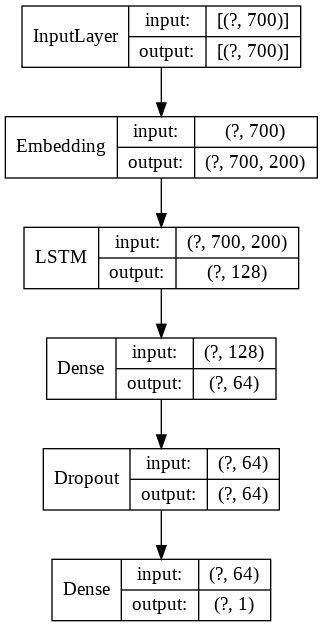

In [ ]:
plot_model(Glove_embedding_model, show_layer_names=False, show_shapes=True)

### **Fitting DL-Model 2:**

In [ ]:
history_glove_embedding_model = Glove_embedding_model.fit(X_train_sequences_matrix, y_train_dl_models, batch_size = batch_size,
                                                          epochs = epochs, validation_split = 0.2, verbose = 1,
                                                          callbacks=[EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, verbose = 1,
                                                                                   patience = 2, mode = 'min')])

Epoch 1/10
92/92 [==============================] - 408s 4s/step - loss: 0.1403 - accuracy: 0.9402 - val_loss: 0.0076 - val_accuracy: 0.9981
Epoch 2/10
92/92 [==============================] - 407s 4s/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 0.0057 - val_accuracy: 0.9983
Epoch 3/10
92/92 [==============================] - 403s 4s/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.0044 - val_accuracy: 0.9988
Epoch 4/10
92/92 [==============================] - 406s 4s/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0029 - val_accuracy: 0.9991
Epoch 5/10
92/92 [==============================] - 404s 4s/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0023 - val_accuracy: 0.9991
Epoch 6/10
92/92 [==============================] - 402s 4s/step - loss: 0.0133 - accuracy: 0.9963 - val_loss: 0.0079 - val_accuracy: 0.9980
Epoch 7/10
92/92 [==============================] - 408s 4s/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0032 - val_accuracy: 0.9988
Epoch 00007: 

### **Assessing of DL-Model 2:**

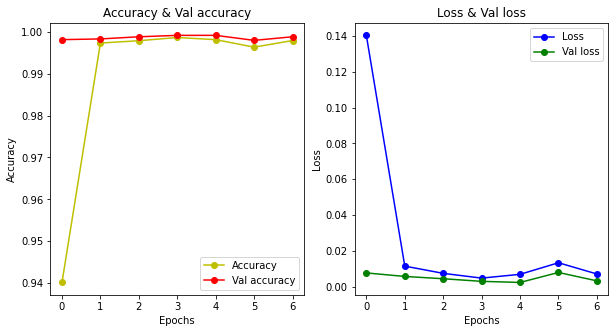

In [ ]:
epochs = [i for i in range(7)]
fig , ax = plt.subplots(1,2)
train_acc = history_glove_embedding_model.history['accuracy']
train_loss = history_glove_embedding_model.history['loss']
val_acc = history_glove_embedding_model.history['val_accuracy']
val_loss = history_glove_embedding_model.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'yo-' , label = 'Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Val accuracy')
ax[0].set_title('Accuracy & Val accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'bo-' , label = 'Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Val loss')
ax[1].set_title('Loss & Val loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
y_train_pred_proba = pd.DataFrame(Glove_embedding_model.predict(X_train_sequences_matrix))
y_train_pred_proba[:5]

0
0 0.0015
1 0.9999
2 0.0000
3 0.9999
4 0.0000

In [ ]:
y_train_pred_proba["pred"] = y_train_pred_proba.apply(lambda x: x > 0.5, axis = 1)

In [ ]:
y_train_pred_proba.head()

0   pred
0 0.0015  False
1 0.9999   True
2 0.0000  False
3 0.9999   True
4 0.0000  False

In [ ]:
print(classification_report(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12438
           1       1.00      1.00      1.00     16878

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



In [ ]:
print(classification_report(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"],
                            target_names = ["fake news", "real news"]))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00     12438
   real news       1.00      1.00      1.00     16878

    accuracy                           1.00     29316
   macro avg       1.00      1.00      1.00     29316
weighted avg       1.00      1.00      1.00     29316



In [ ]:
train_scores = Glove_embedding_model.evaluate(X_train_sequences_matrix, y_train_dl_models, verbose=0)
# [loss, accuracy]
print('Train loss score: ', train_scores[0])
print('Train accuracy score: ', train_scores[1])

Train loss score:  0.002344584558159113
Train accuracy score:  0.9994201064109802


       0      1
0  12433      5
1     12  16866


Text(0.5, 1.0, 'Train confusion matrix')

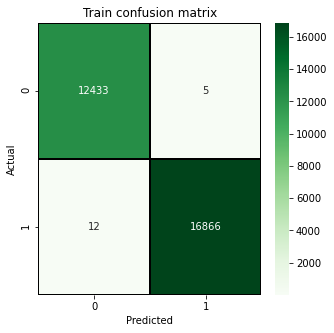

In [ ]:
cm_train_glove_model = confusion_matrix(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"])
print(pd.DataFrame(cm_train_glove_model))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_glove_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

           fake news  real news
fake news      12433          5
real news         12      16866


Text(0.5, 1.0, 'Train confusion matrix')

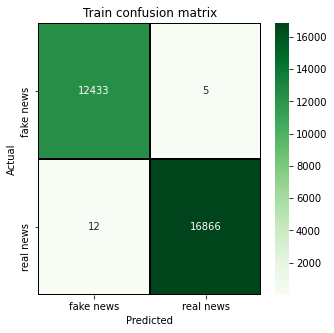

In [ ]:
cm_train_glove_model = confusion_matrix(y_true = y_train_dl_models, y_pred = y_train_pred_proba["pred"])
print(pd.DataFrame(cm_train_glove_model, index = ["fake news", "real news"], columns = ["fake news", "real news"]))

plt.figure(figsize = (5,5))
sns.heatmap(cm_train_glove_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = ["fake news", "real news"] , yticklabels = ["fake news", "real news"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Train confusion matrix")

### **Validation of DL-Model 2:**

In [ ]:
y_test_pred_proba = pd.DataFrame(Glove_embedding_model.predict(X_test_sequences_matrix))
y_test_pred_proba[:5]

0
0 0.0000
1 0.0000
2 0.9999
3 0.0026
4 0.0100

In [ ]:
y_test_pred_proba["pred"] = y_test_pred_proba.apply(lambda x: x > 0.5, axis = 1)

In [ ]:
y_test_pred_proba.head()

0   pred
0 0.0000  False
1 0.0000  False
2 0.9999   True
3 0.0026  False
4 0.0100  False

In [ ]:
print(classification_report(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3114
           1       1.00      1.00      1.00      4216

    accuracy                           1.00      7330
   macro avg       1.00      1.00      1.00      7330
weighted avg       1.00      1.00      1.00      7330



In [ ]:
print(classification_report(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"],
                            target_names = ["fake news", "real news"]))

              precision    recall  f1-score   support

   fake news       1.00      1.00      1.00      3114
   real news       1.00      1.00      1.00      4216

    accuracy                           1.00      7330
   macro avg       1.00      1.00      1.00      7330
weighted avg       1.00      1.00      1.00      7330



In [ ]:
test_scores = Glove_embedding_model.evaluate(X_test_sequences_matrix, y_test_dl_models, verbose=0)
# [loss, accuracy]
print('Test loss score: ', test_scores[0])
print('Test accuracy score: ', test_scores[1])

Test loss score:  0.0030767489224672318
Test accuracy score:  0.9994543194770813


      0     1
0  3113     1
1     3  4213


Text(0.5, 1.0, 'Test confusion matrix')

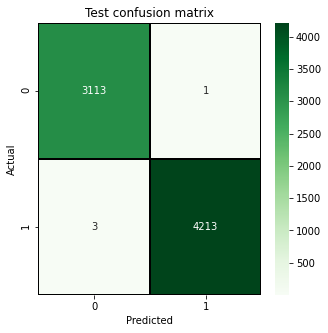

In [ ]:
cm_test_glove_model = confusion_matrix(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"])
print(pd.DataFrame(cm_test_glove_model))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_glove_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

           fake news  real news
fake news       3113          1
real news          3       4213


Text(0.5, 1.0, 'Test confusion matrix')

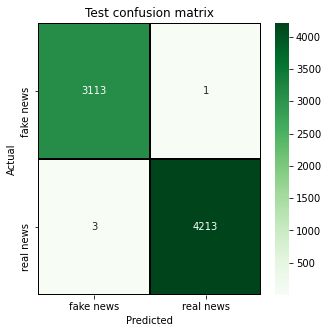

In [ ]:
cm_test_glove_model = confusion_matrix(y_true = y_test_dl_models, y_pred = y_test_pred_proba["pred"])
print(pd.DataFrame(cm_test_glove_model, index = ["fake news", "real news"], columns = ["fake news", "real news"]))

plt.figure(figsize = (5,5))
sns.heatmap(cm_test_glove_model,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True,
            fmt='' , xticklabels = ["fake news", "real news"] , yticklabels = ["fake news", "real news"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test confusion matrix")

### **Conclusions for DL-Model 2 - RNN model with Glove embedding & LSTM without lemmatization:**

*   Model assessing and validation:

    Train accuracy = 0.9994201064109802, Test accuracy = 0.9994543194770813, Train loss = 0.002344584558159113, Test loss = 0.0030767489224672318 --> **model assessment and validation are very good.**
*   Confusion matrix (Positive = fake news, negative = real news):

    Train FN = 5 (fake news the model predicted as real news).

    Train FP = 12 (real news the model predicted as fake news).

    Test FN = 1 (fake news the model predicted as real news).

    Test FP = 3 (real news the model predicted as fake news).

    --> **The model detects fake news a little better than real news.**

# **Final conclusions for all the models:**

## **1- Models rating:**

**The Best model         --> DL-Model 2 - RNN model with Glove embedding & LSTM without lemmatization.**

**The Second best model  --> DL-Model 1 - RNN model with LSTM & embedding - without lemmatization.**

**The Third place model  --> BOW-Model 1 - Logistic regression with lemmatization.**

**The Fourth place model --> BOW-Model 3 - Logistic regression without lemmatization.**

**The Fifth place model  --> BOW-Model 2 - Random forest with lemmatization.**

**The Last place model   --> BOW-Model 4 - Random forest without lemmatization.**


## **2- Models conclusions by type:**

**Deep learning models make the best predictions; Logistic regression models are the second best & Random forest models are in last place.**


## **3- BOW Models with / without lemmatization conclusions:**

**Both Logistic regression models & Random forest models are better with lemmatization.**


## **4- BOW Models VS. Deep Learning Modes conclusions:**

**BOW models had better results when using less frequent words from train data vocabulary, 
while Deep Learning models had better results when using most frequent words from train data vocabulary.**

